# Project: Linear Regression on King's County Home Sales Data Set

My goal of this project is to determine which features of the data set most influence the price of a home from two perspectives:
- the buyer
- the seller

Sub-goals or questions I will attempt to answer at the tail-end of this work include:
1. Do structural features or location, as a whole, influence home sale price more?

## Approach

My high-level approach is to build the most robust, most predictive model (with highest *Coefficient of Determination*, $R^2$) on the largest set of statistically significant features (those with low *p-value*) as possible.

To that end, I adopt standard *model validation* techniques, with some added caveats.

### High $R^2$ is not enough!
We are not only interested simply in the the model's *Coefficient of Determination*, $R^2$, but we also want a feel  of the confidence of that measure.

**A "high" $R^2$ (say, $R^2 \ge 0.7$) could be artificially inflated with a high degree of *multicolinearity*, for example**.

### Overfitting must be minimized
As part of our procedure when building linear regression models, we minimize over-fitting by utilizing the `stepwise_selection` routine, which, as its name suggests, selects features (or drops them) to be used in the model based on the range of their *p-value*.

A *low* p-value indicates that the feature is statistically significant in a linear relationship to its *target*.  In our case, we accept features with $0 \le p\_value < 0.05$.

This contributes to the confidence in the resulting $R^2$ from the get-go since we know that features which are not statistically significant will not appear in the model.

### Data Bias must be minimized as much as possible
I opted to use *sci-kit learn's* `train_test_split` api to split the data set into test/train partitions at the standard ratio of $0.70$/$0.30$.  After features are stepwise-selected, the model is fit to the *training* partition.  

I opted to not use *k-folds* for building the test/train partitions: a single pass of `train_test_split` is good enough in this case.

### Model validation
Confidence in the computed *Coefficient of Determination*, $R^2$ must be measured since not $R^2$'s are created equal!

I use the standard measure for that purpose: compute the **Mean Squared Error (MSE)** of the model on both the train and test partitions and compute the *delta*.  **A *delta* between MSE's of train/test predictions close to zero indicates high confidence in $R^2$**.

Additionally, as it relates to *multicolinearity*, I compute the **Variance Inflation Factor (VIF)** in the target of each feature.  Evidently, **a $VIF > 10$ indicates that a given feature has a high degree of *multicolinearity***.  I then summarize the aggregate to derive a ratio of "good" ($VIF \le 10$) vs "bad" ($VIF > 10$) features.  If this ratio is high (e.g. 70% or more), then our confidence in our measure of the *Coefficient of Determination* ($R^2$) increases.

### Conditions for success - i.e. whether a linear regression model is "good" or "bad"
Given the following conditions, we have a "GOOD" model:
1. $R^2 > .70$
2. $|MSE(test) - MSE(train)| \approx 0$
3. $\frac{|\{feature \in \{selected features\}: VIF(feature) \le 10\}|}{|\{selected features\}|} > .75$ 

The first condition says that we want models that determine the target with 70% confidence.

The second condition says that the bias toward the data is virtuall non-existent.

The third condition says that less than 25% of our selected features are considered *colinear*.

### Toward Regression
The process will occur in the following steps:
1. Import all necessary libraries and the the data set
2. Clean the data set
    1. Clean null values, if any
    2. Clean outlier values, if any
    3. Convert feature data types as necessary
3. EDA: Gain familiarity with the data set by building a preliminary linear regression model
    1. Explore distriubutions
    2. Explore colinearity
3. EDA: Scale, Normalize, Transform features in the data set as necessary
4. Run linear regression experiments to derive answers to the following questions:
    1. As a whole, do structural features or location influence home sale price more?
    2. If structural, which subset of features are the most influential?

## Step 1: Import Libraries and the Data Set

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import scipy.stats as stats
import numpy as np
from IPython.core.display import HTML
from statsmodels.formula.api import ols
import math
from itertools import combinations
import operator as op
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import folium
from folium import plugins

%matplotlib inline

plt.style.use('ggplot')

In [2]:
# import the data set
kchd_df = pd.read_csv('kc_house_data.csv')

## Step 2: Exploratory Data Analysis and Data Set Cleaning

The following utility function simply allows us to print multiple Pandas DataDrames with "pretty" (HTML) formatting, using the Python `print()` function.

We will use it throughout this notebook whenever we wish to display a DataFrame.

For now, we use it to get an intuitive initial feel for the data set.

In [3]:
# this function allows displaying dataframes using print() with pandas "pretty" HTML formatting
#   so that multiple "pretty" displays of dataframes can be rendered "inline"
#   default behavior (without specifying a range) is identical to that of df.head()
def print_df(df, r = None):
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_colwidth', -1)

    if r is None:
        r = range(0, len(df))
    display(HTML(df.iloc[r].to_html()))
    display(HTML("<br>{} rows x {} columns<br><br>".format(len(r), len(df.columns))))

    pd.reset_option('display.max_columns')
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_colwidth')

def print_df_head(df):
    print_df(df, range(0,5))    

print_df_head(kchd_df)

We noticed right off the bat that there is a null (`NaN`) value in the very first row.

## Step 2.A: Cleaning Null Values

We officially begin our *EDA* phase by cleaning null values in the data set.

The `cols_with_null_vals` function provides a summary of all features in our data set that have null values.

In [4]:
# note that we can qualitatively retrieve this information via df.info() but this function
#   provides us with an object we can manipulate programatically, whereas df.info() just 
#   prints the display of this information
def cols_with_nulls(df):
    cols_with_null_vals = []
    summary_cols = ['name', 'index', 'dtype', 'n_null']
    for idx, col in enumerate(df.columns):
        n_null = df[col].isna().sum()
        if n_null > 0:
            cols_with_null_vals.append([col, idx, df[col].dtype, n_null])
    return pd.DataFrame(cols_with_null_vals, columns=summary_cols)

kchd_cwnv_df = cols_with_nulls(kchd_df)
display(HTML("<b>Features with null values:</b><br><br>"))
print_df(kchd_cwnv_df)

We are working our way toward cleaning these null values.  As part of the process, after having identified which features need to be cleaned of null values, we must decide on a strategy for clearning this data.  One of the "Golden Rules" in Data Science is to avoid dropping observations from our data set at all costs and is only to be used as a last resort during the *EDA* phase.  So, we decide early that we will do absolutely no dropping of any observations containing null values whatsoever.  We opt to adopt a null-value *replacement* scheme.  But, we need some heuristic to decide target values which will replace nulls that makes sense.  Understanding the data better for each of these features should suggest an acceptable replacement heuristic.

To do this, we investigate the unique values of the above features, and whether those features are *continuous* or *categorical*.

###  Step 2.A: Cleaning Null Values: Using Unique Values (and Categorical "Classification") in Null-Value Replacement Guidance

Since *we do not wish to drop any observations containing null values* of **continuous** features and since *we do not wish to radically alter their distributions*, **we shall use some aggregate function which retains the existing central tendency of the *non-null* continuous values in our data set** - i.e. depending on the presence of outliers or not, in the case of continuous data, we opt to replace with the *median* or *mean* of the good values, respectively.

**We shall replace null values in categorical observations with some discrete value from the set of unique non-null categorical values**.  But which discrete value?  Well, this is where categorical classification comes in.  Thus, we must inspect the *meaning* of the categorical values in order to properly choose which value should replace a null value.

So, let's take a look that now.

**The first thing we need to do is determine which features *containing null-values* are categorical** (and which features are continuous).

The following function derives a probability that a given feature is categorical or not *based on the ratio of unique values to the total number of observations*.  If this ratio is very low, then it suffices to say that the probability is high that the feature is categorical.

In [5]:
def categorical_probability(df, col, exclude_null_vals=True):
    unique_vals = df[col].unique()
    n_unique = len(unique_vals) 
    if exclude_null_vals:
        if df[col].dtype is int or df[col].dtype is float or df[col].dtype is np.float64:
            unique_vals_without_null = unique_vals[~np.isnan(unique_vals)]
        else:
            unique_vals_without_null = unique_vals[~pd.isnull(unique_vals)]
        if len(unique_vals_without_null) < len(unique_vals):
            unique_vals = unique_vals_without_null
            n_unique -= 1
    unique_vals = sorted(unique_vals)
    return (n_unique, round(1 - (n_unique/(len(df[col]))), 4), unique_vals)

And then the next function wraps the above function to get a feel of whether the probabilities that features in the data as a whole are categorical, based on some threshold.

In [6]:
def classify_as_categorical(df, p_cat_th, exclude_null_vals=True):
    cols_classified = []
    summary_cols = ['name', 'index', 'dtype', 'n_unique', 'p_cat', 'unique_vals']
    for idx, col in enumerate(df.columns):
        n_unique, p_cat, unique_vals = categorical_probability(df, col, exclude_null_vals)
        if p_cat >= p_cat_th:
            cols_classified.append([col, idx, df[col].dtype, n_unique, p_cat, unique_vals])
    return pd.DataFrame(cols_classified, columns=summary_cols)

Let's use it now to help determine our replacement heuristic for the features that contain null-valued observations: **waterfront**, **view**, and **yr_renovated**.

In [7]:
p_cat = 0.0
kchd__nulls_with_cat_classification_df = classify_as_categorical(kchd_df[kchd_cwnv_df['name']], p_cat)
display(HTML("<b>Features with null-valued observations, categorical probability classification:</b><br><br>".format(p_cat)))
print_df(kchd__nulls_with_cat_classification_df)

As you can see, the probability that each of the above features is categorical is VERY HIGH!  This is consistent with the actual list of unique values for each (excluding null).

This gives an indication that we can use a *lteral-value replacement heuristic* when we clean this data.

We can see that:
- **waterfront** behaves as a *Boolean* value and that a null value can safely be replaced by 0.0
- **view** ranges from 0 to 4: here we must decide which of these values makes most sense to use as a replacement for null
    - 0 could mean no view but
    - so that we do not disrupt the central tendency, we could use the median value, 2.0
    - on the other hand, we could be unintentionally "un-skewing" this feature if the original intent of a null value was meant to be treated equivalent to value 0.0 - according to the documentation, **view** represents whether or not the property "has been viewed" (but it is really a count of the number of views).
    - in order to counter-act undesired skewing of the data, we opt to treat null values as equivalent to value 0.0
- **yr_renovated** clearly uses 0.0 to indicate that a home has not been renovated; so we will adopt the heuristic to replace null with 0.0 in this case

Since we have decided on the heuristics for all features with null values, we can clean those features now.

Note that, on a preliminary basis, it appears **there are no continuous features with null values**.

The function below was written to facilitate cleaning the data based on a text-based rule definition.  See the documentation preceding the function as comments for its usage.

In [8]:
# numeric_replacement_rules should be of the form:
#    {<name_of_col>: [(outlier_val_1, 'median'|'mean'|<numeric_replacement_value>), ((outlier_val_2, 'median'|'mean'|<numeric_replacement_value>)), ... , (outlier_val_n, 'median'|'mean'|<numeric_replacement_value>)]}}
def clean_offending_values(df, numeric_replacement_rules = None, string_replacement_rules = None, friendly_name_of_df = ""):
    friendly_name = friendly_name_of_df if len(friendly_name_of_df) > 0 else "df"
    print("*** CLEANING VALUES of {}: BEGIN ***\n".format(friendly_name))
    
    has_numeric_rules = numeric_replacement_rules is not None
    has_string_rules = string_replacement_rules is not None

    if has_numeric_rules or has_string_rules:

        if has_numeric_rules:
            for col, rules in numeric_replacement_rules.items():
                print("Rules for '{}' column value replacement are: {}".format(col, rules))
                # first determine if there are any offending values, which means we first need to collate said values
                offending_vals = []
                for val, rule in rules:
                    offending_vals.append(val)
                print("Looking for rows with '{}' values {} ...".format(col, offending_vals))
                df_rows_with_outliers = df[df[col].isin(offending_vals)==True]
                if len(df_rows_with_outliers) > 0:
                    offending_indexes = df_rows_with_outliers.index
                    print("Rows with offending values occur at {}.".format(offending_indexes))
                    # now handle specific replacement rule - we only have three allowable: median, mean, or a constant value
                    # if the rule is a constant value, then we can replace in place
                    data_type = type(rule)
                    replace_with_numeric_literal = data_type is int or data_type is float or data_type is np.float64
                    replace_with_median = data_type is str and rule.lower() == 'median'
                    replace_with_min = data_type is str and rule.lower() == 'min'
                    replace_with_max = data_type is str and rule.lower() == 'max'
                    replace_with_mean = data_type is str and rule.lower() == 'mean'
                    if replace_with_numeric_literal:
                        df.loc[offending_indexes, col] = rule
                        print("Replaced {} offending instances in column '{}' with literal value {}\n".format(len(offending_indexes), col, rule))
                    elif replace_with_median or replace_with_min or replace_with_max or replace_with_mean:
                        # first we need to get a subset of the rows WITHOUT any of the offending values
                        df_rows_without_outliers = df[df[col].isin(offending_vals)==False]
                        if replace_with_median or replace_with_min or replace_with_max:
                            unique_vals = sorted(df_rows_without_outliers[col].unique())
                            imputed = np.min(unique_vals) if replace_with_min else (np.min(unique_vals) if replace_with_max else np.median(unique_vals))
                            s_imputed_from = "unique values: {}".format(unique_vals)
                        else:
                            imputed = np.mean(df_rows_without_outliers[col])
                            s_imputed_from = "values from index domain:\n{}".format(df_rows_without_outliers.index) 
                        df.loc[offending_indexes, col] = imputed 
                        s_desc = "the {} of column '{}'".format(rule, col)  
                        print("{} is {} and was imputed from {}".format(s_desc.capitalize(), imputed, s_imputed_from))
                        print("Replaced {} offending instances in column '{}' with {} ({})\n".format(len(offending_indexes), col, s_desc, imputed))
                    else:
                        print("Unsupported or unknown rule: {}".format(rule))                   
                else:
                    print("There are no rows that contain values of '{}' in {}!".format(col, offending_vals))

        if has_string_rules:
            for col, rules in string_replacement_rules.items():
                print("Rules for '{}' are: {}".format(col, rules))
                # first determine if there are any offending values, which means we first need to collate said values
                offending_vals = []
                for val, rule in rules:
                    offending_vals.append(val)
                print("Looking for rows with '{}' values in {} ...".format(col, offending_vals))
                df_rows_with_outliers = df[df[col].isin(offending_vals)==True]
                if len(df_rows_with_outliers) > 0:
                    offending_indexes = df_rows_with_outliers.index
                    print("Rows with offending values occur at {}.".format(offending_indexes))
                    df.loc[offending_indexes, col] = rule
                    print("Replaced {} offending instances in column '{}' with literal value '{}'\n".format(len(offending_indexes), col, rule))                 
                else:
                    print("There are no rows that contain values of '{}' in {}!".format(col, offending_vals))

    else:
        print("Cannot clean outliers from {} since there were no replacement rules provided!".format(friendly_name))
    
    print("*** CLEANING VALUES of {}: END ***".format(friendly_name))

In [9]:
# now use the above function to clean 'waterfront' and 'yr_renovated' using lteral-value replacement
clean_offending_values(
    kchd_df
    , numeric_replacement_rules=
        {
            'waterfront': [(np.NaN, 0.0)]
            , 'view': [(np.NaN, 0.0)]
            , 'yr_renovated': [(np.NaN, 0.0)]
        }
    , friendly_name_of_df="King County House Sales DF"
)

*** CLEANING VALUES of King County House Sales DF: BEGIN ***

Rules for 'waterfront' column value replacement are: [(nan, 0.0)]
Looking for rows with 'waterfront' values [nan] ...
Rows with offending values occur at Int64Index([    0,    10,    23,    40,    55,    60,    62,    66,    87,
              105,
            ...
            21544, 21545, 21550, 21562, 21567, 21578, 21582, 21586, 21587,
            21595],
           dtype='int64', length=2376).
Replaced 2376 offending instances in column 'waterfront' with literal value 0.0

Rules for 'view' column value replacement are: [(nan, 0.0)]
Looking for rows with 'view' values [nan] ...
Rows with offending values occur at Int64Index([    7,   114,   129,   205,   487,   590,   938,  1313,  1364,
             1701,  2415,  2833,  3150,  3237,  4533,  4740,  5196,  5207,
             5393,  5494,  5585,  5746,  6391,  7103,  7269,  7563,  7686,
             7716,  8047,  8066,  8279,  8575,  9405,  9853, 10023, 10174,
            1033

Having dealt with features with null values, we can now turn our attention to identifying and handling any potential outlier values.

## Step 2.B: Deal with outlier values

Now that we've cleaned all null-values (replaced with non-null values that make sense), we can get some idea of whether a given feature has any outlier values by inspecting its list of unique values.

We can leverage `classify_as_categorical` to help identify such outlier values.

If we spot any peculiar values we can then deal with them as necessary.

In [10]:
# Let's look for outliers
p_cat = 0.0
kchd_cat_classification_df = classify_as_categorical(kchd_df[kchd_df.columns[1:]], p_cat, False)
display(HTML("<b>Columns with potentical OUTLIER values:</b><br><br>".format(p_cat)))
print_df(kchd_cat_classification_df[['name', 'dtype', 'n_unique', 'p_cat', 'unique_vals']].set_index('name'))

Based on the above, we do spot a few specific issues:

1. based on *unique_vals* of **bedrooms**, it has an *apparent* OUTLIER value: 33.
2. based on *unique_vals* and *dtype* of **sqft_basement**, it looks like it should be a *numeric* data type but it is of type `Object` (probably stored as text).
3. the *dtype* of **yr_built** and **yr_renovated** is `int64` and `float64`, respectively; since these features store the same kind of values (year), we will convert **yr_renovated** to `int64`.

Let's address **sqft_basement** first.

## Step 2.B: Deal with outlier values: Converting **sqft_basement** from `string` type to `float`

Before attempting to convert the data type of **sqft_basement** to `float`, we need to replace any potential non-numeric values.

Let's find those first.

In [11]:
unique_sqft_basement = kchd_cat_classification_df[kchd_cat_classification_df['name']=='sqft_basement']['unique_vals'].values[0]
non_numeric_sqft_basement_vals = []
for idx, sqft_basement in enumerate(unique_sqft_basement):
    s_val = sqft_basement.strip()
    val = None
    try:       
        val = float(s_val)
    except:
        non_numeric_sqft_basement_vals.append(sqft_basement)

display(HTML("<b>sqft_basement</b> contains the following non-numeric values that must be replaced: {}".format(non_numeric_sqft_basement_vals)))

We opt to replace outlier value '?' of the **sqft_basement** feature with '0.0' *before* we finally convert it from `str` to `float`.

In [12]:
clean_offending_values(
    kchd_df
    , string_replacement_rules=
        {
            'sqft_basement': [('?', '0.0')]
        }
    , friendly_name_of_df="King County House Sales DF"
)

*** CLEANING VALUES of King County House Sales DF: BEGIN ***

Rules for 'sqft_basement' are: [('?', '0.0')]
Looking for rows with 'sqft_basement' values in ['?'] ...
Rows with offending values occur at Int64Index([    6,    18,    42,    79,   112,   115,   217,   309,   384,
              508,
            ...
            21236, 21248, 21356, 21357, 21365, 21442, 21447, 21473, 21519,
            21581],
           dtype='int64', length=454).
Replaced 454 offending instances in column 'sqft_basement' with literal value '0.0'

*** CLEANING VALUES of King County House Sales DF: END ***


We can now convert **sqft_basement** to type `float`:

In [13]:
kchd_df['sqft_basement']=kchd_df['sqft_basement'].astype('float64')

### Step 2.B: Deal with outlier values: Converting **yr_renovated** from `float` type to `int`

In [14]:
kchd_df['yr_renovated']=kchd_df['yr_renovated'].astype('int64')

### Step 2.B: Deal with outlier values: Handling **bedrooms** outliers

In [15]:
outlier_rooms = 33
kchd_with_outlier_rooms_df = kchd_df[kchd_df['bedrooms']==outlier_rooms]
kchd_with_outlier_rooms_df

id       date     price  bedrooms  bathrooms  sqft_living  \
15856  2402100895  6/25/2014  640000.0        33       1.75         1620   

       sqft_lot  floors  waterfront  view  ...  grade  sqft_above  \
15856      6000     1.0         0.0   0.0  ...      7        1040   

       sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
15856          580.0      1947             0    98103  47.6878 -122.331   

       sqft_living15  sqft_lot15  
15856           1330        4700  

[1 rows x 21 columns]

Here, we see that there are home(s) that supposedly have 33 bedrooms.  Really?  I don't think so but let's try to justify this mathematically.

We see that the value of **sqft_living** is only 1620.

Let's compute the average square footage per room and compare its value to the average square footage per room of the entire data set, excluding this possible outlier observation, with **bedrooms**==33.

In [16]:
outlier_rms_avg_sqft_per_room = kchd_with_outlier_rooms_df['sqft_living']/outlier_rooms
outlier_rms_avg_sqft_per_room[outlier_rms_avg_sqft_per_room.index]

15856    49.090909
Name: sqft_living, dtype: float64

We see that, for the outlier, the average square footage per room is about 49 ft.$^2$.  That means, on average, each room is 7 ft. x 7 ft.  Is this likely?  Let's compare it to the average square footage per room of the entire data set, excluding this possible outlier observation with **bedrooms**==33.

In [17]:
avg_sqft_per_room_excluding_apparent_outlier = kchd_df['sqft_living'].sum()/kchd_df[kchd_df['bedrooms'].isin([outlier_rooms])==False]['bedrooms'].sum()
avg_sqft_per_room_excluding_apparent_outlier

617.0000686643413

We see that our outlier average square footage per room differs *drastically* from the average for the data set.  So we will impute the average (of the data set) to arrive at a reasonable value for **bedrooms** for the outlier.  Granted, this is only one observation and we have done a bit of work so far to clean this outlier value.  But, this process demonstrates the potential importance in the general case.

The formula for this is: $imputed\_outlier\_bedrooms = \frac{outlier\_sqft\_living}{avg\_sqft\_per\_room\_excluding\_apparent\_outlier}$.

In [18]:
imputed_outlier_bedrooms = kchd_with_outlier_rooms_df['sqft_living']/avg_sqft_per_room_excluding_apparent_outlier
imputed_outlier_bedrooms = imputed_outlier_bedrooms.values[0]
imputed_outlier_bedrooms

2.62560748738151

In [19]:
unique_bedrooms = sorted(list(kchd_df['bedrooms'].unique()))
unique_bedrooms.remove(outlier_rooms)
unique_bedrooms = np.array(unique_bedrooms)
print("Permissable values of bedrooms is: {}".format(unique_bedrooms))

Permissable values of bedrooms is: [ 1  2  3  4  5  6  7  8  9 10 11]


Since **imputed_outlier_bedrooms** $\in \mathbb{R}$, we need to match it to its closest neighbor in the range of *permissable* categorical values of **bedrooms**, \[1  2  3  4  5  6  7  8  9 10 11\].

In [20]:
idx_closest_br = -1
min_dist = -1
for idx, br in enumerate(unique_bedrooms):
    d = abs(imputed_outlier_bedrooms - br)
    if min_dist == -1:
        min_dist = d
        idx_closest_br = idx
    elif d < min_dist:
        min_dist = d
        idx_closest_br = idx

print("The closest (categorical) bedroom value to computed real-value {}, from {}, is {}, occuring at index {}.".format(imputed_outlier_bedrooms, unique_bedrooms, unique_bedrooms[idx_closest_br], idx_closest_br))
imputed_outlier_bedrooms = unique_bedrooms[idx_closest_br]

The closest (categorical) bedroom value to computed real-value 2.62560748738151, from [ 1  2  3  4  5  6  7  8  9 10 11], is 3, occuring at index 2.


Now we impute this value in the data set for all observations with the **bedrooms** outlier value, 33.

In [21]:
kchd_df.loc[kchd_with_outlier_rooms_df.index, 'bedrooms'] = imputed_outlier_bedrooms

## Step 2.C: Convert feature data types as necessary
We noticed in step 2.B that the *dtype* of **yr_built** and **yr_renovated** is `int64` and `float64`, respectively; since these features store the same kind of values (year), we need to convert **yr_renovated** to `int64`.

In [22]:
kchd_df['yr_renovated']=kchd_df['yr_renovated'].astype('int64')

## Step 2: Finalize Data Cleaning

And with that, we have our final, cleaned data set.

Note that we will drop the **id** and **date** features:
1. **id** will not contribute whatsoever to linear regression
2. if **date** DOES contribute it will likely be due to other factors outside of this data set - e.g. the stock market, the local economy, unemployment rates, etc; so we just drop it from the start to remove any external influence from our model

The only thing left to do is store the results as an immutable basis, upon which all other manipulations will be based.

In [23]:
kchd_cleaned_df = kchd_df.drop(['id', 'date'], axis=1)

## Step 3: EDA through a Preliminary Linear Regression Model: Getting to Know the Features and Data

We now want to get a feel for how the feature set performs in a linear regression model without *scaling*, *normalization*, or *log-transformation*.

But first, we need the code to do so!

The following functions form the basis for running our linear regression experiements.

### Functions Required for running our linear regression experiments

In [24]:
def plot_corr(df, filter=None):
    corr = df[filter].corr() if (filter is not None and len(filter) > 0) else df.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(22, 18))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(
        corr
        , mask=mask
        , cmap=cmap
        , vmax=1.0
        , center=0
        , square=True
        , linewidths=.5
        , cbar_kws={"shrink": .5}
    )
    plt.title("Feature Correlations")
    plt.show();

In [25]:
def histograms(df, filter=None):
    feats = filter if (filter is not None and len(filter) > 0) else df.columns
    
    s_html = "<h3>Distributions:</h3><ul>"
    s_html += "<li><b>feature set</b>: {}</li>".format(feats)
    s_html += "</ul>"
    display(HTML(s_html))
    
    r_w = 20
    r_h = 4
    c_n = 4
    r_n = len(df.columns)/c_n
    r_n = int(r_n) + (1 if r_n % int(r_n) != 0 else 0)

    fig = plt.figure(figsize=(r_w, r_h*r_n))

    axes = fig.subplots(r_n, c_n)
    unused = list(range(0, len(axes.flatten())))

    included_feats = []
    for index, feat in enumerate(feats):
        ax = fig.add_subplot(r_n, c_n, index+1)
        sns.distplot(df[feat], ax=ax)
        plt.xlabel(feat)
        included_feats.append(feat)
        unused.remove(index)

    flattened_axes = axes.flatten()
    for u in unused:
        fig.delaxes(flattened_axes[u])

    fig.tight_layout()
    plt.show();

    return included_feats

In [26]:
def nCr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return int(numer / denom)

In [27]:
def cv_build_feature_combinations(X, upper_bound=2**18, boundary_test=False):
    feat_combos = dict()
    
    r = range(1, len(X.columns)+1)
        
    n = max(r)
    
    # determine whether or not we will exhause memory!
    len_total_combos = 0
    
    s_n_choose_k = "{} \\choose {}"
    if not boundary_test:
        s_total_combos = "<br><br>Builing all $\\sum_{i=" + str(min(r)) + "}^{" + str(n) + "}{" + s_n_choose_k.format(n, "i") + "}=$"
        for k in r:
            s_total_combos += " ${" + s_n_choose_k.format(n, k) + "}$" + (" +" if k!=n else "")
            len_combos = nCr(n, k)
            len_total_combos += len_combos
        s_total_combos += " $={}$ combinations of feature set: {}...".format(len_total_combos, X.columns)
        display(HTML(s_total_combos))
    else:
        len_total_combos = 2**n - 1
    
    if len_total_combos > upper_bound:
        display(HTML("<h2><font color=\"red\">Building all combinations of {} features would result in cross-validating {} models which will most likely exhaust memory (exceeds upper bound: {})!  Please reduce the size of the feature set and try again!</font></h2>".format(n, len_total_combos, upper_bound)))
        feat_combos = None
    else:
        if not boundary_test:
            for k in r:
                #display(HTML("Building ${}={}$ combinations of {} features (out of {})...".format("{" + s_n_choose_k.format(n, k) + "}", nCr(n, k), k, n)))
                feat_combos_of_length_k = list(combinations(X, k))
                #display(HTML("All done! The list of all combinations of {} features (out of {}) will be cross-validated against {} models.<br><br>".format(k, n, len(feat_combos_of_length_k))))    
                feat_combos[k] = feat_combos_of_length_k
        else:
            display(HTML("<h2><font color=\"green\">Boundary test PASSED!  Building all combinations of {} features will result in cross-validating {} models, which is less than upper bound: {}.</font></h2>".format(n, len_total_combos, upper_bound)))
    
    display(HTML("All done!"))    
    
    return (feat_combos, len_total_combos)

In [28]:
def cv_selection(X, y, tr, folds, scoring_method, fn_better_score):
    cv_feat_combo_map, len_total_combos = cv_build_feature_combinations(X)
    if cv_feat_combo_map is None:
        return
    
    base_feature_set = list(X.columns)
    n = len(base_feature_set)
    
    linreg = LinearRegression()
    
    best_score = 0
    best_feat_combo = None
    for n_feats, list_of_feat_combos in cv_feat_combo_map.items():
        n_choose_k = len(list_of_feat_combos)
        k = len(list_of_feat_combos[0])
        s_n_choose_k = "{} \\choose {}"
        display(HTML("Cross-validating ${}={}$ combinations of {} features (out of {})...".format("{" + s_n_choose_k.format(n, k) + "}", n_choose_k, k, n)))
        
        for feat_combo in list_of_feat_combos:           
            feat_combo = list(feat_combo)
            
            #X_train, X_test, y_train, y_test = train_test_split(X[feat_combo], y, test_size=tr, random_state=42)
            #print("computing mean {} score over {} k-folds using feature-set combo: {}".format(scoring_method, folds, feat_combo))
            mean_cv_score = abs(
                np.mean(
                    cross_val_score(
                        linreg
                        , X[feat_combo]
                        , y
                        , cv=folds
                        , scoring=scoring_method
                    )
                )
            ) 
            #print("\tscore: {}".format(mean_cv_scor))
            #print()
            if best_score == 0 or fn_better_score(mean_cv_score, best_score):
                best_score = mean_cv_score
                best_feat_combo = feat_combo
                print("new best {} score: {}, from feature-set combo: {}".format(scoring_method, best_score, best_feat_combo))
    
    print("\ncv_selected best {} = {}".format(scoring_method, best_score))
    print("\ncv_selected best feature-set combo:\n{}".format(best_feat_combo))
    print("\nstarting feature-set:\n{}".format(base_feature_set))
    
    return (best_feat_combo, best_score)

In [29]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    included_pvals = []
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            included_pvals.append(best_pval)
            changed=True
            if verbose:
                print("Add  {:30} with p-value {:.6}".format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            #worst_feature = pvalues.argmax()
            worst_feature = pvalues.idxmax()
            del included_pvals[included.index(worst_feature)]
            included.remove(worst_feature)
            if verbose:
                print("Drop {:30} with p-value {:.6}".format(worst_feature, worst_pval))
        if not changed:
            break
            
    #included_aux = sorted(d_included.items(), key=lambda feat_pval: feat_pval[1])
    #print(included_aux)
        
    return (included, included_pvals)

In [30]:
def skl_lin_reg_validation(X, y, tr, verbose=False):
    linreg = LinearRegression()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tr, random_state=42)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_residuals = y_hat_train - y_train
    test_residuals = y_hat_test - y_test
    train_mse = mean_squared_error(y_train, y_hat_train)
    test_mse = mean_squared_error(y_test, y_hat_test)

    if verbose:
        s_html = "<table><table><thead><thead><tr><td><b>train/test-split ratio</b>: <b>{}/{}</b></td></tr></thead><tbody>".format(1-tr, tr)
        s_html += "<tr><td><table><tbody><tr><td><table><tbody><tr><td>|X_train| = {}</td><td>|X_test| = {}</td><td>|y_train| = {}</td><td>|y_test| = {}</td></tr></tbody></table></td></tr>".format(len(X_train), len(X_test), len(y_train), len(y_test))
        s_html += "<tr><td><table><tbody><tr><td>Train MSE:</td><td>{}</td></tr></tbody></table></td></tr>".format(train_mse)
        s_html += "<tr><td><table><tbody><tr><td>Test MSE:</td><td>{}</td></tr></tbody></table></td></tr>".format(test_mse)
        s_html += "<tr><td><table><tbody><tr><td><b>delta</b>:</td><td><b>{}</b></td></tr></tbody></table></td></tr>".format(abs(train_mse - test_mse))        
        s_html += "</tbody></table></table>"
        display(HTML(s_html))

    return (X_train, X_test, y_train, y_test, train_mse, test_mse, linreg)

In [31]:
def find_best_train_test_split(X, y, step_size = 5, verbose=False):
    delta_min = -1
    best_tr = 0
    X_train_best = None
    X_test_best = None
    y_train__best = None
    y_test_best = None
    train_mse_best = None
    test_mse_best = None
    linreg_best = None

    for test_ratio in range(step_size, 100, step_size):
        tr = test_ratio/100
        (X_train, X_test, y_train, y_test, train_mse, test_mse, linreg) = skl_lin_reg_validation(X, y, tr, verbose)
        delta = abs(train_mse - test_mse)
        if delta_min == -1 or delta < delta_min:
            delta_min = delta
            best_tr = tr
            X_train_best = X_train
            X_test_best = X_test
            y_train_best = y_train
            y_test_best = y_test
            train_mse_best = train_mse
            test_mse_best = test_mse
            linreg_best = linreg

    s_html = "<table><table><thead><thead><tr><td>best train/test-split ratio: {}/{}</td></tr></thead><tbody>".format(1-best_tr, best_tr)
    s_html += "<tr><td><table><tbody><tr><td><table><tbody><tr><td>|X_train| = {}</td><td>|X_test| = {}</td><td>|y_train| = {}</td><td>|y_test| = {}</td></tr></tbody></table></td></tr>".format(len(X_train_best), len(X_test_best), len(y_train_best), len(y_test_best))
    s_html += "<tr><td><table><tbody><tr><td>Train MSE:</td><td>{}</td></tr></tbody></table></td></tr>".format(train_mse_best)
    s_html += "<tr><td><table><tbody><tr><td>Test MSE:</td><td>{}</td></tr></tbody></table></td></tr>".format(test_mse_best)
    s_html += "<tr><td><table><tbody><tr><td>delta:</td><td>{}</td></tr></tbody></table></td></tr>".format(delta_min)        
    s_html += "</tbody></table></table>"
    display(HTML(s_html))

    return (X_train_best, X_test_best, y_train_best, y_test_best, train_mse_best, test_mse_best, linreg_best)

In [32]:
def lin_reg_model_from_auto_selected_features(df, target, tr = None):
    print("Computing most statstically significant features...")
    
    data_fin_df = df.copy()
    
    y = data_fin_df[target]
    X = data_fin_df.drop([target], axis=1)
    
    sel_features, their_pvals = stepwise_selection(X, y, verbose=True)  
    
    if tr is None:
        X_train, X_test, y_train, y_test, train_mse, test_mse, _ = find_best_train_test_split(X[sel_features], y)
    else:
        X_train, X_test, y_train, y_test, train_mse, test_mse, _ = skl_lin_reg_validation(X[sel_features], y, tr, True)
        
    #pca = PCA()
    #X_train_PCA = pca.fit_transform(X_train)
    #X_test_PCA = pca.transform(X_test)
    #explained_variance = pca.explained_variance_ratio_
    #print(explained_variance)

    f = target + '~' + "+".join(sel_features)
    data_fin_df = pd.concat([y_train, X_train], axis=1, join='inner').reset_index()
    model = ols(formula=f, data=data_fin_df)

    return (sel_features, their_pvals, X_train, X_test, y_train, y_test, train_mse, test_mse, model)

In [33]:
def model_fit_feature_summary(df, feat_idx, model_fit_results, force_display=False):
    feat = df.columns[feat_idx]
    
    v = vif(np.matrix(df), feat_idx)
    colinear = v > 10
    
    if colinear or force_display:   
        fig = plt.figure(figsize=(10,10))
        sm.graphics.plot_regress_exog(model_fit_results, feat, fig=fig)
        #fig = plt.figure(figsize=(5,5))
        #sns.distplot(df[feat]) 
        fig.tight_layout()
        plt.show()      
        display(
            HTML(
                "Variance Inflation Factor (<i>VIF</i>) for <b>{}</b>: <b>{}</b> ({})<br><br>".format(
                    feat
                    , round(v, 2)
                    , "<b>GOOD</b>, low colinearity $\\iff VIF \\le 10$" if not colinear else "BAD, <b>HIGH COLINEARITY</b> $\\iff VIF>10$"
                )
            )
        )
    
    return v

In [34]:
def model_fit_summary(df, sel_features, their_pvals, model, tr, train_mse, test_mse, mv_r_sq_th, mv_mse_delta_th, mv_bad_vif_ratio_th):
    # get results of OLS fit from previously computed model
    model_fit_results = model.fit()
    
    delta_mse = abs(test_mse - train_mse)
    valid_r_sq = model_fit_results.rsquared >= mv_r_sq_th

    # for each feature, compute VIF and optionally display QQ plot
    display(HTML("<h3>Regression Diagnostics</h3>"))
    good_vifs = []
    bad_vifs = []
    for idx, feat in enumerate(sel_features):        
        v = model_fit_feature_summary(df[sel_features], idx, model_fit_results)
        if v <= 10:
            good_vifs.append((feat, round(v, 2), their_pvals[sel_features.index(feat)]))
        else:
            bad_vifs.append((feat, round(v, 2), their_pvals[sel_features.index(feat)]))    
    # order good VIF features by p-value
    good_vifs = sorted(good_vifs, key=lambda good_vif: good_vif[2])    
    # order bad VIF features by VIF
    bad_vifs = sorted(bad_vifs, key=lambda bad_vif: bad_vif[1], reverse=True)
    good_vif_ratio = len(good_vifs)/len(sel_features)
    bad_vif_ratio = 1 - good_vif_ratio
    
    # VIF/colinearity summary
    display(HTML("<h3>VIF Summary</h3>"))
    s_html = "<br><b>'GOOD' FEATURES</b> (<i>with LOW COLINEARITY, VIF <= 10</i>), ordered by favorable (increasing) p-val:<ol>"
    for good_vif in good_vifs:
        s_html += "<li><b>{:30}</b>: p-val $= {}$</li>".format(good_vif[0], good_vif[2])
    s_html += "</ol>"
    display(HTML(s_html))    
    s_html = "<br><b>'BAD' FEATURES</b> (<i>with HIGH COLINEARITY, VIF > 10</i>), ordered by unfavorable (decreasing) VIF:<ol>"
    for bad_vif in bad_vifs:
        s_html += "<li><b>{:30}</b>: VIF $= {}$</li>".format(bad_vif[0], bad_vif[1])
    s_html += "</ol>"
    display(HTML(s_html)) 
    good_vif_ratio = len(good_vifs)/len(sel_features)
    display(HTML("<br><b>{}% of features are 'GOOD'.<br>".format(round(good_vif_ratio*100,2))))
    plot_corr(df)
    
    # always displays QQ plot of residuals and density plots of target 
    fig = plt.figure(figsize=(10, 5))
    axes = fig.subplots(1, 2)
    sm.graphics.qqplot(model_fit_results.resid, dist=stats.norm, line='45', fit=True, ax=axes[0])
    sns.distplot(df[target], ax=axes[1])   
    fig.tight_layout()
    plt.show();
    
    # display the OLS summary
    display(HTML(model_fit_results.summary().as_html()))
    
    s_html = "<h3>Model Validation Summary</h3><ol>"
    s_html += "<li><b>$R^2={} \ge $</b> acceptable threshold ({}): <b>{}</b></li>".format(
        model_fit_results.rsquared
        , mv_r_sq_th
        , "PASS" if valid_r_sq else "FAIL"
    )    
    valid_delta_mse = delta_mse <= mv_mse_delta_th
    s_html += "<li><b>$\Delta MSE=|{}-{}|={} \le $</b> acceptable threshold ({}): <b>{}</b></li>".format(
        test_mse
        , train_mse
        , delta_mse
        , mv_mse_delta_th
        , "PASS" if valid_delta_mse else "FAIL"
    )    
    valid_bad_vif_ratio = mv_bad_vif_ratio_th > bad_vif_ratio
    s_html += "<li><b>bad VIF ratio = ${}$%</b> < acceptable threshold ({}%): <b>{}</b></li>".format(
        round(bad_vif_ratio*100,2)
        , round(mv_bad_vif_ratio_th*100,2)
        , "PASS" if valid_bad_vif_ratio else "FAIL"
    )
    s_html += "</ol>"
    s_html += "<b>Model Validation Assessment: {}</b>".format("PASS" if (valid_r_sq and valid_delta_mse and valid_bad_vif_ratio) else "FAIL")
    display(HTML(s_html))
    
    return (model_fit_results, good_vifs, bad_vifs)

In [35]:
def summarize_multicolinearity(df, target, corr_filter_threshold = 0.75):
    #features_only_df = df.drop([target], axis=1)
    features_only_df = df
    features_only_corr = features_only_df.corr()
    features_only_corr_bool_df = abs(features_only_corr) > corr_filter_threshold
    
    display(HTML("<b>Independent features that are greater than {}% correlated</b>:".format(round(corr_filter_threshold*100, 2))))
    print_df(features_only_corr_bool_df)

    plt.figure(figsize=(15,12))
    sns.heatmap(features_only_corr, center=0)
    plt.show();
    
    correlations = dict()
    max_corr = None
    correlated = []
        
    for index, col in enumerate(features_only_corr_bool_df.columns):
        corr_bool_counts = features_only_corr_bool_df[col].value_counts()
        if corr_bool_counts[1] > 1:  # then we have a pair-wise correlation > corr_filter_threshold
            # print("\n{} has {} correlations in corr_bool_counts:\n{}".format(col, corr_bool_counts[1], kchd_features_only_corr_bool_df[kchd_features_only_corr_bool_df[col]==True]))
            corrs = []
            for c in list(features_only_corr_bool_df[features_only_corr_bool_df[col]==True].index):
                if c != col:
                    corr = round(features_only_corr[col][c], 2)                    
                    print("{} {}% correlated to {}".format(col, round(corr*100, 2), c))                    
                    if col in correlations:
                        correlations[col].append((c, corr))
                    else:
                        correlations[col] = [(c, corr)]
                    if max_corr is None:
                        max_corr = (col, correlations[col])
                    elif len(correlations[col]) > len(max_corr[1]):
                        max_corr = (col, correlations[col])
                    corrs.append(c)
            correlated.append(corrs)
    if len(correlations) == 0:
        print("Congratulations! The {} feature-set does not manifest multicolinearity for threshold {}!".format(features_only_df.columns, corr_filter_threshold))       
    
    print("\nmost severe correlation: {}".format(max_corr))
    
    #largest_intersection(correlated)
    
    return (correlations, max_corr)  

Now that we have the necessary functions, we can now run our preliminary linear regression experiment on our cleaned data set.

Note that, since this is a preliminary model, we have not done any scaling, normalization, or log-transformation of the data.

Let's see how it performs!

In [36]:
target = 'price'
tr = 0.3

#print(nCr(len(kchd_cleaned_df.drop(target, axis=1).columns), 13))
#cv_selection(kchd_cleaned_df.drop(target, axis=1), kchd_cleaned_df[[target]], tr=tr)

In [37]:
# we need to find an allowable size for the set of features - as we have seen above, it is possible to get into the 100s of thoursands very quickly
#base_predictors_df = kchd_cleaned_df.drop(target, axis=1)
#while (len(base_predictors_df.columns) > 0):
#    cv_feat_combos_map, _ = cv_build_feature_combinations(base_predictors_df, upper_bound=2**18, boundary_test=True)
#    if cv_feat_combos_map is not None:
#        break
#    else:
#        base_predictors_df = base_predictors_df.drop(base_predictors_df.columns[-1], axis=1)        
#    if len(base_predictors_df.columns) == 0:
#        display(HTML("Exhausted columns!"))

In [38]:
#test_cv_sel_feats = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'sqft_basement', 'condition', 'yr_built', 'yr_renovated']
#cv_selection(kchd_cleaned_df.drop(target, axis=1), kchd_cleaned_df[[target]], tr)

Computing most statstically significant features...
Add  floors                         with p-value 0.0


/Users/stevencontreras/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Add  sqft_living15                  with p-value 0.0
Add  sqft_living                    with p-value 0.0
Drop floors                         with p-value 0.131602
Add  lat                            with p-value 0.0
Add  view                           with p-value 0.0
Add  grade                          with p-value 2.20467e-295
Drop sqft_living15                  with p-value 0.169561
Add  yr_built                       with p-value 0.0
Add  waterfront                     with p-value 4.0863e-255
Add  bedrooms                       with p-value 3.86294e-53
Add  bathrooms                      with p-value 1.92687e-51
Add  zipcode                        with p-value 3.15121e-42
Add  long                           with p-value 4.16508e-55
Add  condition                      with p-value 9.11738e-20
Add  sqft_above                     with p-value 1.07784e-21
Add  yr_renovated                   with p-value 1.7494e-08
Add  sqft_living15                  with p-value 3.8648e-09
Add  sqft_

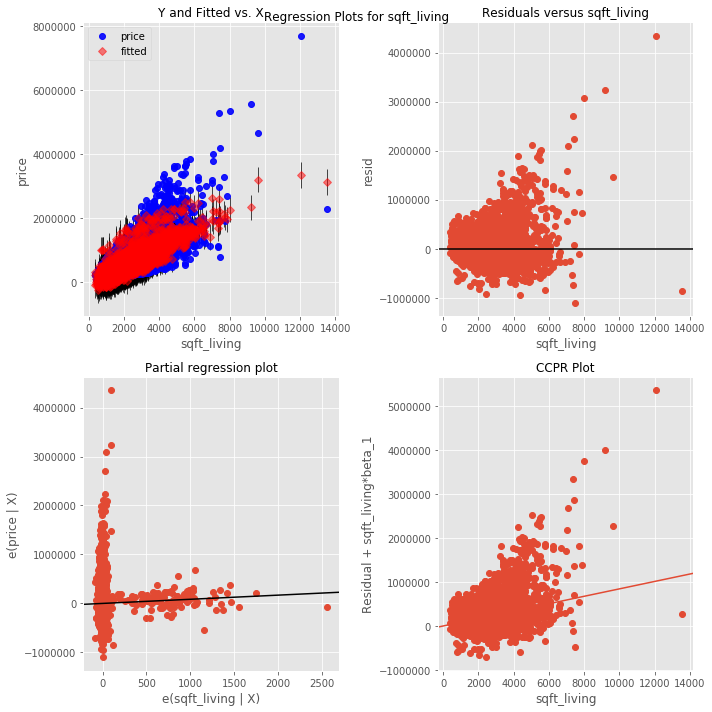

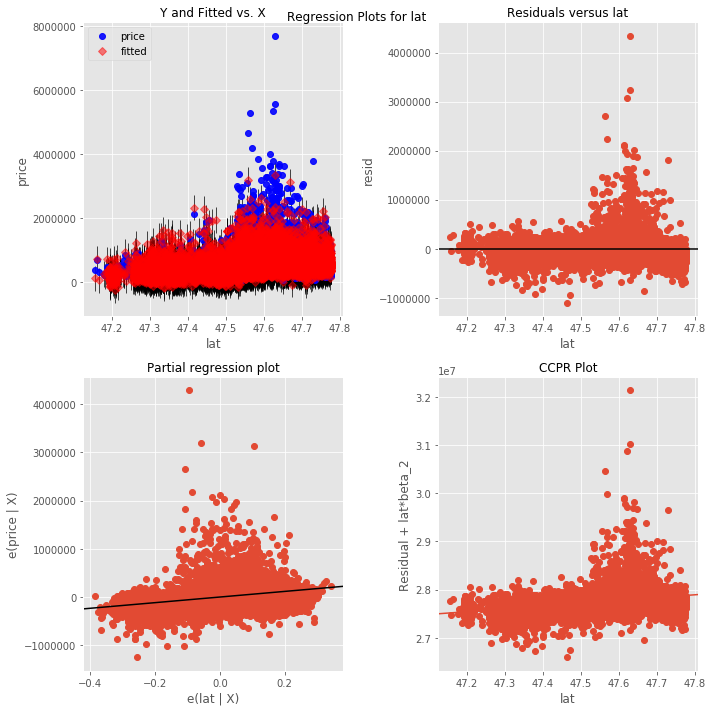

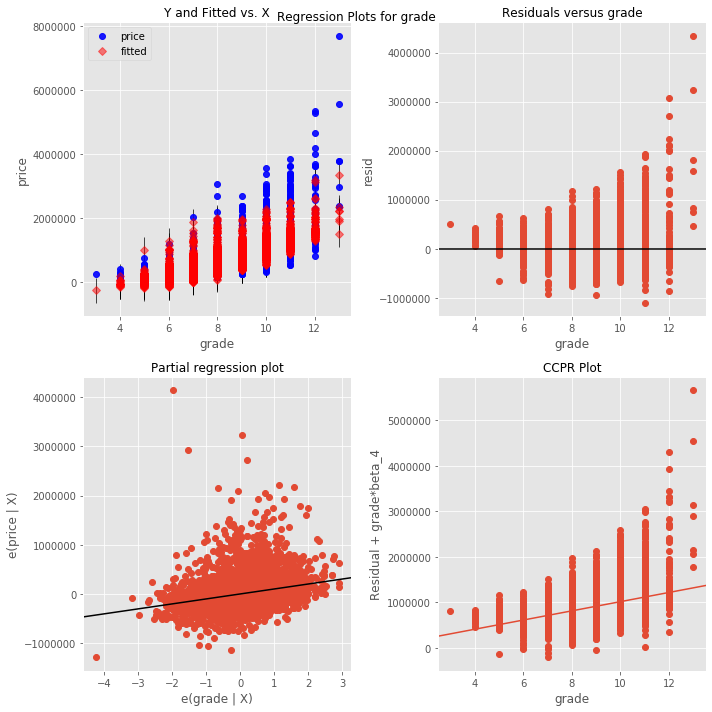

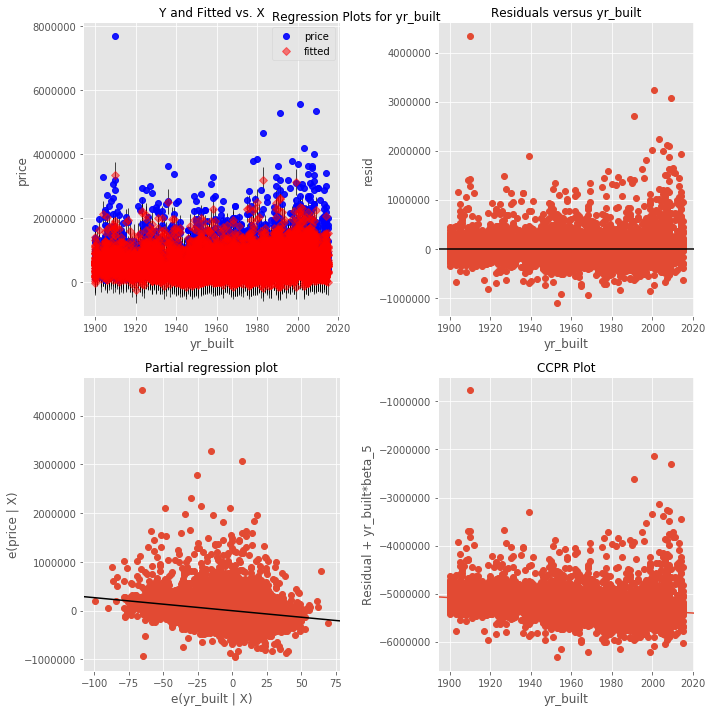

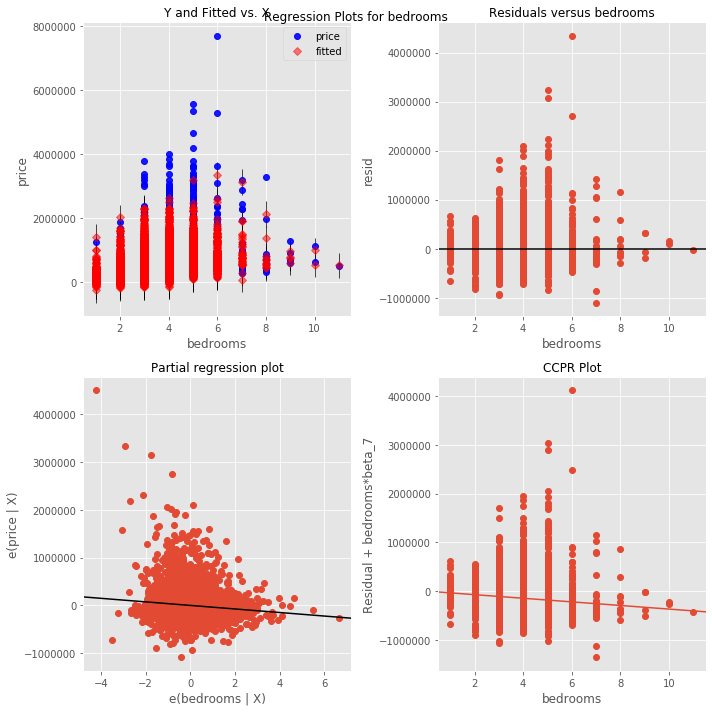

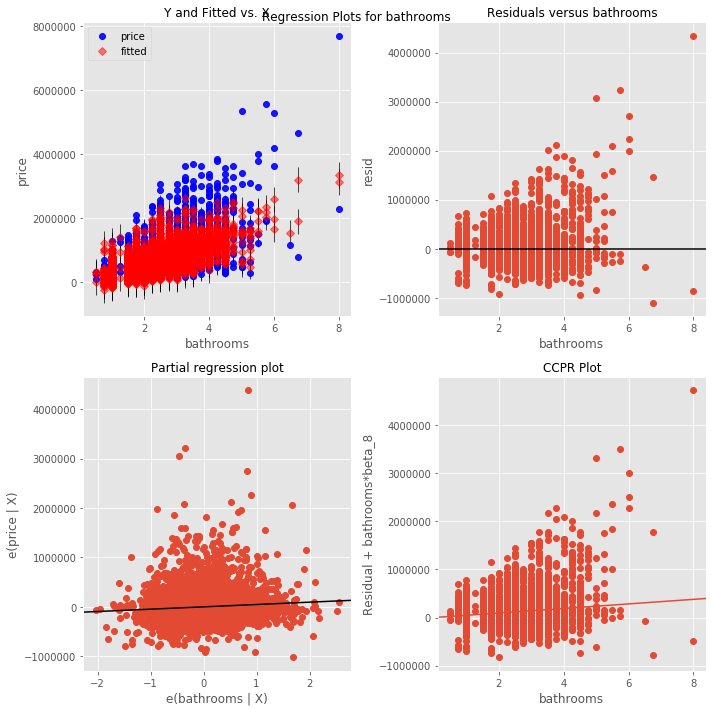

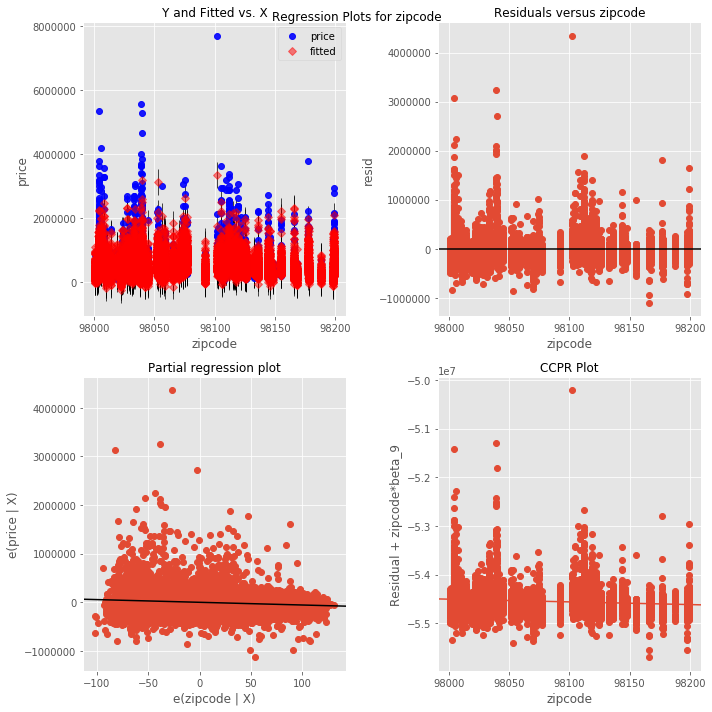

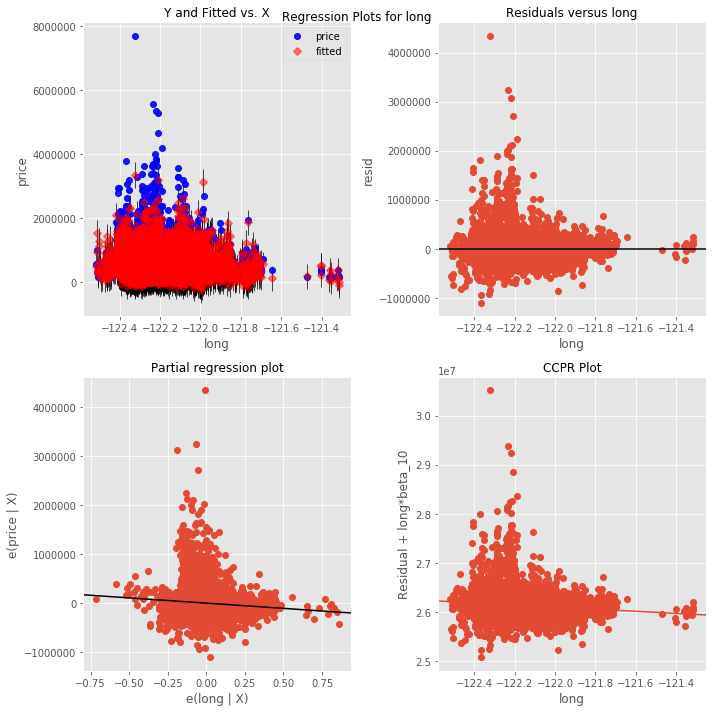

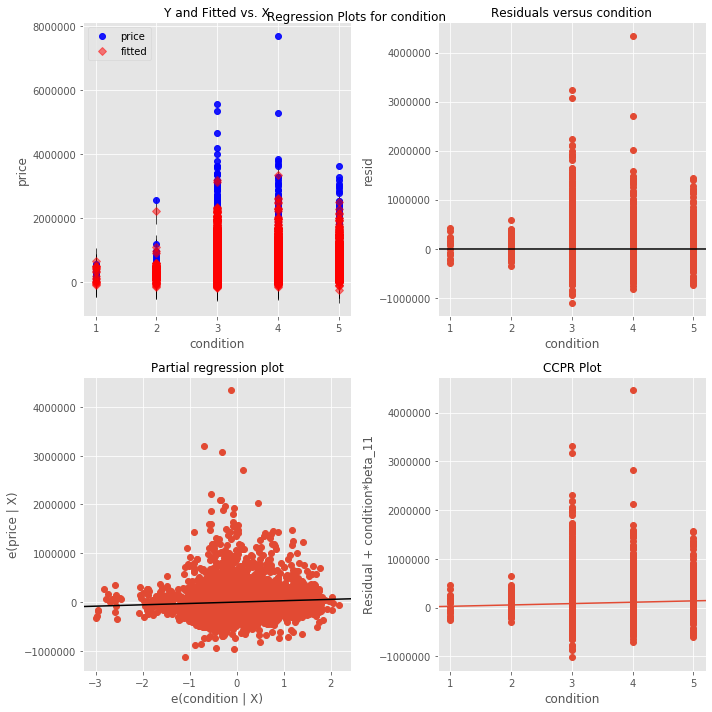

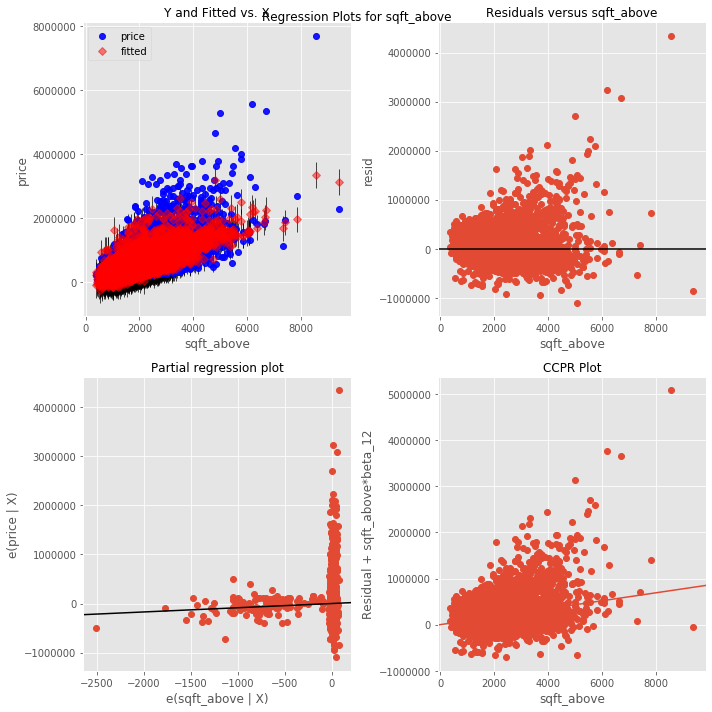

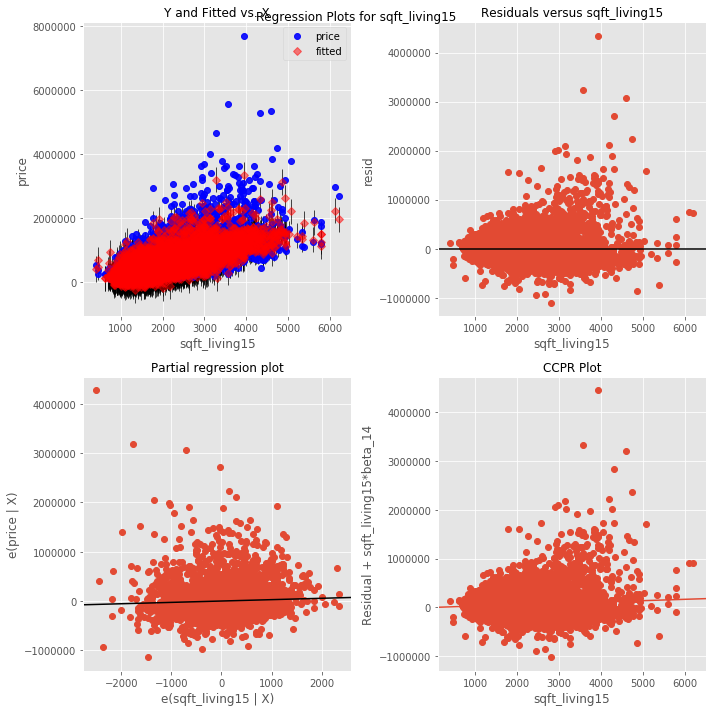

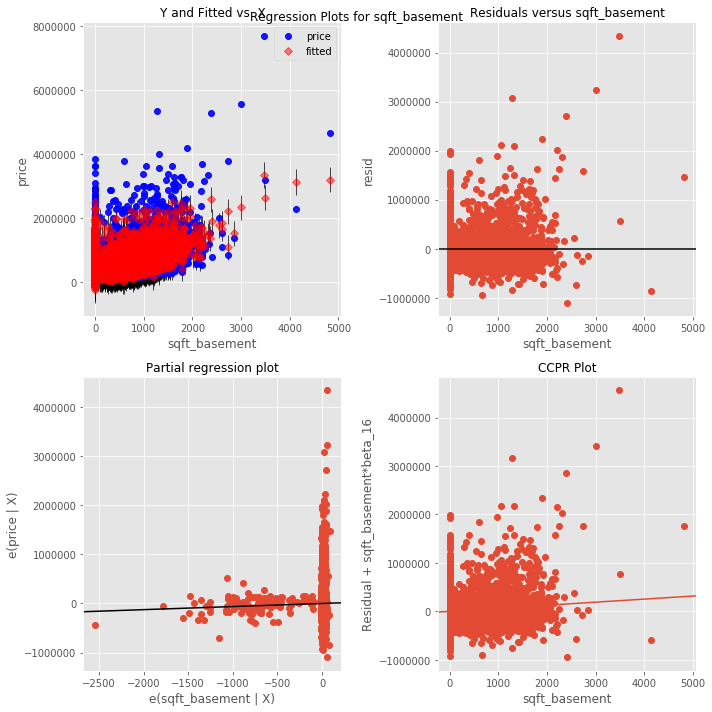

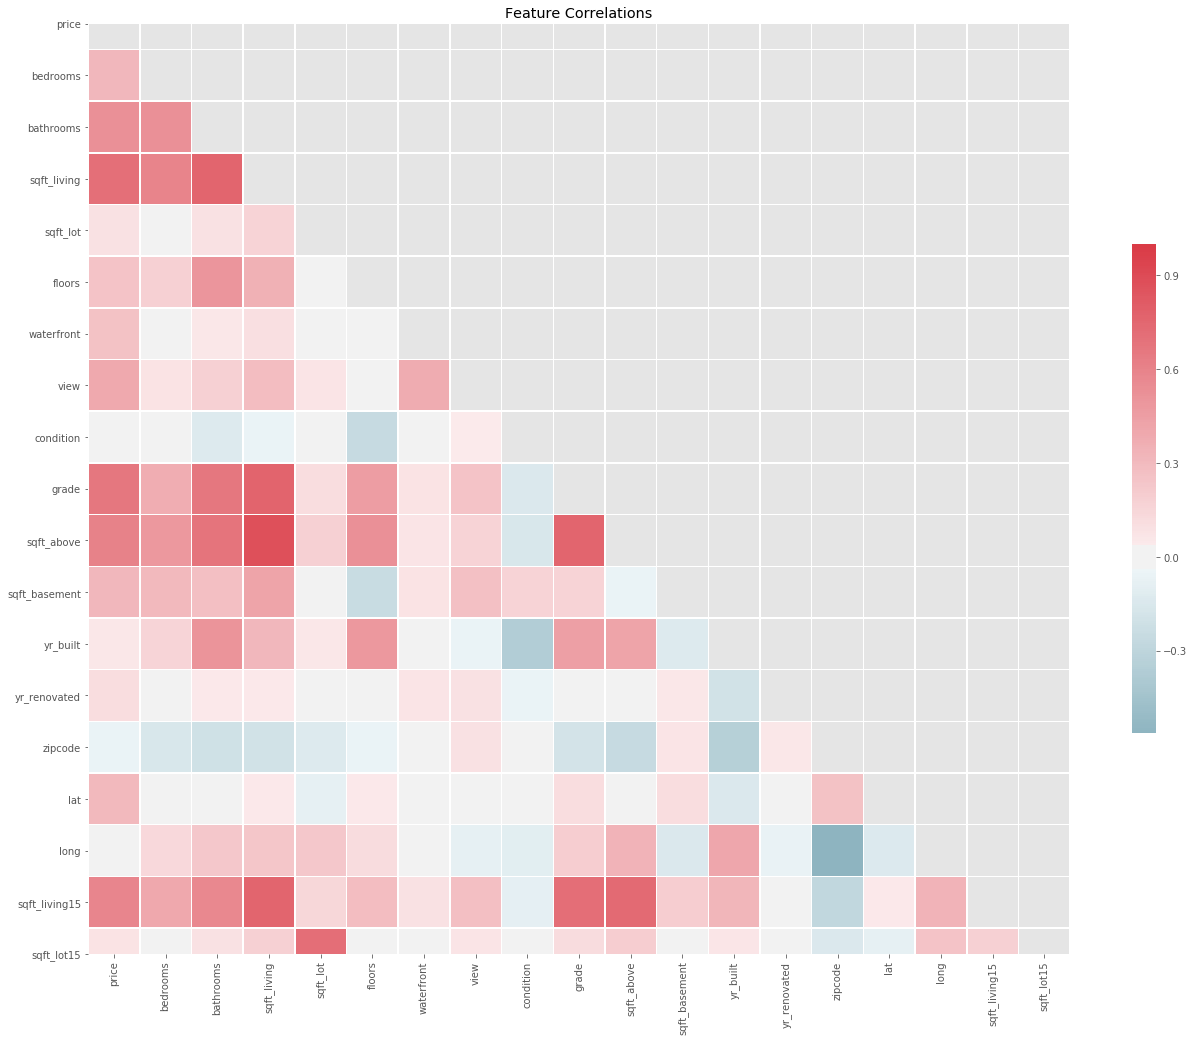

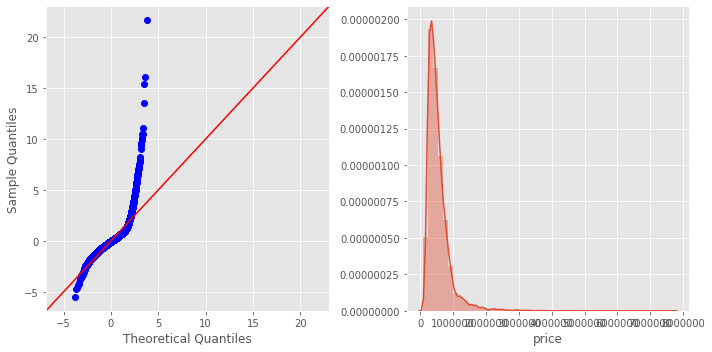

In [39]:
mv_r_sq_th = .70
mv_mse_delta_th = 1000 #???
mv_bad_vif_ratio_th = 0.30

s_html = "<h1>Preliminary Linear Regression Model:</h1><ul>"
s_html += "<li><b>target</b>: {}</li>".format(target)
s_html += "<li><b>feature set</b>: {}</li>".format(kchd_cleaned_df.drop(target, axis=1).columns)
s_html += "<li><b>training/test split ratio</b>: ${}/{}$</li>".format(1-tr, tr)
s_html += "</ul>"
display(HTML(s_html))

(
    sel_features
    , their_pvals
    , X_train
    , X_test
    , y_train
    , y_test
    , train_mse
    , test_mse, model
) = lin_reg_model_from_auto_selected_features(kchd_cleaned_df, target, tr=tr)

(model_fit_results, good_vif_features, bad_vif_features) = model_fit_summary(
    kchd_cleaned_df
    , sel_features
    , their_pvals
    , model
    , tr
    , train_mse
    , test_mse
    , mv_r_sq_th
    , mv_mse_delta_th
    , mv_bad_vif_ratio_th
)

### Step 3: EDA through a Preliminary Linear Regression Model: Analysis

In [40]:
display(HTML("$R^2 = {}$ is pretty good! But model validation fails two out three of our PASS conditions.".format(round(model_fit_results.rsquared, 3))))
display(HTML("Take a look at the difference in MSEs between our training and test partitions - note that we split based on a ${}$/${}$ ratio.".format(1-tr, tr)))
display(HTML("<b>The difference between MSE of our train/test partitions is a woeful ${}$</b>!".format(int(abs(train_mse-test_mse)))))

Note, in particular, that OLS reports that **"there are
strong multicollinearity or other numerical problems"** in the data set.

Our VIF summary states in more detail that most of our features are colinear.

#### CONCLUSION:

**This is not a well-performing model**.

We MUST do some work to improve the performance of our preliminary linear regression model if we hope to predict sale price with confidence. 

#### What can we do to improve its performance?

The first thing we notice in the QQ-plot and the distribution plot of our target, **price**, is that it is heavily skewed - i.e. NOT normally distributed.

Again, before we opt to drop any features due to misbehavior, we shall scale and possibly transform our data set as a first measure.

But before we get into that, let's **give *price* a normal distribution by *log-transforming* it**.  And of course we will re-run regression to investigate the impact.

### Step 3: EDA through a Preliminary Linear Regression Model, v. 2.0

Computing most statstically significant features...
Add  floors                         with p-value 0.0


/Users/stevencontreras/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Add  sqft_living15                  with p-value 0.0
Add  sqft_living                    with p-value 0.0
Add  lat                            with p-value 0.0
Add  view                           with p-value 0.0
Add  grade                          with p-value 0.0
Drop floors                         with p-value 0.150928
Add  yr_built                       with p-value 0.0
Add  bathrooms                      with p-value 3.39177e-115
Add  condition                      with p-value 8.52738e-84
Add  waterfront                     with p-value 3.34106e-66
Add  floors                         with p-value 2.166e-59
Add  zipcode                        with p-value 1.48233e-37
Add  long                           with p-value 7.58078e-19
Add  sqft_lot                       with p-value 1.99337e-16
Add  yr_renovated                   with p-value 6.65132e-16
Add  bedrooms                       with p-value 2.22277e-08
Add  sqft_lot15                     with p-value 0.00287224
Add  sqft_baseme

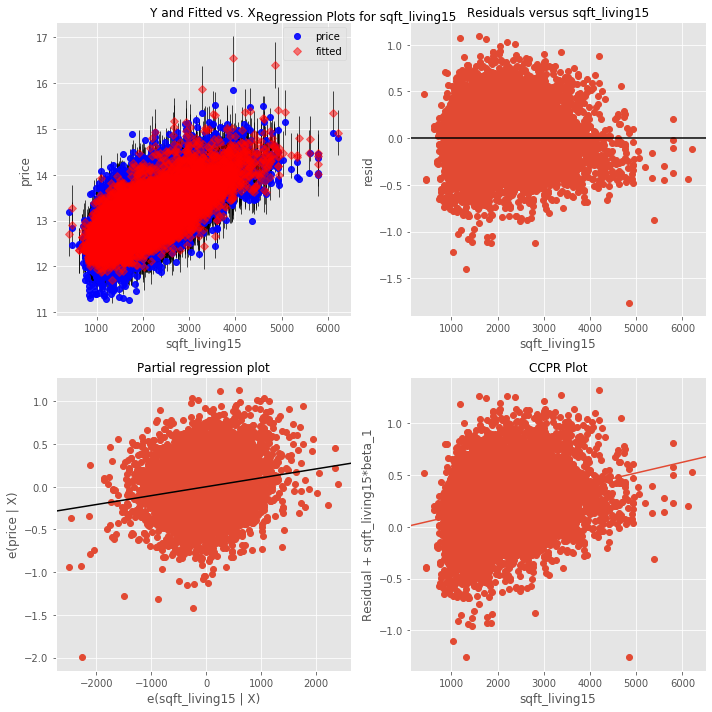

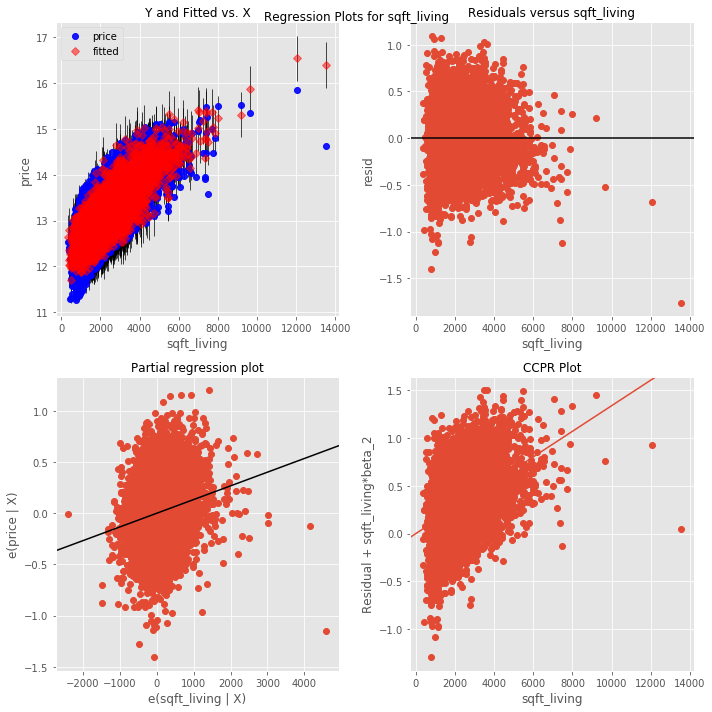

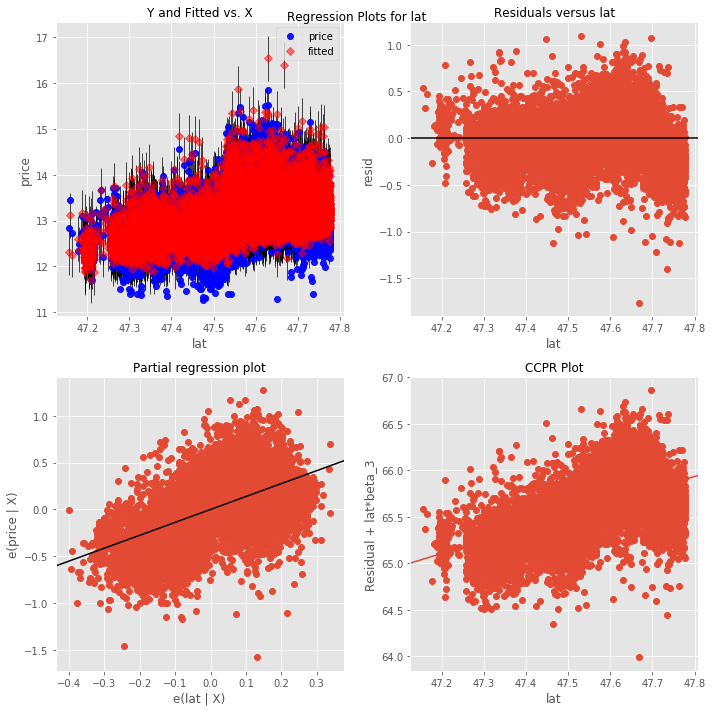

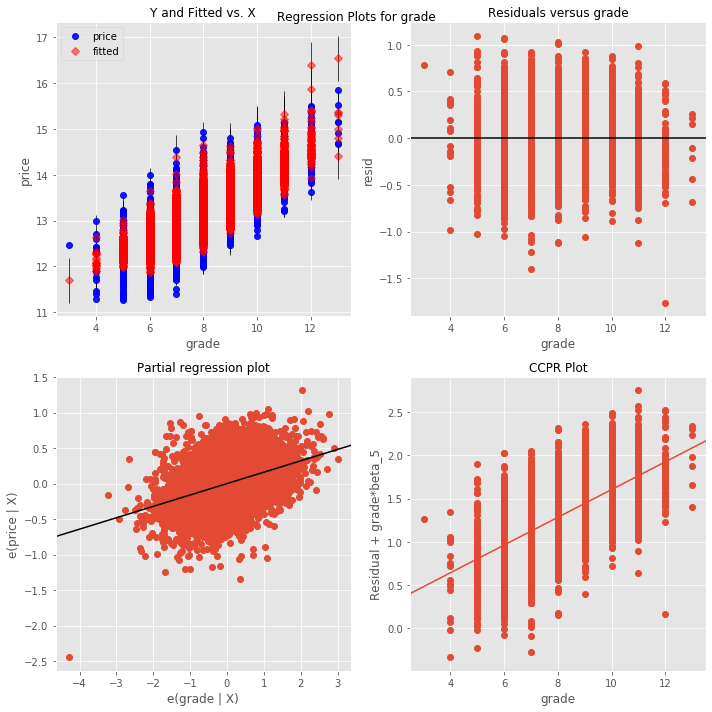

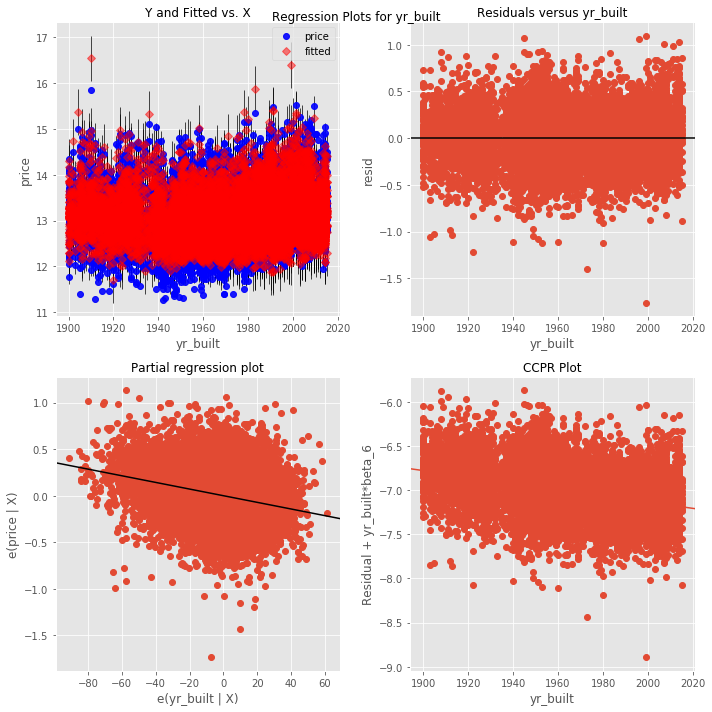

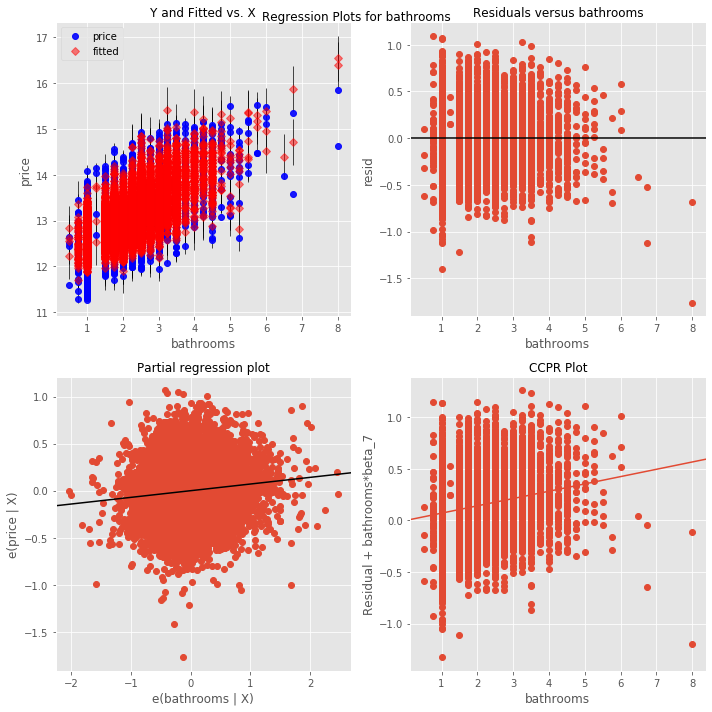

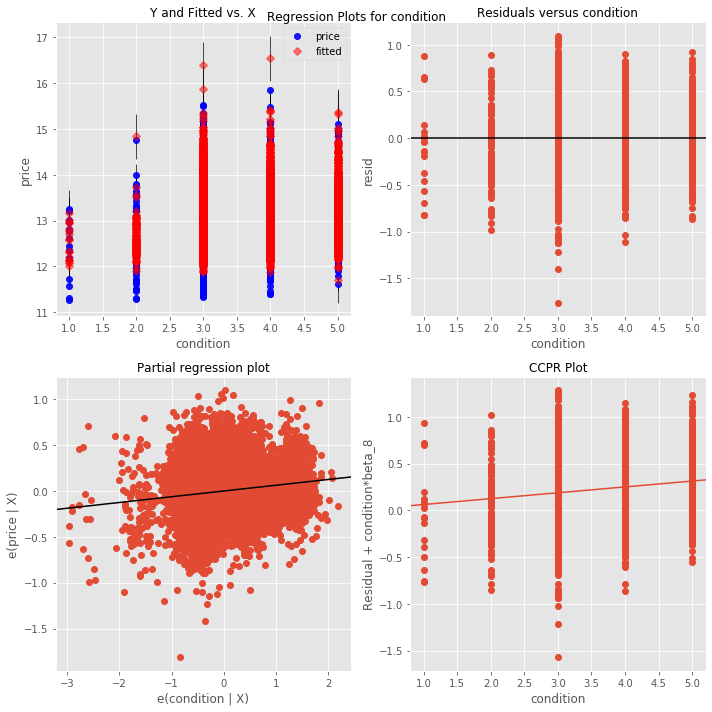

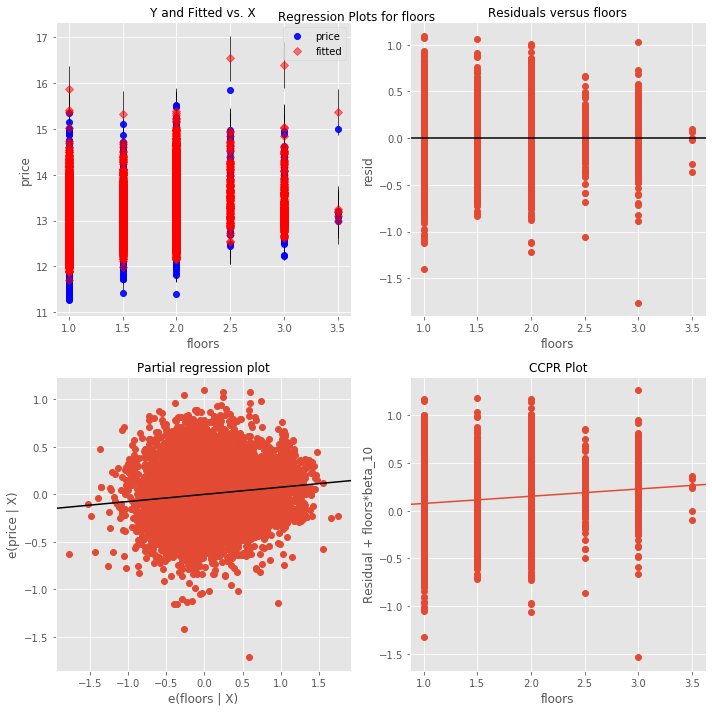

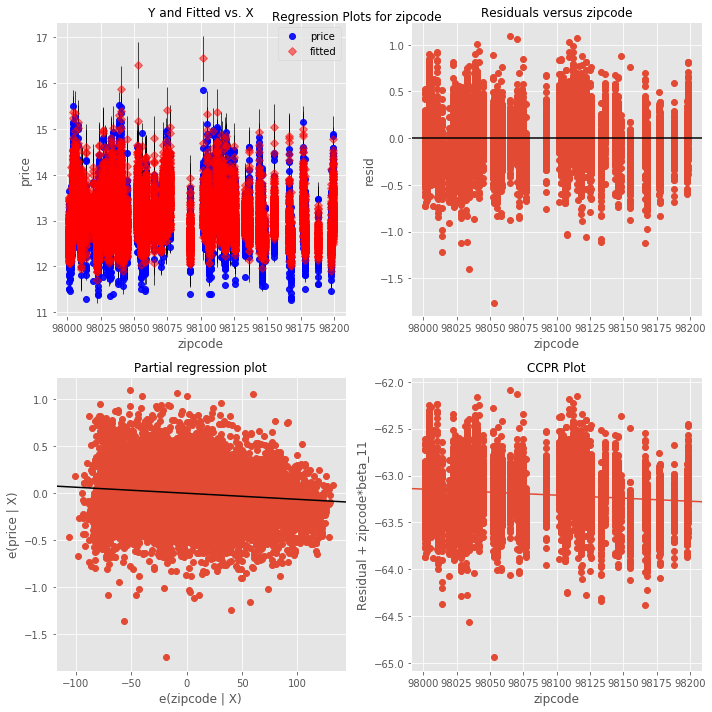

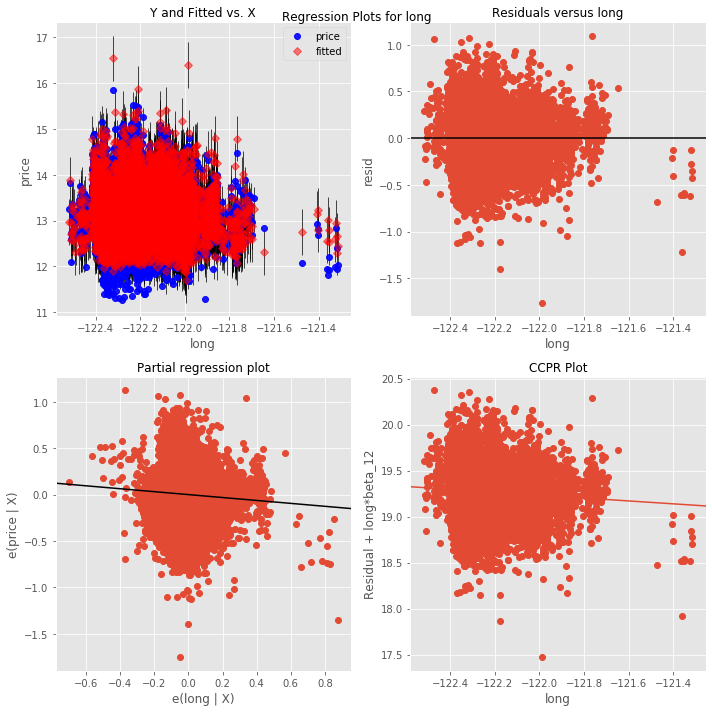

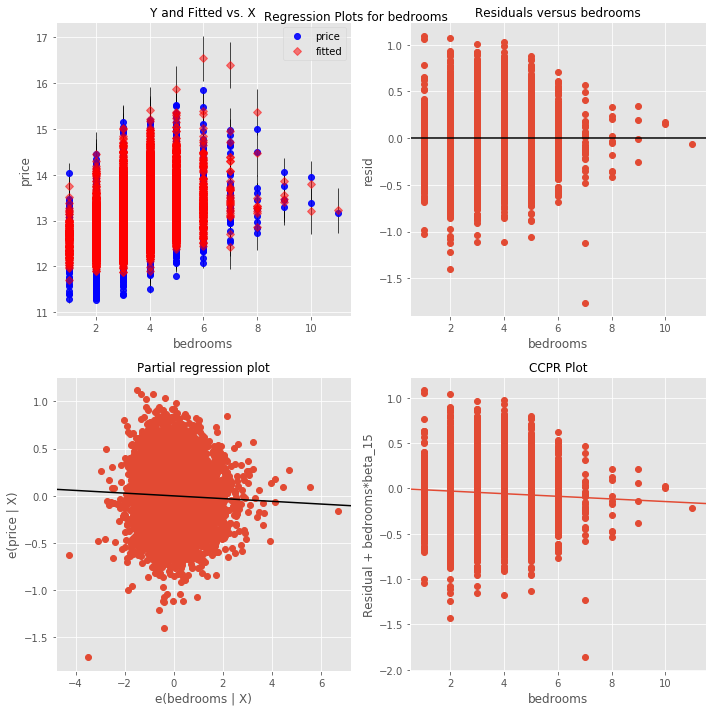

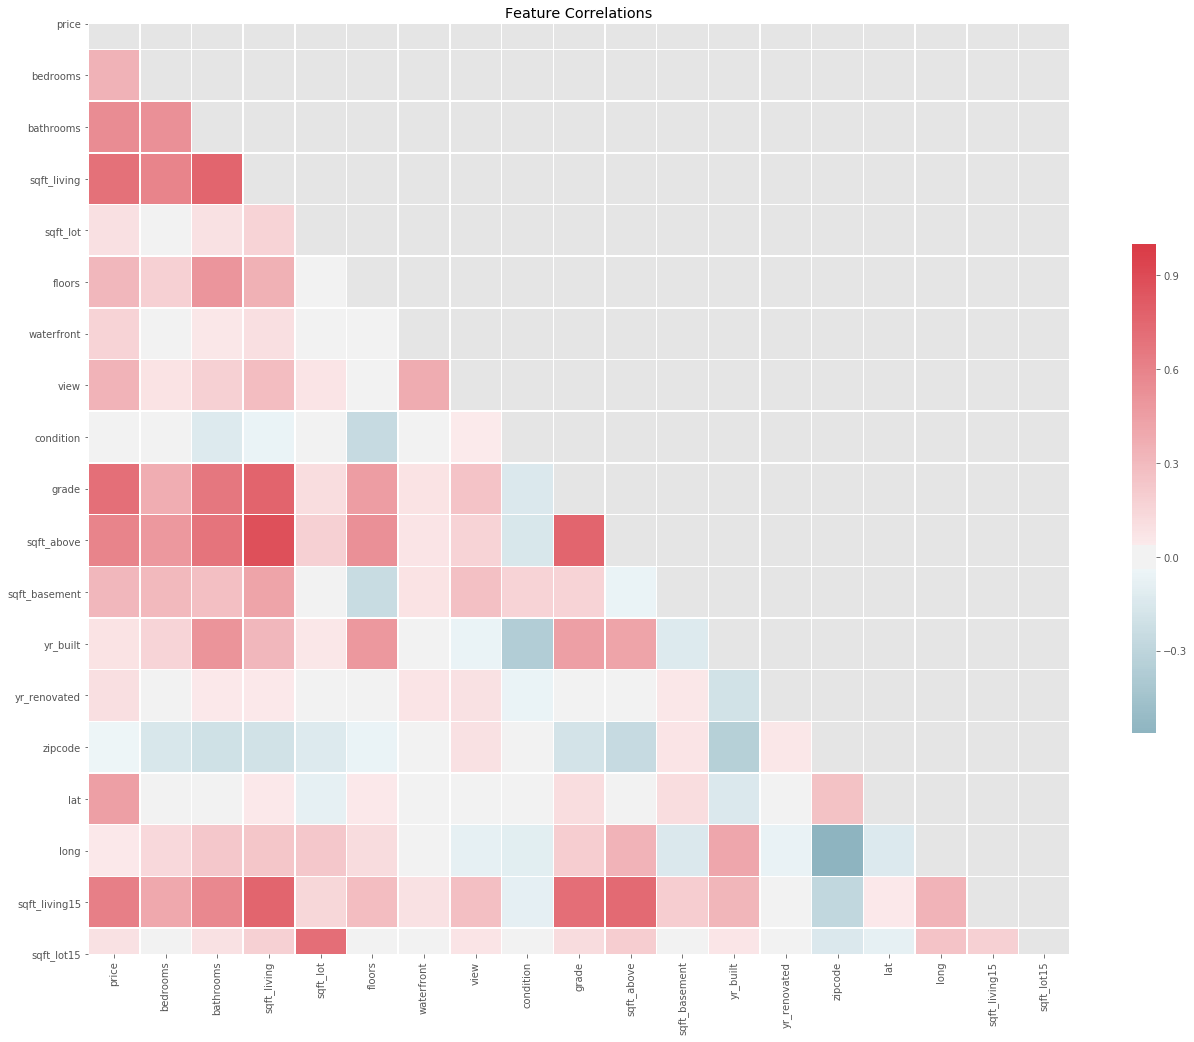

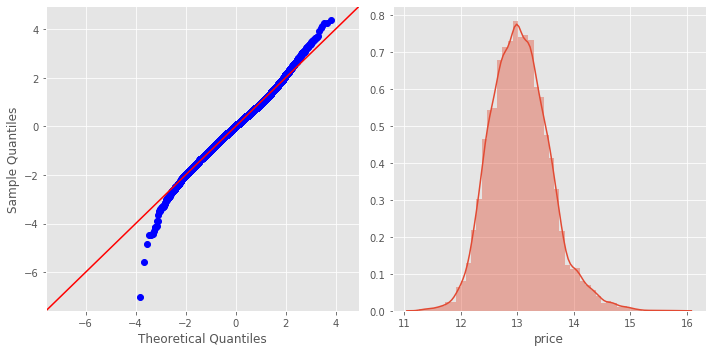

In [41]:
s_html = "<h1>Preliminary Linear Regression Model, v 2.0:</h1><ul>"
s_html += "<li><b>target</b>: {}</li>".format(target)
s_html += "<li><b>feature set</b>: {}</li>".format(kchd_cleaned_df.drop(target, axis=1).columns)
s_html += "<li><b>training/test split ratio</b>: ${}/{}$</li>".format(1-tr, tr)
s_html += "</ul>"
display(HTML(s_html))

kchd_cleaned_v2_df = kchd_cleaned_df.copy()
kchd_cleaned_v2_df[target] = kchd_cleaned_v2_df[target].map(lambda v: np.log(v))

(
    sel_features
    , their_pvals
    , X_train
    , X_test
    , y_train
    , y_test
    , train_mse
    , test_mse, model
) = lin_reg_model_from_auto_selected_features(kchd_cleaned_v2_df, target, tr=tr)

(model_fit_results, good_vif_features, bad_vif_features) = model_fit_summary(
    kchd_cleaned_v2_df
    , sel_features
    , their_pvals
    , model
    , tr
    , train_mse
    , test_mse
    , mv_r_sq_th
    , mv_mse_delta_th
    , mv_bad_vif_ratio_th
)

### Step 3: EDA through a Preliminary Linear Regression Model, v. 2.0: Analysis

In [42]:
display(HTML("$R^2 = {}$ has improved quite a bit!".format(round(model_fit_results.rsquared, 3)))) #bad_vif_features
display(HTML("<b>Perhaps more impressive is the drop in $\Delta MSE$ to approximately ${}$</b>!".format(int(abs(train_mse-test_mse)))))
display(HTML("Multicolinearity is still an issue with {}% of our features being colinear (according to VIF analysis).".format(round((len(bad_vif_features)/len(sel_features))*100,2))))

#### CONCLUSION:
Model Validation passed two out of three conditions.  Even though the model failed validation overall, we have VASTLY improved our model, just by *log-transforming* our target feature, **price**.

Nevertheless, **this is not a well-performing model**.

#### What can we do to improve its performance?
Before we consider dropping features as a means to deal with multicolinearity, let's check for abnormal distributions of our features and log-transform them as necessary.  We will also *min-max scale* our target as well as all of our *continuous* features.  We will eventually get to the point where we officially *categorize* our *categorical* variables.  Doing all of this will eventually bring the ranges of our target and features (*continuous* and *categorical*) to \[0, 1\], which should improve our model even more.

We continue by scaling, normalizing, transforming, and categorizing our features as necessary.

## Step 4: EDA: Feature Scaling, Normalization, Transformation, and Categorization

### Step 4: EDA: Categorical vs. Continuous Feature "Classification"

Drawing from our observations from our original search for outliers, we see that **there are features which are *apparently* categorical**.

Additionally, we can get a visual feel for which features are *categorical* vs *continuous* with scatter-plots of their values versus the *target feature*: **price**.

The idea is to **separate apparent *categorical* features from *continuous* features**.

We will attempt to simultaneously improve the performance of our model, as well as address multicolinearity, hopefully *without dropping too many features*.

The following additional function will help us to that end.

In [43]:
def scatter_plots(df, target=None):
    df_minus_target = df.drop(target, axis=1) if target is not None else df
    
    s_html = "<h3>Scatter Plots:</h3><ul>"
    if target is not None:
        s_html += "<li><b>target</b>: {}</li>".format(target)
    s_html += "<li><b>feature set</b>: {}</li>".format(df_minus_target.columns)
    s_html += "</ul>"
    display(HTML(s_html))
    
    r_w = 20
    r_h = 4

    c_n = 4 if len(df_minus_target.columns) >= 4 else len(df_minus_target.columns)
    r_n = len(df_minus_target.columns)/c_n
    r_n = int(r_n) + (1 if r_n % int(r_n) != 0 else 0)

    fig = plt.figure(figsize=(r_w, r_h*r_n))

    axes = fig.subplots(r_n, c_n)

    for index, feat in enumerate(df_minus_target):
        ax = fig.add_subplot(r_n, c_n, index+1)
        plt.scatter(df[feat], df[target], alpha=0.2)
        plt.xlabel(feat)
        plt.ylabel(target)

    flattened_axes = axes.flatten()
    for unused in range(len(flattened_axes)-1, index, -1):
        fig.delaxes(flattened_axes[unused])

    fig.tight_layout()
    plt.show();

In [44]:
def split_categorical(df, p_cat, target=None):
    df_minus_target = df.drop(target, axis=1) if target is not None else df
    
    s_html = "<h2>Split Categorical:</h2><ul>"
    s_html += "<li><b>p-cat threshold</b>: {}</li>".format(p_cat)
    s_html += "<li><b>feature set</b>: {}</li>".format(df_minus_target.columns)
    s_html += "</ul>"
    display(HTML(s_html))
    
    if target is not None:
        scatter_plots(df, target)
    
    cat_classification_df = classify_as_categorical(df_minus_target, p_cat, False)
    display(HTML("<b>Categorical Features ($p\\_cat \\ge {}$):</b><br><br>".format(p_cat)))
    print_df(cat_classification_df)
    
    categorical_features = list(cat_classification_df['name'])
    continuous_features = list(df_minus_target.columns)
    
    s_html = "<br>Based on the above, the following features are considered <b>continuous</b>:<br><ul>"
    for cont_feat in continuous_features:
        s_html += "<li><b>{}</b></li>".format(cont_feat)
    s_html += "</ul>"
    display(HTML(s_html))
    
    s_html = "The following features are <b>categorical</b> (based on $p\\_cat \\ge {}$):<br><ul>".format(p_cat)
    for cat_feat in categorical_features:
        continuous_features.remove(cat_feat)
        s_html += "<li><b>{}</b></li>".format(cat_feat)
    s_html += "</ul>"
    display(HTML(s_html))
        
    return (cat_classification_df, categorical_features, continuous_features)

In our search for outliers earlier, we leveraged the function to list the sets of unique values of each feature.  As an added benefit, that function produces a result that computes the likelihood that a given feature is or isn't categorical based on the ratio of unique values it has to the the total number of observations.  This will of course vary from data set to data set.  But, referring back to those results, a quick look shows that our *apparent* categorical features have a *p_cat* threshold value of $0.99$.  (Note that I have invented this metric for the context of this project - i.e. it's not an "official" statistical metric as far as I know.)

So let's use this information now to partition the set of features into *continuous* and *categorical* subsets, based on `p_cat` $= 0.99$ (and, thus, $p\_cat \ge 0.99$).

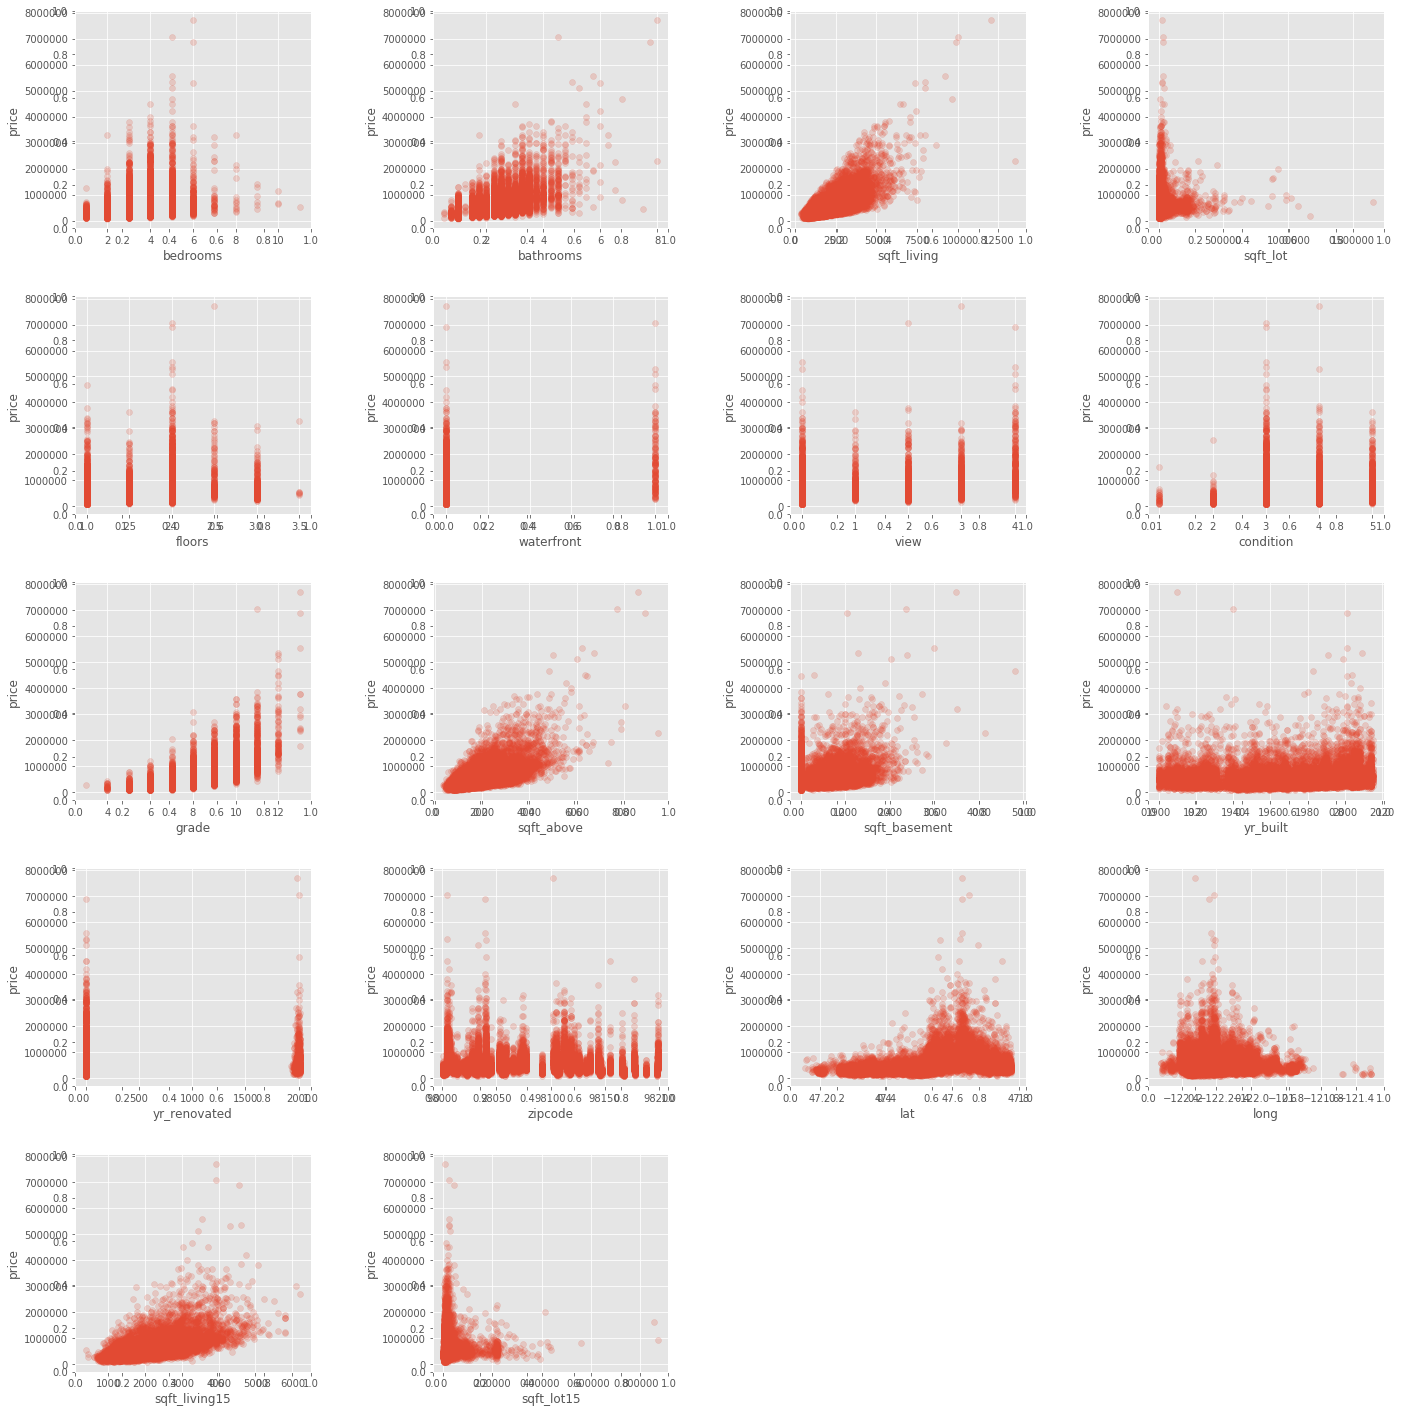

In [45]:
p_cat = 0.99

(
    kchd_cat_classification_df
    , categorical_features
    , continuous_features
) = split_categorical(kchd_cleaned_df, p_cat, target)

### Step 4: EDA: Categorical vs. Continuous Feature "Classification"

Now that we have clearly identified and separated *continuous* vs. *categorical* features, we can take a look the ranges and distributions of our *continuous* features in order to determine whether they must be *tranformed* and/or *scaled*.

In [46]:
kchd_cleaned_df[continuous_features].describe().loc[['min', 'max']]

sqft_living   sqft_lot  sqft_above  sqft_basement      lat     long  \
min        370.0      520.0       370.0            0.0  47.1559 -122.519   
max      13540.0  1651359.0      9410.0         4820.0  47.7776 -121.315   

     sqft_living15  sqft_lot15  
min          399.0       651.0  
max         6210.0    871200.0

Based on the ranges \[*min*, *max*\] of continuous features, it is clear that they need to be at least *scaled*.  

Let's have a look at the distributions of each for some insight into whether or not we should first *log-transform* a given feature.

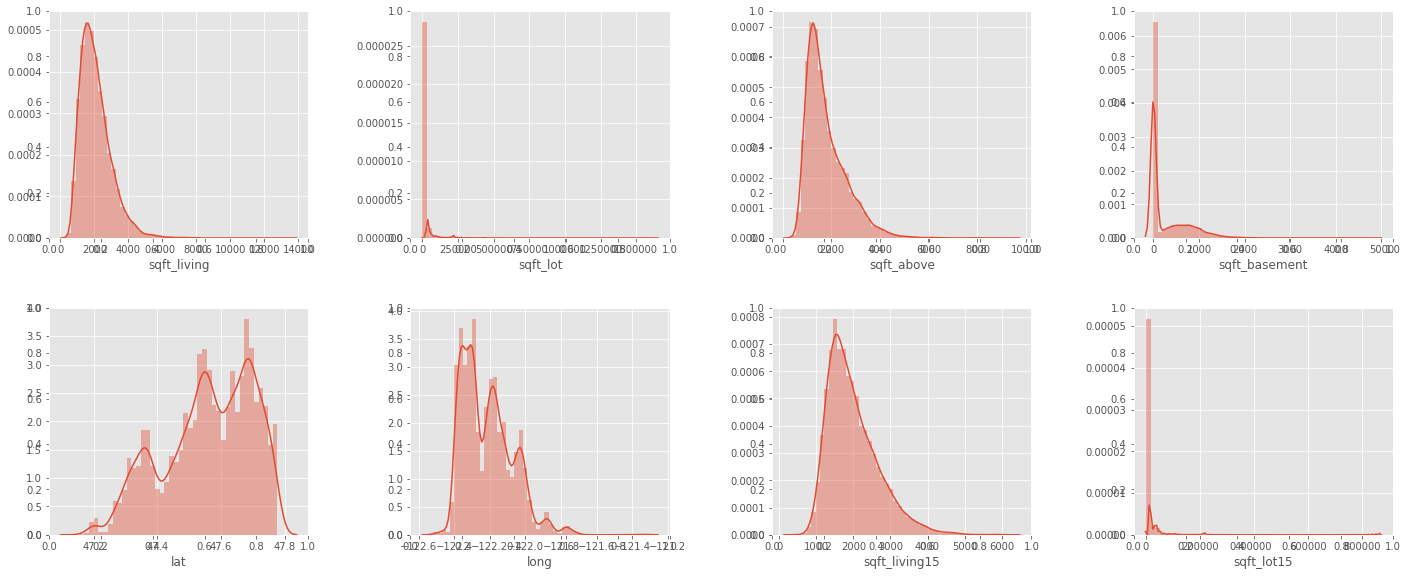

In [47]:
histograms(kchd_cleaned_df, continuous_features);

s_html = "From the distributions above, we see that <b>all <i>continuous</i> features need to be scaled</b> but <b>they must <i>first</i> be log-transformed <i>when possible</i></b> in order to push their distributions more toward normal:<br><br><ul>"
for cont_feat in continuous_features:
    s_html += "<li><b>{}</b></li>".format(cont_feat)
s_html += "</ul>"
display(HTML(s_html))

### Step 4: EDA: Continuous Feature Transformation Preprocessing

Prior to log-transforming these features, we must pay careful attention to features with values $\le 0$ and either adopt a replacement heuristic for these values to make log-transformation possible OR we can opt to simply not transform such a feature.

Note that **long** contains negative values and also that **lat** and **long** are really components of an *ordered pair*.  Thus, if we *transform* or *scale* one (but not *translate*), we must do the same operation to the other.  Without doing anything to address negative values, we will not be able to use *log-transformation* on **long** (and subsequently **lat**).  

However, **we can perform *log-transformation* on *long* if we first *translate (shift to the right)* its *lower-bound* to $0$ by adding $-1 \cdot min(long)$ to the all values in the set**.  Note that we must follow up with a *hack* in order to perform *log-transformation* on values==$0$: **we will subsequently replace all instances of $0.0$ with $1$ *in order to make log-transformation possible* - note that $log(1)=0$**.

To summarize:
1. For **lat** and **long**:
    1. first *translate* the *range* of **long** to: $range_{transformed}(long)=[min(range_0(long))-min(range_0(long)), max(range_0(long))-min(range_0(long))]$; that is, $\forall v \in range_0(long): v_{transformed} = v-min(range_0(long))$
    2. since they constitute an *ordered pair*:
        1. *translation* of a componenent of the ordered pair - i.e. **long** - independently from the other is okay
        2. but  *transformation/scaling* operations must be done to both
2. For all continuous features (including **lat** and **long**), we will:
    1. replace all instances of 0.0 with 1 *in order to make log-transformation possible*, since $log(1)=0$
    2. do *min/max scaling*.
    
The following code preprocesses and prepares **lat** and **long** for *log-transformation*.

### Preprocess lat and long for *log-transformation*: add $-1 \cdot min(long)$ to the all values in the set, and then replace all instances of $0.0$ with $1$ 

In [48]:
#prep for log-tranformation
lt_cont_features = continuous_features.copy()
b_force_log_transform = True
if b_force_log_transform:
    kchd_cleaned_df['long'] = kchd_cleaned_df['long']-kchd_cleaned_df['long'].min() # translation to [0, max(range(long)) - min(range(long))]
    for lt_cont_feature in lt_cont_features:
        clean_offending_values(
            kchd_cleaned_df
            , numeric_replacement_rules=
                {
                    lt_cont_feature: [(0.0, 1)]
                }
            , friendly_name_of_df="King County House Sales DF"
        )
df_has_neg_or_0 = kchd_cleaned_df[continuous_features] <= 0.0
for ltfeat in continuous_features:
    if df_has_neg_or_0[ltfeat].sum() > 0:
        lt_cont_features.remove(ltfeat)
if 'lat' in lt_cont_features and 'long' not in lt_cont_features:
    lt_cont_features.remove('lat')
if 'long' in lt_cont_features and 'lat' not in lt_cont_features:
    lt_cont_features.remove('long')

#min-max scaling    
mm_cont_features = continuous_features
print("\nThe following continuous features will be log-transformed:\n{}".format(lt_cont_features))
print("\nThe following continuous features will be min-max scaled:\n{}".format(mm_cont_features))

*** CLEANING VALUES of King County House Sales DF: BEGIN ***

Rules for 'sqft_living' column value replacement are: [(0.0, 1)]
Looking for rows with 'sqft_living' values [0.0] ...
There are no rows that contain values of 'sqft_living' in [0.0]!
*** CLEANING VALUES of King County House Sales DF: END ***
*** CLEANING VALUES of King County House Sales DF: BEGIN ***

Rules for 'sqft_lot' column value replacement are: [(0.0, 1)]
Looking for rows with 'sqft_lot' values [0.0] ...
There are no rows that contain values of 'sqft_lot' in [0.0]!
*** CLEANING VALUES of King County House Sales DF: END ***
*** CLEANING VALUES of King County House Sales DF: BEGIN ***

Rules for 'sqft_above' column value replacement are: [(0.0, 1)]
Looking for rows with 'sqft_above' values [0.0] ...
There are no rows that contain values of 'sqft_above' in [0.0]!
*** CLEANING VALUES of King County House Sales DF: END ***
*** CLEANING VALUES of King County House Sales DF: BEGIN ***

Rules for 'sqft_basement' column value

Both **lat** and **long** are now ready for *log-transformation*.

The code for *scaling*, *normalization*, and *log-transformation* is below.

### Scaling, Normalization, and Log-transformation Functions

In [49]:
def log_transform(df, target_features, inplace=False):
    if not inplace:
        df = df.copy(deep=True)
    for feat in target_features:
        df[feat] = df[feat].map(lambda v: np.log(v))
    return df

# Min-max scaling: this will not be particularly useful to us in this case since this way of scaling brings values between 0 and 1
def min_max_scaling(df, target_features, inplace=False):
    if not inplace:
        df = df.copy(deep=True)
    for feat in target_features:
        min_feat = df[feat].min()
        max_feat = df[feat].max()
        df[feat] = df[feat].map(lambda x: (x-min_feat)/(max_feat-min_feat))
    return df

# standardization does not make data  moremore  normal, it will just change the mean and the standard error!
def standardization(df, target_features, inplace=False):
    if not inplace:
        df = df.copy(deep=True)
    for feat in target_features:
        mean_feat = df[feat].mean()
        sqr_var_feat = np.sqrt(np.var(df[feat]))
        df[feat] = df[feat].map(lambda x: (x-mean_feat)/sqr_var_feat)
    return df

# The distribution will have values between -1 and 1, and a mean of 0.
def mean_normalization(df, target_features, inplace=False):
    if not inplace:
        df = df.copy(deep=True)
    for feat in target_features:
        mean_feat = df[feat].mean()
        min_feat = df[feat].min()
        max_feat = df[feat].max()
        df[feat] = df[feat].map(lambda x: (x-mean_feat)/(max_feat-min_feat))
    return df    

# Unit vector transformation
def unit_vector_normalization(df, target_features, inplace=False):
    if not inplace:
        df = df.copy(deep=True)
    for feat in target_features:
        norm_feat = np.sqrt((df[feat]**2).sum())
        df[feat] = df[feat].map(lambda x: x/norm_feat)
    return df 

We can now not only perform log-transformation on **lat** and **long**, but we can also perform min-max scaling on all of our continuous features (including **lat** and **long**).

### Step 4: EDA: Perform *log-transformation* on lat and long and *min-max scaling* on all continuous features

In [50]:
kchd_transformed_and_scaled_df = kchd_cleaned_df.copy()

# log-transformation
kchd_transformed_and_scaled_df = log_transform(kchd_transformed_and_scaled_df, lt_cont_features)

# min-max scaling
kchd_transformed_and_scaled_df = min_max_scaling(kchd_transformed_and_scaled_df, mm_cont_features)

**Transforming and scaling our *continuous* features yields the following ranges**:

In [51]:
kchd_transformed_and_scaled_df[continuous_features].describe().loc[['min', 'max']]

sqft_living  sqft_lot  sqft_above  sqft_basement  lat  long  \
min          0.0       0.0         0.0            0.0  0.0   0.0   
max          1.0       1.0         1.0            1.0  1.0   1.0   

     sqft_living15  sqft_lot15  
min            0.0         0.0  
max            1.0         1.0

### Step 4: EDA: Perform *log-transformation* and *min-max scaling* on target, price

Don't forget that **our target feature (*price*) should be log-transformed** (and scaled), as well, *based on the results from our Preliminary Linear Regression Model, v 2.0*. 

In [52]:
kchd_transformed_and_scaled_df[target].describe().loc[['min', 'max']]

min      78000.0
max    7700000.0
Name: price, dtype: float64

In [53]:
kchd_transformed_and_scaled_df = min_max_scaling(
    log_transform(kchd_transformed_and_scaled_df, [target])
    , [target]
)
kchd_transformed_and_scaled_df[target].describe().loc[['min', 'max']]

min    0.0
max    1.0
Name: price, dtype: float64

### Step 4: EDA: Preliminary Linear Regression Model, v. 3.0, after scaling/transforming continuous features (and target)

Now let's have a look at our scaled and transformed data.

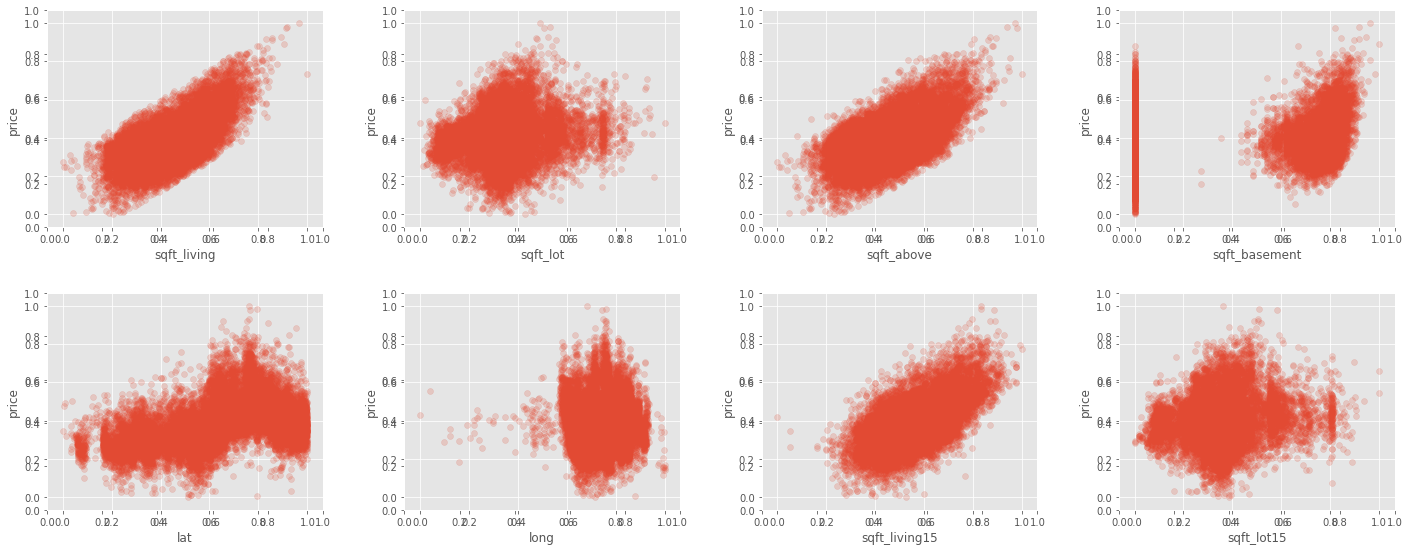

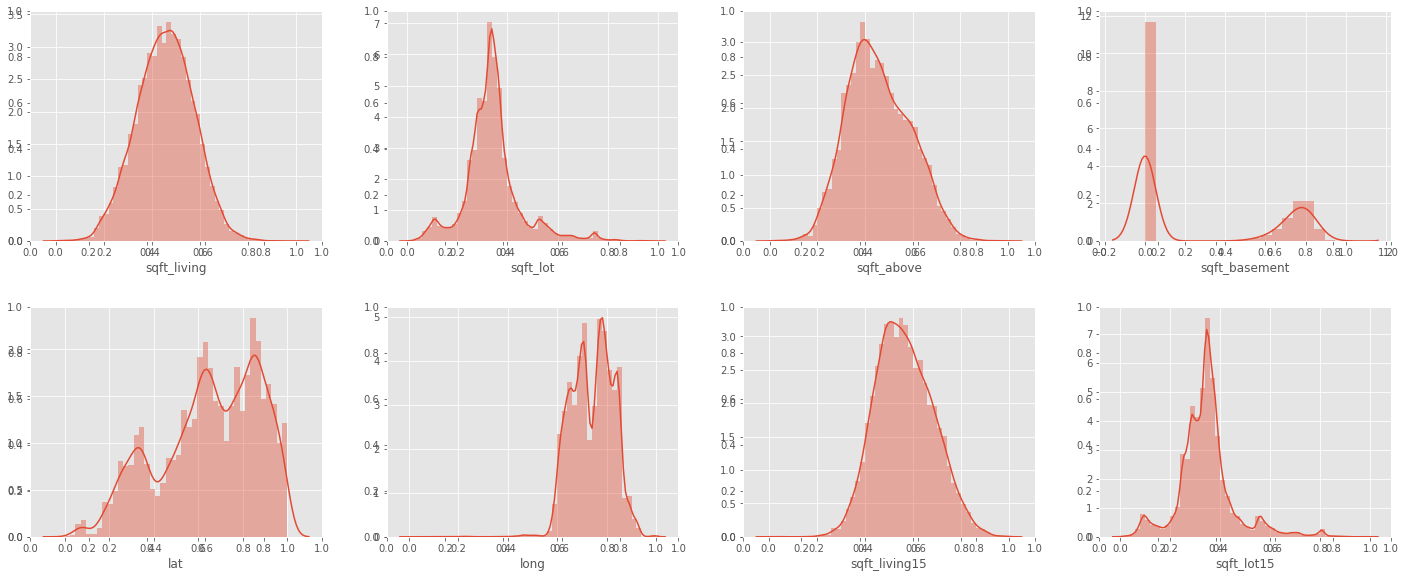

In [54]:
scatter_plots(
    pd.concat(
        [kchd_transformed_and_scaled_df[target], kchd_transformed_and_scaled_df[continuous_features]]
        , axis=1
        , join='inner'
    )
    , target
)
histograms(kchd_transformed_and_scaled_df, continuous_features);

In [55]:
(cv_sel_cont_features, neg_mse) = cv_selection(
    kchd_transformed_and_scaled_df.drop(target, axis=1)[continuous_features]
    , kchd_transformed_and_scaled_df[[target]]
    , tr=tr
    , folds=10
    , scoring_method="neg_mean_squared_error"
    , fn_better_score=lambda neg_mse, best_neg_mse: abs(neg_mse) < abs(best_neg_mse)
)

new best neg_mean_squared_error score: 0.007163637952252564, from feature-set combo: ['sqft_living']


new best neg_mean_squared_error score: 0.007065793117677431, from feature-set combo: ['sqft_living', 'sqft_lot']
new best neg_mean_squared_error score: 0.004808061244411213, from feature-set combo: ['sqft_living', 'lat']


new best neg_mean_squared_error score: 0.004805999107110641, from feature-set combo: ['sqft_living', 'sqft_lot', 'lat']
new best neg_mean_squared_error score: 0.004776878830277335, from feature-set combo: ['sqft_living', 'sqft_above', 'lat']
new best neg_mean_squared_error score: 0.004723211111781487, from feature-set combo: ['sqft_living', 'lat', 'long']
new best neg_mean_squared_error score: 0.0045372155254775545, from feature-set combo: ['sqft_living', 'lat', 'sqft_living15']


new best neg_mean_squared_error score: 0.00451175205115288, from feature-set combo: ['sqft_living', 'sqft_lot', 'lat', 'sqft_living15']
new best neg_mean_squared_error score: 0.00434524990378496, from feature-set combo: ['sqft_living', 'lat', 'long', 'sqft_living15']


new best neg_mean_squared_error score: 0.004341779957527432, from feature-set combo: ['sqft_living', 'sqft_lot', 'lat', 'long', 'sqft_living15']
new best neg_mean_squared_error score: 0.0043134046517058, from feature-set combo: ['sqft_living', 'sqft_above', 'lat', 'long', 'sqft_living15']
new best neg_mean_squared_error score: 0.004276054547522795, from feature-set combo: ['sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15']


new best neg_mean_squared_error score: 0.004259778840790453, from feature-set combo: ['sqft_living', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15']


new best neg_mean_squared_error score: 0.0042592068129604695, from feature-set combo: ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15']
new best neg_mean_squared_error score: 0.004256350053237782, from feature-set combo: ['sqft_living', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


new best neg_mean_squared_error score: 0.004253650214208042, from feature-set combo: ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

cv_selected best neg_mean_squared_error = 0.004253650214208042

cv_selected best feature-set combo:
['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

starting feature-set:
['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


After *log-transforming* our *continuous* features (*as well as our target feature*), we see that their distributions are more normal, with the exception of **sqft_basement**, **lat**, and **long**.  

In terms of transformation, those features (**sqft_basement**, **lat**, and **long**) are about as good as they're going to get. 

Let's build a new linear regression model and see how it performs.

Note that we have not dealt with our *categorical* features yet.  This means that **our target, *price*, and our *contnuous* features will be in the range \[0, 1\] but our *categorical* features will not be**.

Nevertheless, **we should still expect the performance of a new linear regression based on this newly scaled/transformed data to perform better than the last one**, *Preliminary Linear Regression Model, v. 2.0*.

Computing most statstically significant features...
Add  sqft_living15                  with p-value 0.0
Add  lat                            with p-value 0.0
Add  sqft_living                    with p-value 0.0


/Users/stevencontreras/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Add  long                           with p-value 1.44284e-203
Add  sqft_above                     with p-value 1.1253e-35
Add  sqft_basement                  with p-value 1.40256e-60
Add  sqft_lot15                     with p-value 6.02637e-07
Add  sqft_lot                       with p-value 2.12365e-05


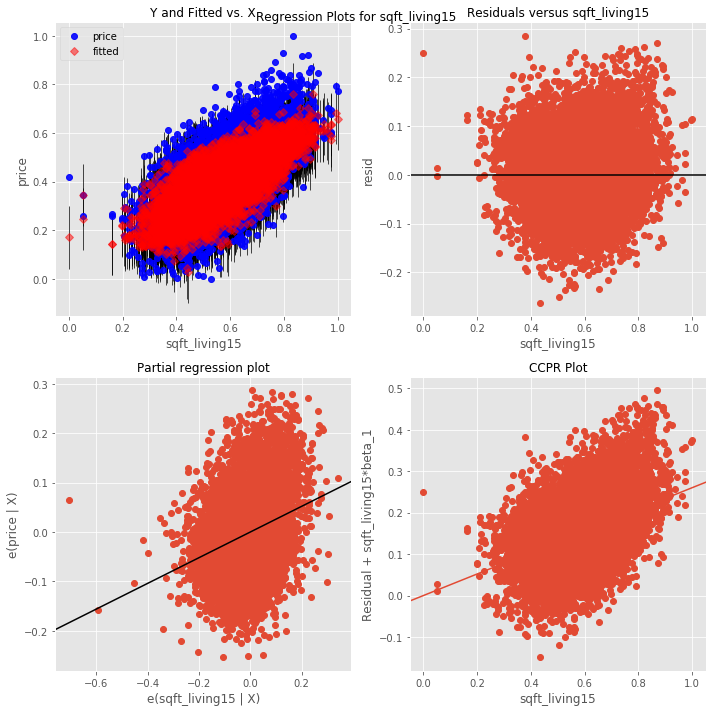

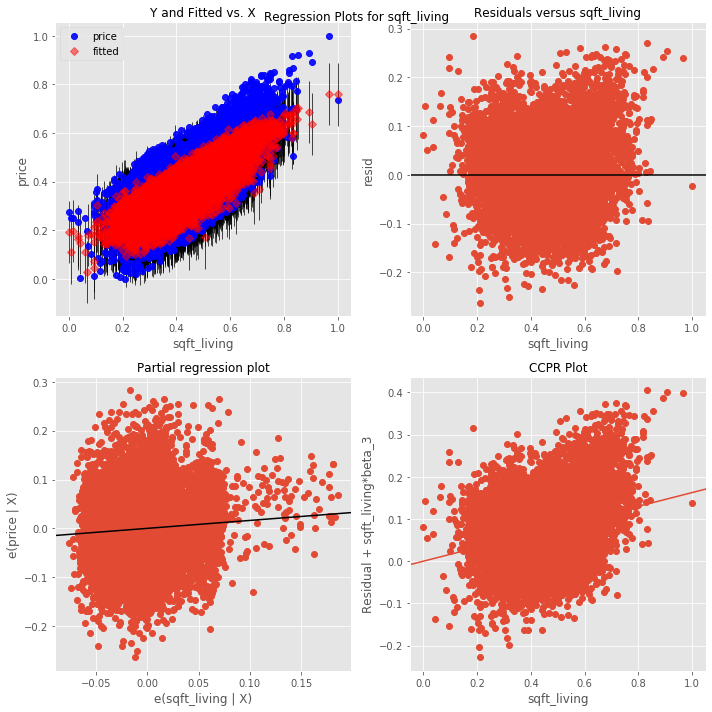

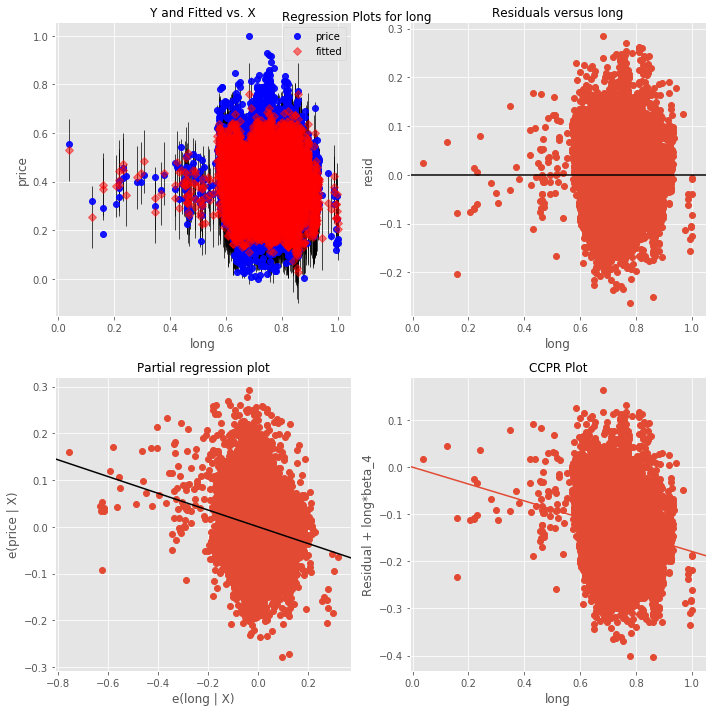

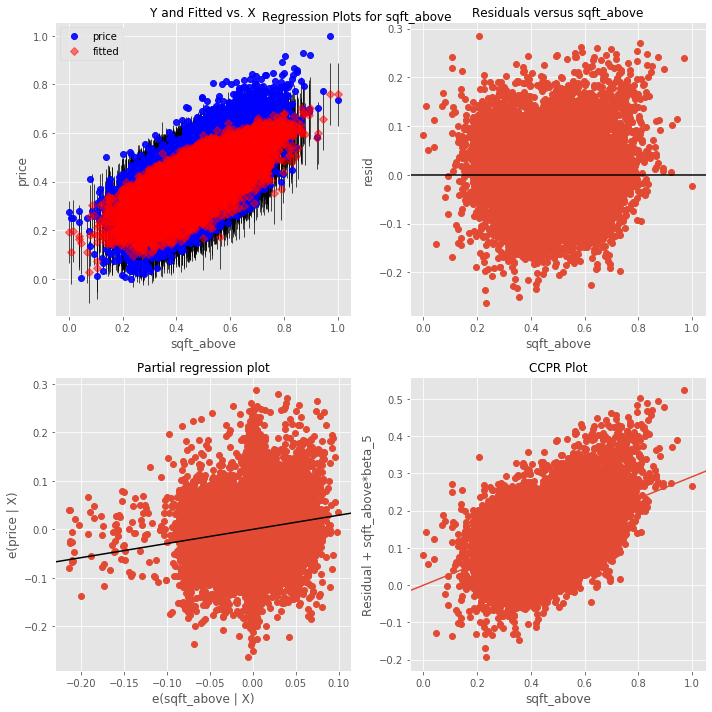

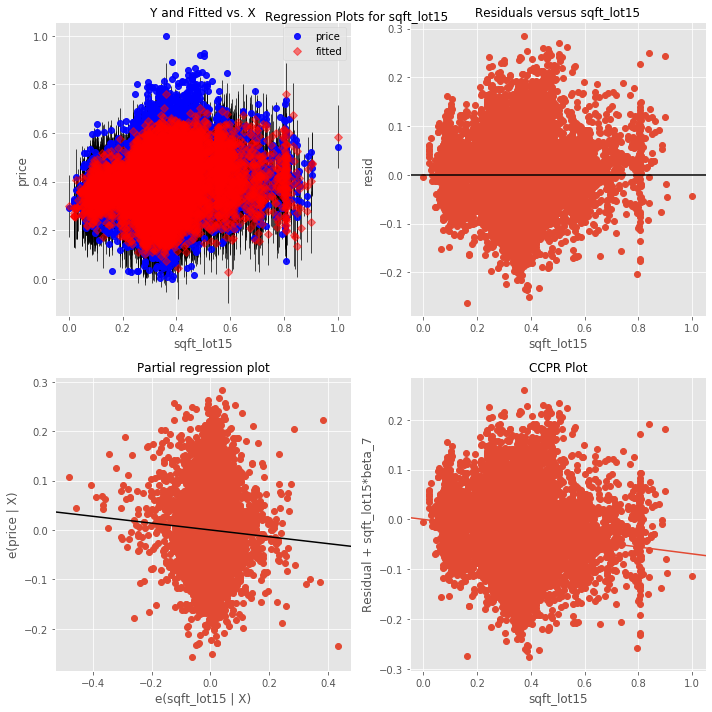

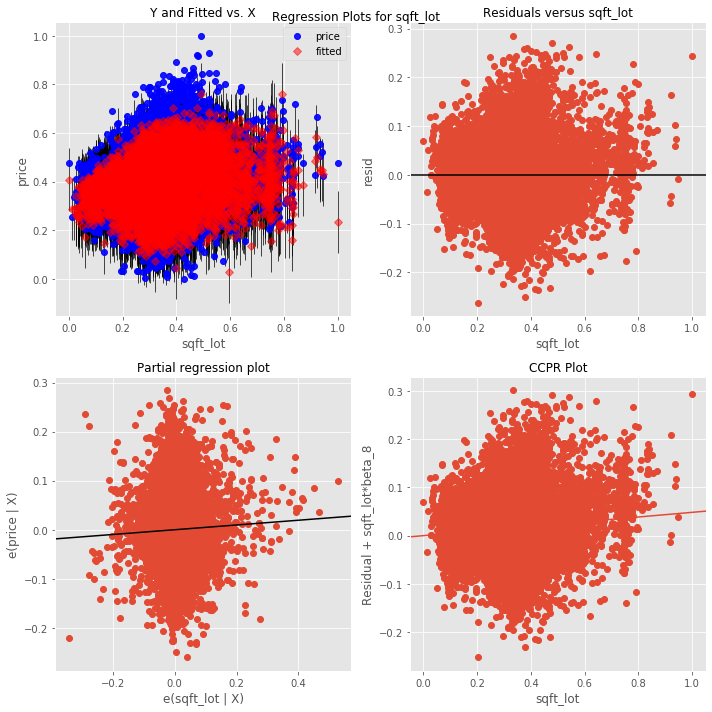

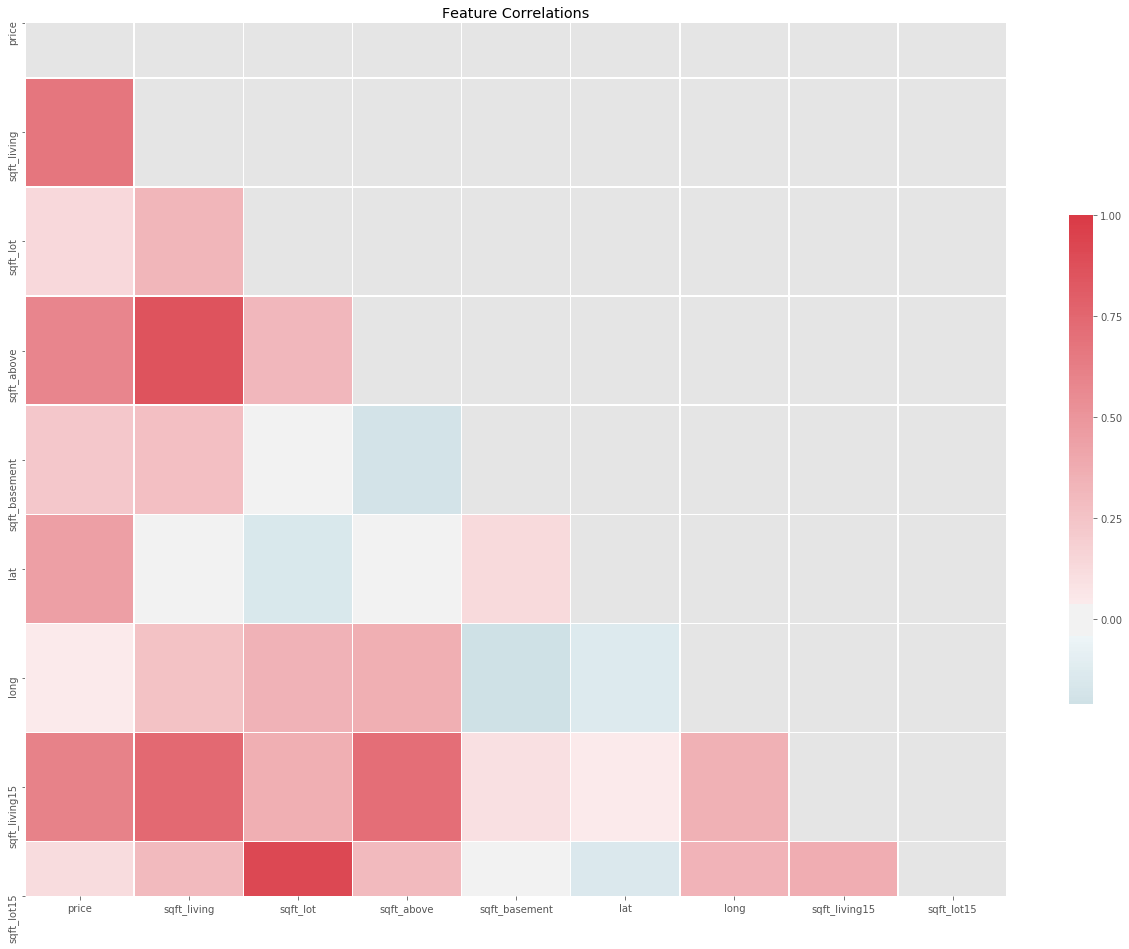

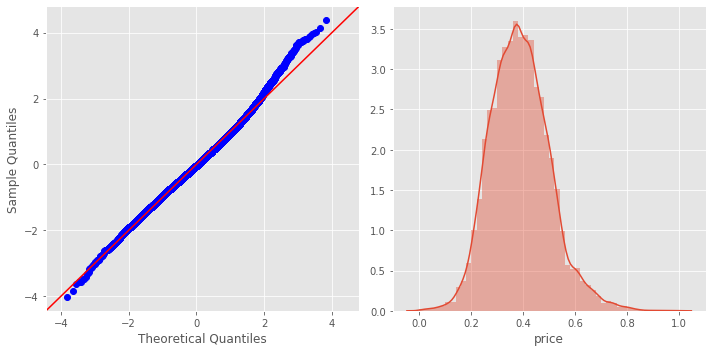

In [56]:
# update! restrict to selected continuous features from cross-validation

s_html = "<h1>Preliminary Linear Regression Model, v. 3.0, after scaling/transforming continuous features:</h1><ul>"
s_html += "<li><b>target</b>: {}</li>".format(target)
s_html += "<li><b>feature set</b>: {}</li>".format(kchd_cleaned_df.drop(target, axis=1)[cv_sel_cont_features].columns)
s_html += "<li><b>training/test split ratio</b>: ${}/{}$</li>".format(1-tr, tr)
s_html += "</ul>"
display(HTML(s_html))

kchd_transformed_and_scaled_cont_with_target_df = pd.concat(
    [
        kchd_transformed_and_scaled_df[[target]]
        , kchd_transformed_and_scaled_df[cv_sel_cont_features]
    ]
    , axis=1
    , join='inner'
)

prev_sel_features = sel_features
(
    sel_features
    , their_pvals
    , X_train
    , X_test
    , y_train
    , y_test
    , train_mse
    , test_mse, model
) = lin_reg_model_from_auto_selected_features(kchd_transformed_and_scaled_cont_with_target_df, target, tr=tr)

prev_good_vif_features = good_vif_features
prev_bad_vif_features = bad_vif_features
(model_fit_results, good_vif_features, bad_vif_features) = model_fit_summary(
    kchd_transformed_and_scaled_cont_with_target_df
    , sel_features
    , their_pvals
    , model
    , tr
    , train_mse
    , test_mse
    , mv_r_sq_th
    , mv_mse_delta_th
    , mv_bad_vif_ratio_th
)

### Step 4: EDA: Preliminary Linear Regression Model, v. 3.0, after scaling/transforming continuous features (and target): Analysis

In [57]:
display(HTML("Look at that QQ plot! VERY NICE!  We see that our $R^2 = {}$ has indeed increased, as expected but not by much.".format(round(model_fit_results.rsquared, 3))))
display(HTML("Again, take a look at the difference in MSEs between our training and test partitions - note that we split based on a ${}$/${}$ ratio.".format(1-tr, tr)))
display(HTML("<b>The difference between MSE of our train/test partitions is still approximately ${}$, as expected.</b>".format(int(abs(train_mse-test_mse)))))
display(HTML("<b>We see, in fact, that the bad VIF ratio - that is, measure of multicolinearity - has actually increased from {}% to {}%!</b>".format(
            round((len(prev_bad_vif_features)/len(prev_sel_features))*100, 2)
            , round((len(bad_vif_features)/len(sel_features))*100, 2)
        )
    )
)

**Multicolinearity is still a problem and has, in fact, gotten worse**.

This is now likely due to the fact that, at this point, as previously stated, our target, **price**, and our *contnuous* features will be in the range \[0, 1\] but our *categorical* features will not be.

#### What can we do to improve its performance?
Before we consider dropping features as a means to deal with multicolinearity, let's see what effect *binning* our *categorical* features has on, not only multiconlinearity, but of the performance of our linear regression model in general.

### Step 4: EDA: Categorization/Binning Categorical Features

Now, before we get to officially *categorizing* our categorical features, we can refer to their ranges and sizes of their value sets in order to get some guidance on how we should "bin" them.

For small-sized value sets, we can partition the categories (value set) based on the number of values.

But at some point this will become too taxing since each bin will add another column to the data set after categorization.

So, for larger-sized value sets, for example if the size of the value set is larger than 10, we might need to get creative with our binning strategy.

Let's have a look at the categorical value set ranges once more.

In [58]:
kchd_cat_classification_df = classify_as_categorical(kchd_transformed_and_scaled_df.drop(target, axis=1), p_cat, False)

display(HTML("<b>Categorical Feature Ranges:</b><br><br>"))
print_df(kchd_cat_classification_df[['name', 'dtype', 'unique_vals']].set_index('name'))
print_df(kchd_transformed_and_scaled_df[categorical_features].describe().loc[['min', 'max']])

From the above, we note that:
- **bathrooms** has a strange range of values, \[0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.5, 7.75, 8.0\], but we can handle this by appropriate binning into:
    - $16$ bins: [0, 0.5), [0.5, 1), [1, 1.5), [1.5, 2), [2, 2.5), [2.5, 3), [3, 3.5), [3.5, 4), [4, 4.5), [4.5, 5), [5, 5.5), [5.5, 6), [6, 6.5), [6.5, 7), [7, 7.5), [7.5, 8)
    - we bin in increments of 0.5 since, according to the [feature definitions](https://www.slideshare.net/PawanShivhare1/predicting-king-county-house-prices) in this data set, **bathrooms** is "Number of bathrooms, where .5 accounts for a room with a toilet but not shower"
    - we could have addressed the values with 0.25 and 0.75 components in the cleaning phase via a *rounding* replacement heuristic but then we would have had to decide whether either should round up or down, to the nearest 0.5 increment; *binning* effectively accomplishes the same and with less work (since we have to do binning anyway); additionally, by binning in increments of 0.5, we adhere close to the definition of **bathrooms** listed in the [feature definitions](https://www.slideshare.net/PawanShivhare1/predicting-king-county-house-prices); **we are interested in observing the impact that adding additional bathrooms *with and without a shower* has on potential sale price**
- **yr_built**, **yr_renovated**, and **zipcode** have a large value set; so we will need to devise an appropriate binning scheme for those in order to reduce the number of bins to a manageable count
    - for **yr_built** and **yr_renovated**, we simply bin in increments of $10$ years
    - **zipcode** is a bit trickier since a the value of a home can vary drastically from one zip code to the next;  additionally, intuitively we might think there is some relationship between **zipcode** and $(lat, lon)$; so we are left with some choices:
        - retain the **zipcode** feature and accept that we might lose some fidelity in binning multiple zipcodes together in each bin,
        - drop **zipcode** since $(lat, lon)$ likely correlates to it anyway and with greater fidelity, or
        - leave it as is and use the default categorical binning semantic below - for this iteration, this is the option we will choose
- for all other categorical features from the list above, since the count of categorical values is low, we simply create partitions according to the *cardinality* of the set of categorical values of each - this is our *default* binning scheme

The following functions are used for the binning strategies above.

In [59]:
def partition(df, feature, basis=None):
    if basis is None:
        basis = list(df[feature].unique())
    basis.append(min(basis)-1)
    basis = sorted(basis)
    binned_feature = pd.cut(df[feature], basis)
    feature_bins = binned_feature.cat.categories.values
    binned_feature = binned_feature.cat.as_unordered()
    #print("{} categorical bins are:\n{}".format(feature, feature_bins))
    return (binned_feature, feature_bins)

def categorize_feature(df, feature, basis=None):
    binned_feature, feature_bins = partition(df, feature, basis)
    feature_dummy = pd.get_dummies(binned_feature, prefix=feature, drop_first=True)
    return (pd.concat([df.drop([feature], axis=1), feature_dummy], axis=1), feature_bins)

In [60]:
def categorize(df, default_handling_categoricals_list, special_handling_categoricals_map):
    categorized_df = df
    
    # categorize features with "special-handling" bins
    feature_bins_list = []
    for feat, feat_bin_basis in special_handling_categoricals_map.items():
        categorized_df, feat_bins = categorize_feature(
            categorized_df
            , feat
            , feat_bin_basis
        )
        feature_bins_list.append((feat, feat_bins))
    if len(feature_bins_list) > 0:
        s_html = "Binning of \"special-handling\" categorical features:<br><ul>"
        for feat, feat_bins in feature_bins_list:
            s_html += "<li><b>{}</b>: {}</li>".format(feat, feat_bins)
        s_html += "</ul>"
        display(HTML(s_html))

    # categorize features with default binning semantic
    feature_bins_list = []
    for feat in default_handling_categoricals_list:
        categorized_df, feat_bins = categorize_feature(
            categorized_df
            , feat
        )
        feature_bins_list.append((feat, feat_bins))
    if len(feature_bins_list) > 0:
        s_html = "Binning of remaining categorical features:<br><ul>"
        for feat, feat_bins in feature_bins_list:
            s_html += "<li><b>{}</b>: {}</li>".format(feat, feat_bins)
        s_html += "</ul>"
        display(HTML(s_html))
    
    return categorized_df

In [61]:
def encode_col_names(df):
    return df.rename(columns=lambda x: x.replace(" ", "").replace(",", "__").replace(".", "_").replace("(", "e").replace("]", "i"))

We are now prepared to "bin" our categorical features.  But instead of doing it manually, I have written the function below to capture this process programatically since it encapsulates all of the steps required to run full linear regression experiments from here on out.

The following function encapsulates the full linear regression experiment process.

In [62]:
def run_full_regression_experiment(transformed_and_scaled_df, target, to_drop, tr, mv_r_sq_th, mv_mse_delta_th, mv_bad_vif_ratio_th, p_cat, fn_init_bin_bases, exp_title=None):
    s_html = "<h1>" + (exp_title if exp_title is not None else "Full Linear Regression Experiment") + ":</h1><ul>"
    s_html += "<li><b>target</b>: {}</li>".format(target)
    s_html += "<li><b>feature set</b>: {}</li>".format(transformed_and_scaled_df.drop(target, axis=1).columns)
    if to_drop is not None and len(to_drop) > 0:
        s_html += "<li><b>feature exclusion set</b> (basis for experiment): {}</li>".format(to_drop)
    s_html += "<li><b>training/test split ratio</b>: ${}/{}$</li>".format(1-tr, tr)
    s_html += "</ul>"
    display(HTML(s_html))
    
    transformed_and_scaled_minus_todrop_df = transformed_and_scaled_df.drop(to_drop, axis=1)
    
    (
        kchd_cat_classification_df
        , categorical_features
        , continuous_features
    ) = split_categorical(transformed_and_scaled_minus_todrop_df, p_cat, target)
    
    (
        default_handling_categoricals_list
        , special_handling_categoricals_map
    ) = fn_init_bin_bases(transformed_and_scaled_minus_todrop_df, categorical_features)
    
    transformed_and_scaled_and_categorized_df = categorize(
        transformed_and_scaled_minus_todrop_df
        , default_handling_categoricals_list
        , special_handling_categoricals_map
    )
    transformed_and_scaled_and_categorized_df = encode_col_names(transformed_and_scaled_and_categorized_df)
    
    (
        sel_features
        , their_pvals
        , X_train
        , X_test
        , y_train
        , y_test
        , train_mse
        , test_mse
        , model
    ) = lin_reg_model_from_auto_selected_features(transformed_and_scaled_and_categorized_df, target, tr=tr)

    (model_fit_results, good_vif_features, bad_vif_features) = model_fit_summary(
        transformed_and_scaled_and_categorized_df
        , sel_features
        , their_pvals
        , model
        , tr
        , train_mse
        , test_mse
        , mv_r_sq_th
        , mv_mse_delta_th
        , mv_bad_vif_ratio_th
    )
    
    return (sel_features, model_fit_results, train_mse, test_mse, good_vif_features, bad_vif_features)

### Step 4: EDA: Toward Full Regression v. 1.0: transformed, scaled, and categorized features
We're almost ready to perform our first full regression on our transformed, scaled and categorized data.

Note that the above process rebuilds the bins with each run (but saved in an output data frame).  This was done intentionally in order for the entire process to be encapsulated within a single function call, to facilitate running new and different linear regression experiments.

But, the `run_full_regression_experiment` function requires the caller to pass in a defined "callback" function argument (`fn_init_bin_bases`) which houses the logic for building any "special-handling" binning semantics.

For instance, both **yr_built** and **yr_renovated** have binning bases too large to rely on default binning semantics (one bin for each value).  Additionally, **yr_renovated** uses value $0$ to indicate that a home has not been renovated.  But the next value in that category is $1934$.  So we can't simply create a basis for its bins equal to `range(min(yr_renovated), max(yr_renovated))` since this would result in 1933 additional columns in the corresponding data frame after binning.  Not only that but none of them would be used!  ... which would result in a monumental, unnecessary hit to memory (and elapsed time) used to run the regression!  Hence, **yr_renovated** truly does require "special handling".  And this is the purpose of the `fn_init_bin_bases` function.


### Step 4: EDA: Explanation of special-handling binning logic for **yr_renovated**
The logic is actually quite simple.  We simply first remove the minimum value (0) and then partition based on some predifined desirable interval size.  I have set my interval size to $10$ (years).  This results in roughly 13 bins or so.  Very nice!  It also makes sense since it probably wouldn't make much difference (sale-price wise) if I renovated my house 1 or 5 years ago.  But 10 years probably does make a bit of a difference.  Anyway, after that, the 0 value is appended back into the basis and the basis is re-sorted.

My implementation for it is below.

In [63]:
def my_init_bin_bases(df, categorical_features, max_yr_bins=10):
    special_handling_categoricals_map = dict()
    default_handling_categoricals_list = []
    
    if len(categorical_features) > 0:        
        # create "special-handling" bins    
        if 'bathrooms' in df.columns:
            special_handling_categoricals_map['bathrooms'] = [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0]
        if 'floors' in df.columns:
            special_handling_categoricals_map['floors'] = [1, 2, 3, 4]    
        yr_feat_list = ['yr_built', 'yr_renovated']    
        for yr_feat in yr_feat_list:
            if yr_feat in df.columns:
                #len_interval = int(len(kchd_transformed_and_scaled_df[yr_feat].unique())/max_bins)
                len_interval = 10
                basis = None
                has_zero = df[yr_feat].isin([0]).sum() > 0
                if has_zero: # drop the zero then partition
                    basis = list(df[df[yr_feat] != 0][yr_feat].unique())
                else:
                    basis = list(df[yr_feat].unique())
                basis = list(range(min(basis), max(basis), len_interval))
                if has_zero:
                    basis.append(0)
                basis = sorted(basis)
                special_handling_categoricals_map[yr_feat] = basis
        #print(special_handling_categoricals_map)

        # create list of categorical features which should use default binning semantic
        default_handling_categoricals_list = categorical_features.copy()
        for special_handling_categorical in special_handling_categoricals_map.keys():
            default_handling_categoricals_list.remove(special_handling_categorical)
        #print(default_handling_categoricals_list)
    
    return (default_handling_categoricals_list, special_handling_categoricals_map)

We are now ready for Full Regression v. 1.0!

### Step 4: EDA: Full Regression, v. 1.0

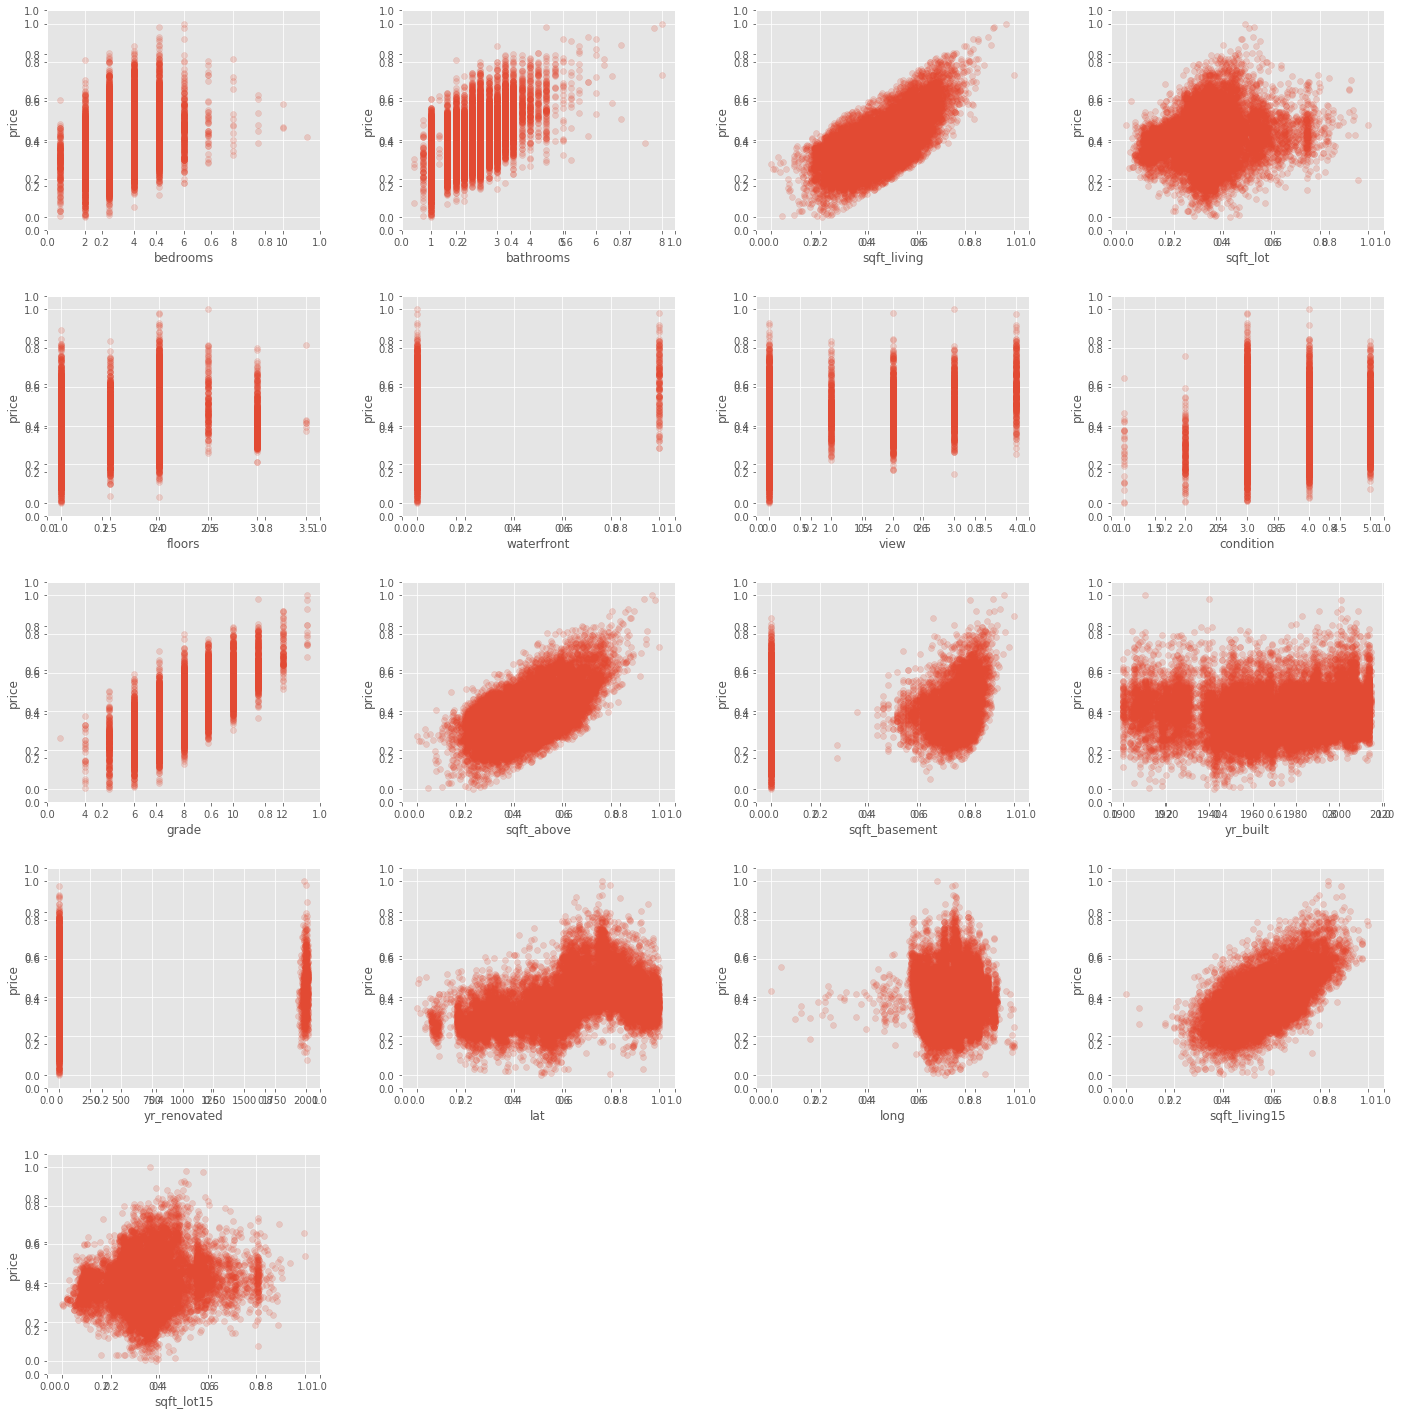

Computing most statstically significant features...


/Users/stevencontreras/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Add  bathrooms_e3_0__3_5i           with p-value 0.0
Add  grade_e5__6i                   with p-value 0.0
Add  sqft_living                    with p-value 0.0
Add  lat                            with p-value 0.0
Add  sqft_living15                  with p-value 2.59057e-282
Add  view_e3_0__4_0i                with p-value 7.17861e-216
Add  grade_e6__7i                   with p-value 9.30707e-167
Add  grade_e7__8i                   with p-value 2.15168e-173
Add  long                           with p-value 8.89115e-177
Add  grade_e4__5i                   with p-value 4.54086e-113
Add  condition_e2__3i               with p-value 1.58192e-139
Add  grade_e8__9i                   with p-value 2.98264e-128
Add  yr_built_e1920__1930i          with p-value 8.99663e-102
Add  yr_built_e1900__1910i          with p-value 4.87806e-109
Add  yr_built_e1910__1920i          with p-value 6.82692e-95
Add  waterfront_e0_0__1_0i          with p-value 1.4291e-64
Add  view_e2_0__3_0i                with p-valu

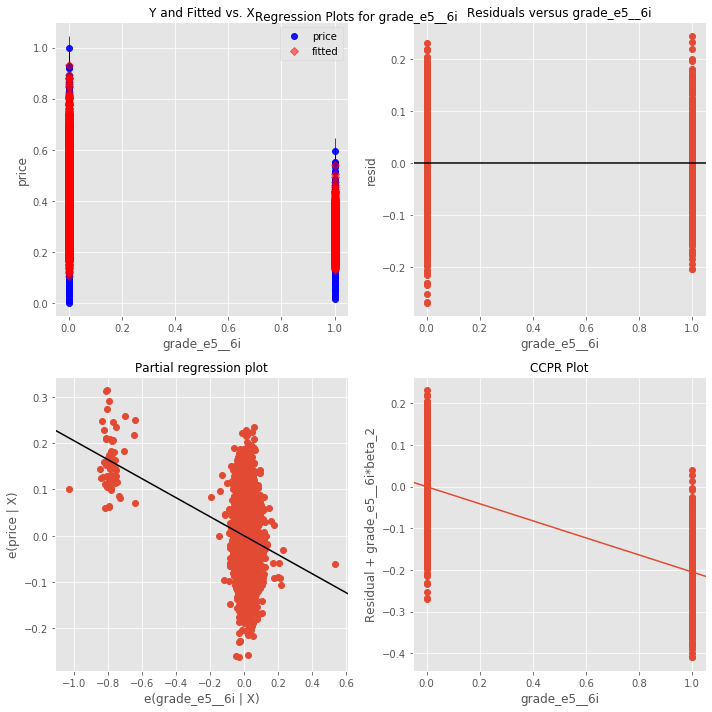

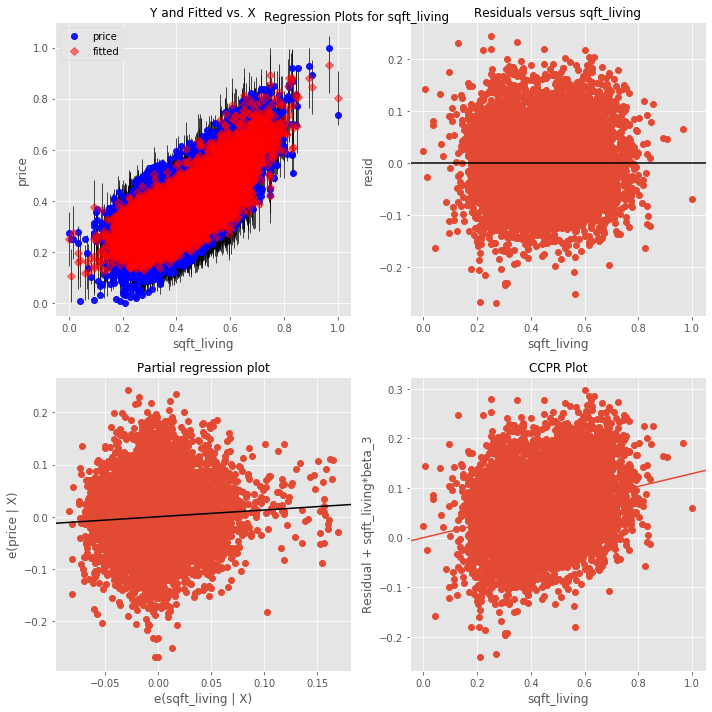

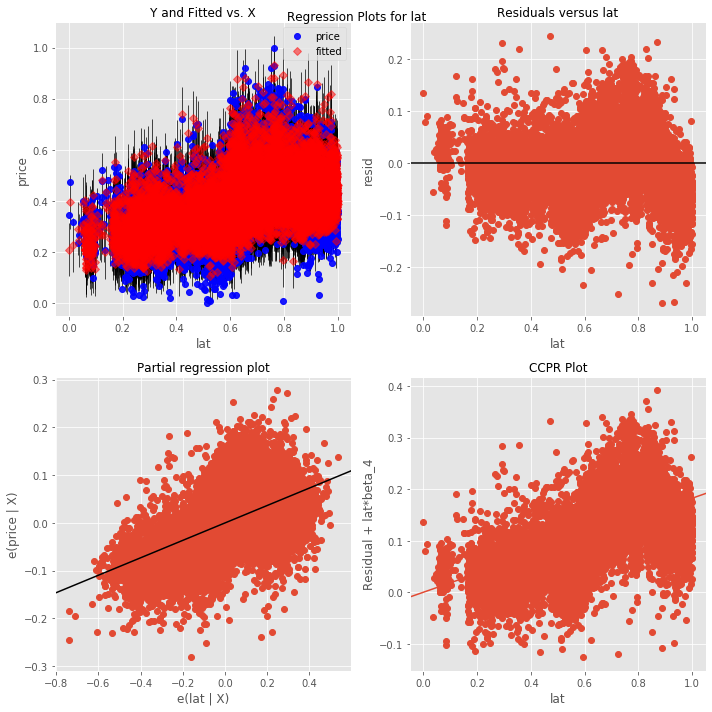

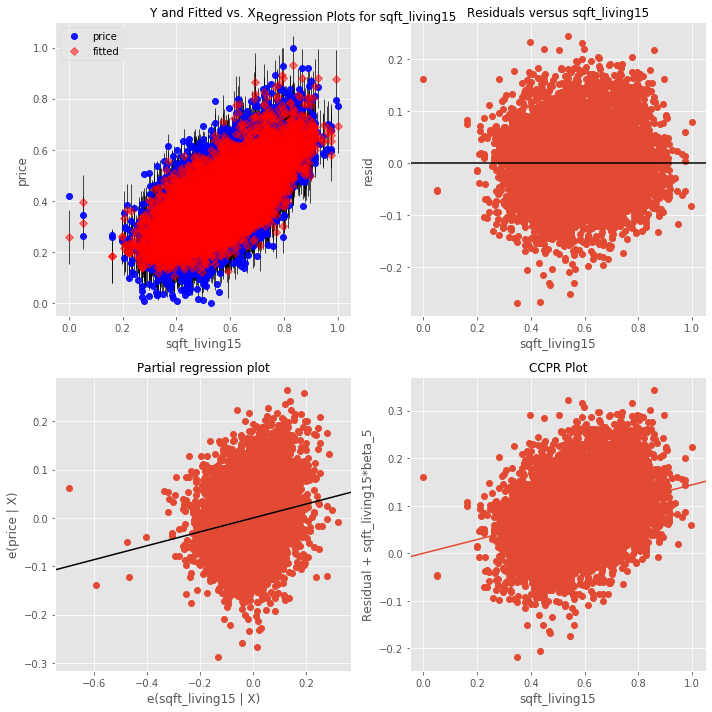

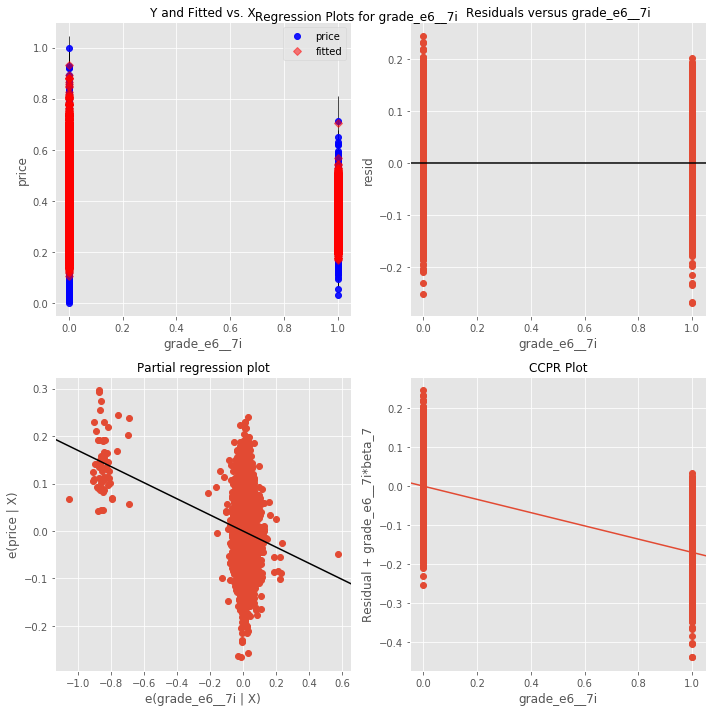

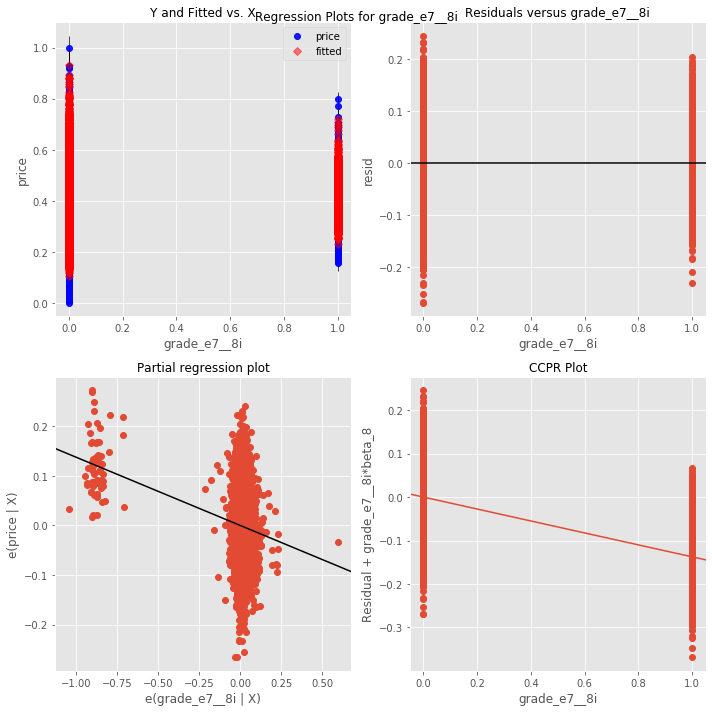

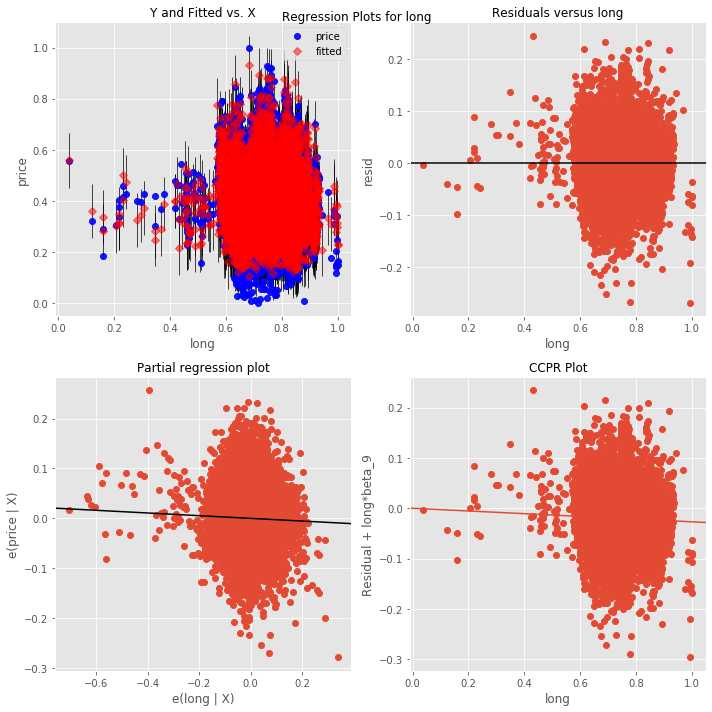

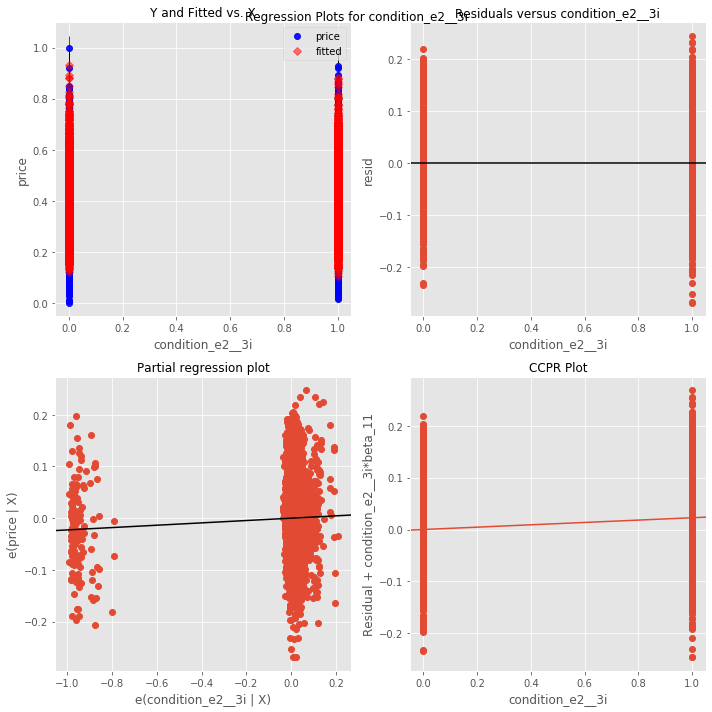

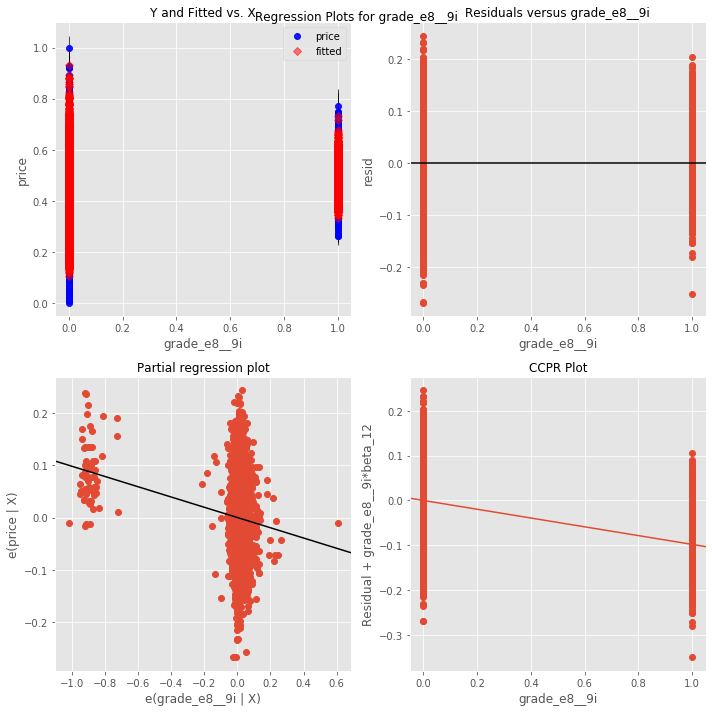

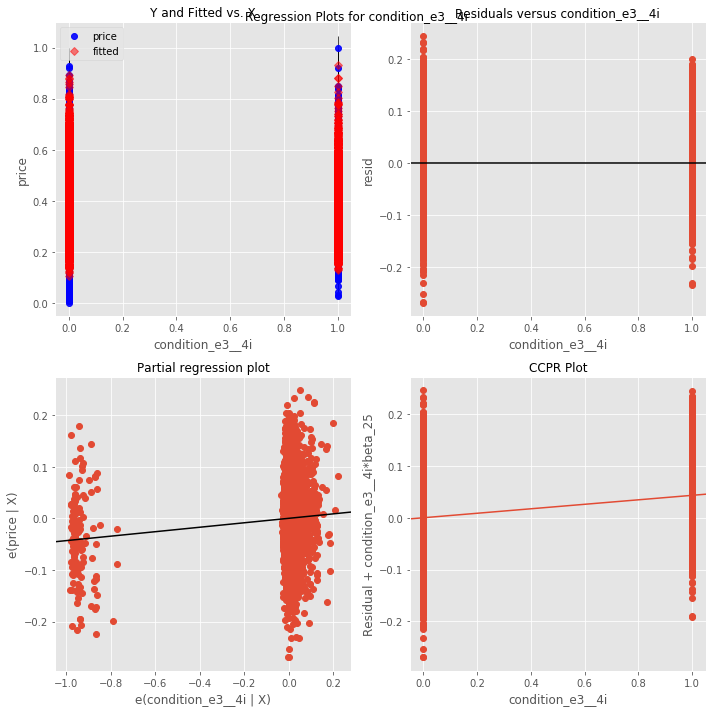

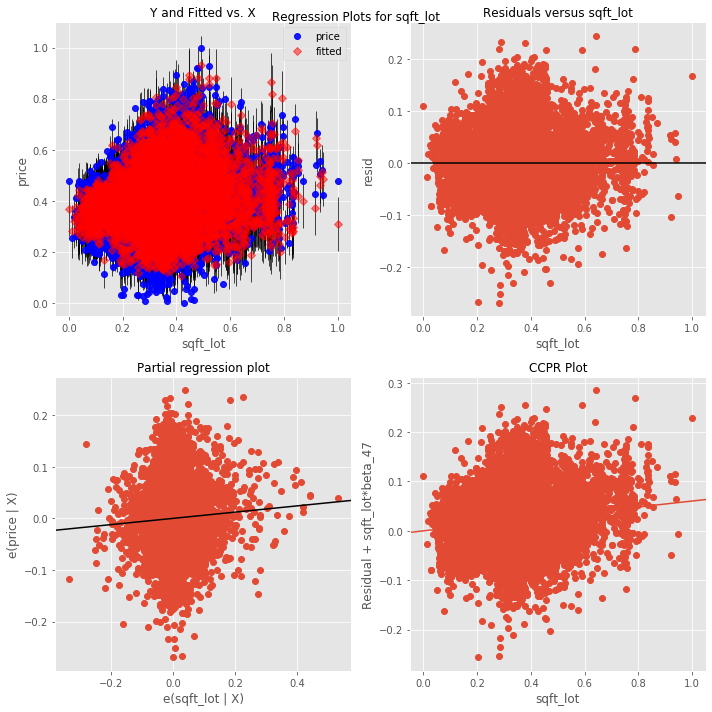

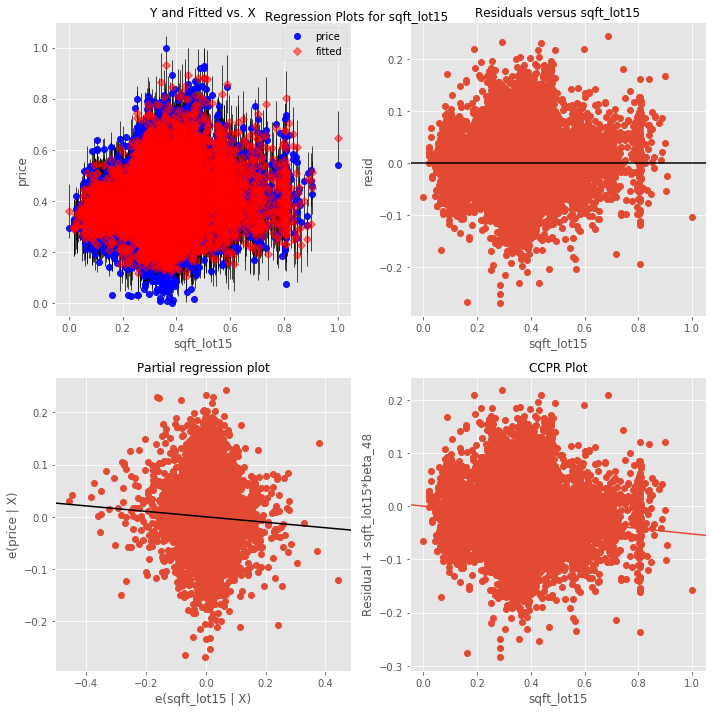

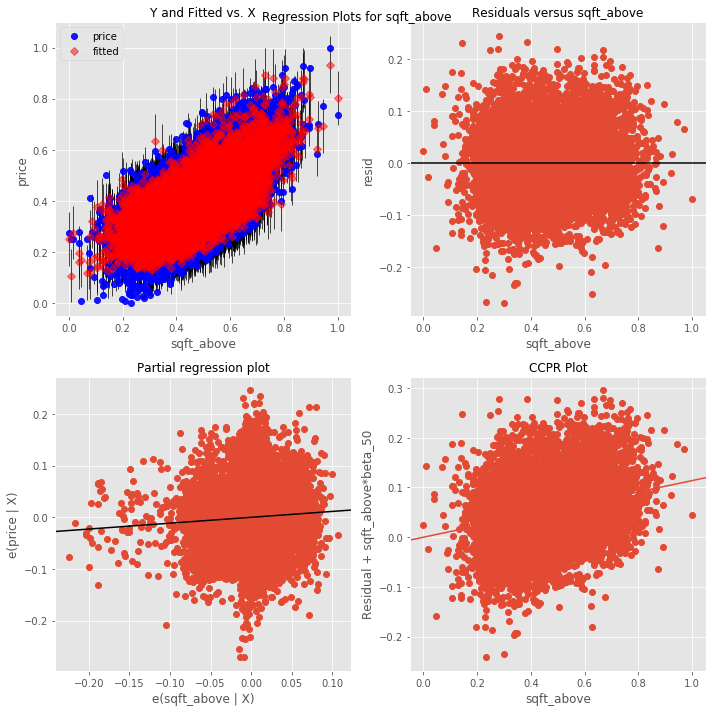

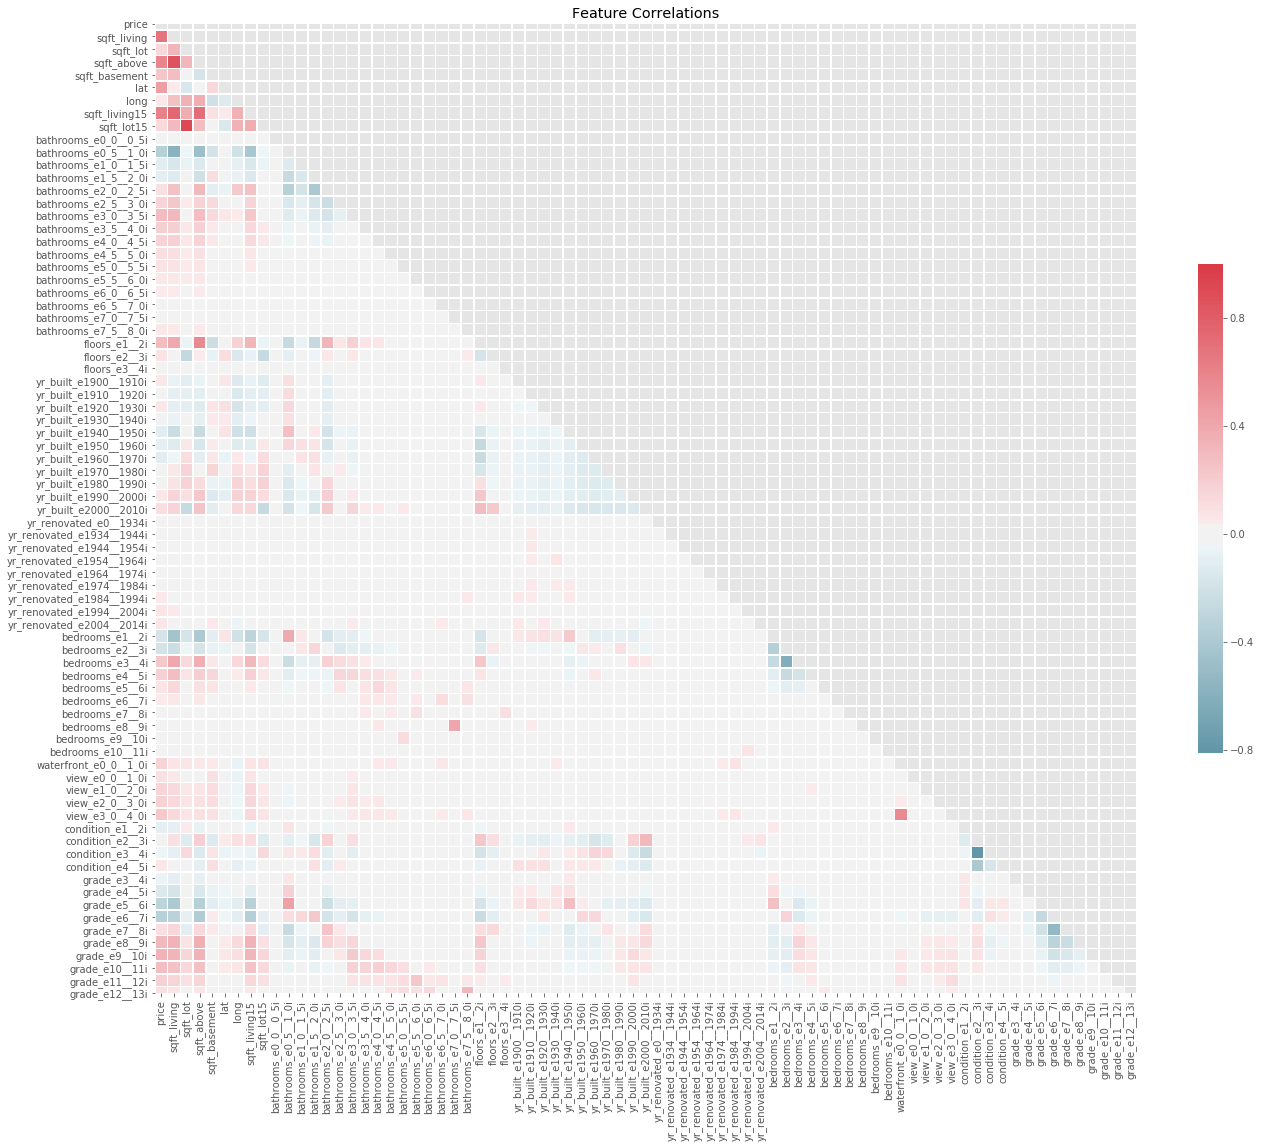

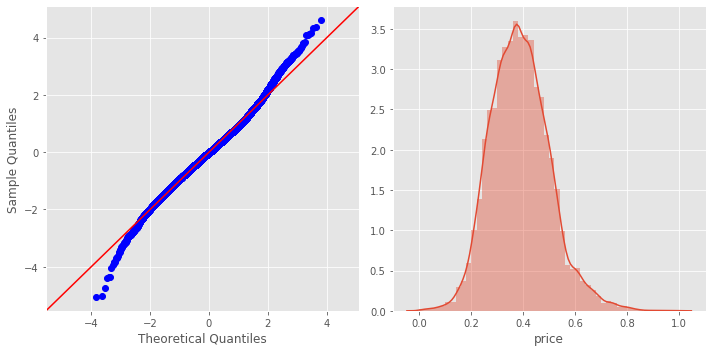

In [64]:
prev_sel_features = sel_features
prev_good_vif_features = good_vif_features
prev_bad_vif_features = bad_vif_features

do_final_model_validation = True
if do_final_model_validation:
    (
        sel_features
        , model_fit_results
        , train_mse
        , test_mse
        , good_vif_features
        , bad_vif_features
    ) = run_full_regression_experiment(
        kchd_transformed_and_scaled_df
        , target
        , to_drop=['zipcode']
        #, to_drop=[]
        , tr=tr
        , mv_r_sq_th=mv_r_sq_th
        , mv_mse_delta_th=mv_mse_delta_th
        , mv_bad_vif_ratio_th=mv_bad_vif_ratio_th
        , p_cat=p_cat
        , fn_init_bin_bases=my_init_bin_bases
        , exp_title="Full Regression, v. 1.0"
    )
    #summarize_multicolinearity(kchd_transformed_and_scaled_df, target, corr_filter_threshold=model_fit_results.rsquared)

### Step 4: EDA: Full Regression v. 1.0: Analysis

In [65]:
display(HTML("The QQ plot is not as attractive as it does exhibit more outliers by virtue of tail deviation! But we do see that our <b>$R^2 = {}$ has increased again</b>, and is becoming quite impressive.".format(round(model_fit_results.rsquared, 3))))
display(HTML("<b>The difference between MSE of our train/test partitions is still very, very low at approximately ${}$, as expected.</b>".format(int(abs(train_mse-test_mse)))))
display(HTML("Finally, <b>the bad VIF ratio - that is, measure of multicolinearity - has impressively dropped from {}% to {}% and now results in passing model validation conditions!</b>".format(
            round((len(prev_bad_vif_features)/len(prev_sel_features))*100, 2)
            , round((len(bad_vif_features)/len(sel_features))*100, 2)
        )
    )
)

We have, therefore, confirmed that we now have a valid basis (data set) upon which we can conduct valid linear regression experiments.

## Step 5: Run linear regression experiments to answer real questions
We will attempt to answer the following questions:
1. As a whole, do structural features or location influence home sale price more?
2. Given a set of required features, what can an arbitrary buyer expect to pay?
3. As a seller, which set of $n$ structural features can I enhance to boost the final sale price of my home in King's County?

### Step 5: Question 1: *As a whole, do structural features or location influence home sale price more?*

#### Step 5: Question 1: Specifying "structural features" vs. "location"
According to the definitions provided for our data set, the following features are "structural":
- **bedrooms**
- **bathrooms**
- **sqft_living**
- **sqft_lot**
- **floors**
- **waterfront**
- **condition**
- **grade**
- **sqft_above**
- **sqft_basement**
- **yr_built**
- **yr_renovated**

And here our the features based on "locastion"
- **lat**
- **long**

It can be argued that **zipcode** and $(lat, long)$ are correlated, with more findelity derived from $(lat, long)$, so we simply opted to drop **zipcode** from consideration for this reason.

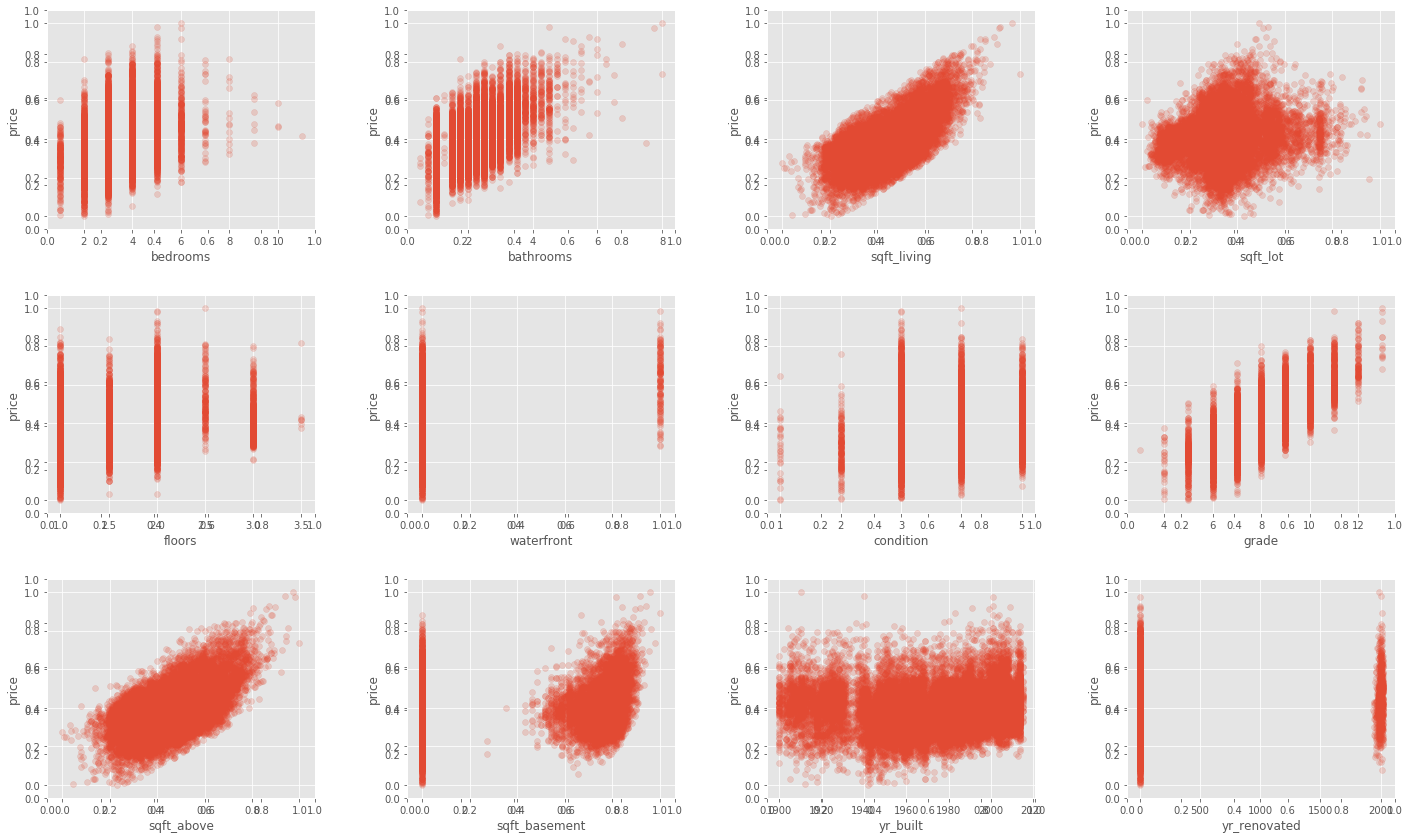

Computing most statstically significant features...


/Users/stevencontreras/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Add  bathrooms_e3_0__3_5i           with p-value 0.0
Add  grade_e5__6i                   with p-value 0.0
Add  sqft_living                    with p-value 0.0
Add  grade_e6__7i                   with p-value 7.45544e-237
Add  grade_e7__8i                   with p-value 5.88063e-201
Add  yr_built_e1920__1930i          with p-value 7.87086e-174
Add  grade_e4__5i                   with p-value 2.2879e-173
Add  yr_built_e1900__1910i          with p-value 7.27702e-160
Add  grade_e8__9i                   with p-value 1.3152e-142
Add  yr_built_e1910__1920i          with p-value 3.44016e-133
Add  yr_built_e1940__1950i          with p-value 5.90053e-153
Add  waterfront_e0_0__1_0i          with p-value 1.21449e-128
Add  yr_built_e1930__1940i          with p-value 1.36679e-102
Add  yr_built_e1950__1960i          with p-value 4.38602e-107
Add  grade_e3__4i                   with p-value 4.30922e-79
Add  grade_e9__10i                  with p-value 6.57325e-57
Add  sqft_basement                  wit

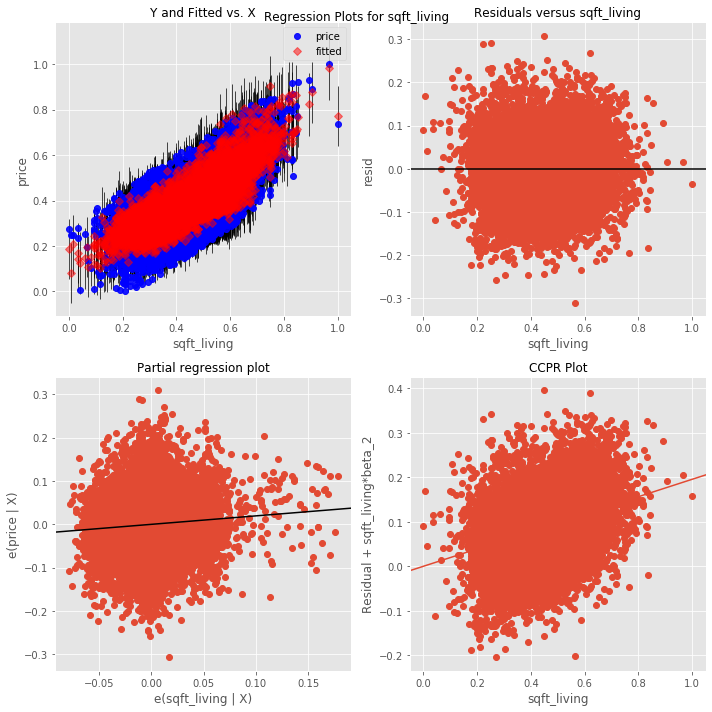

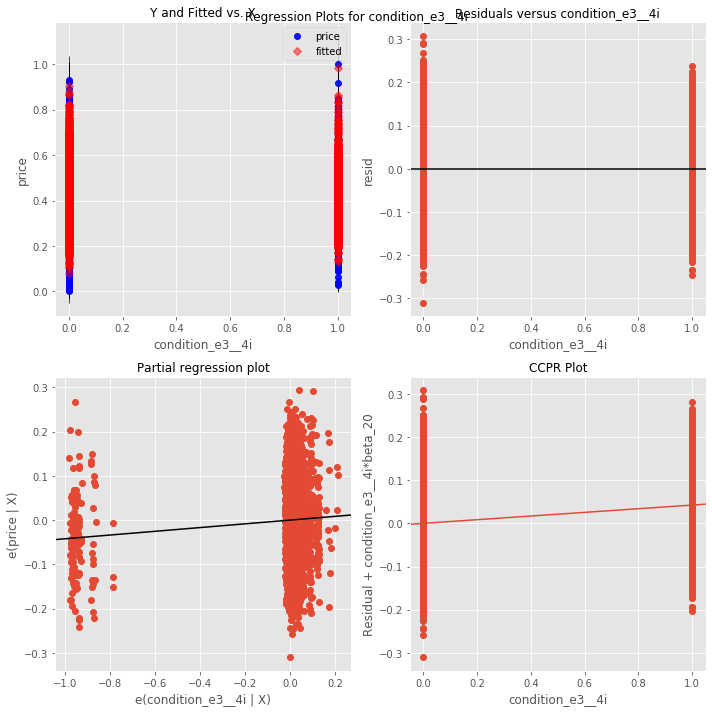

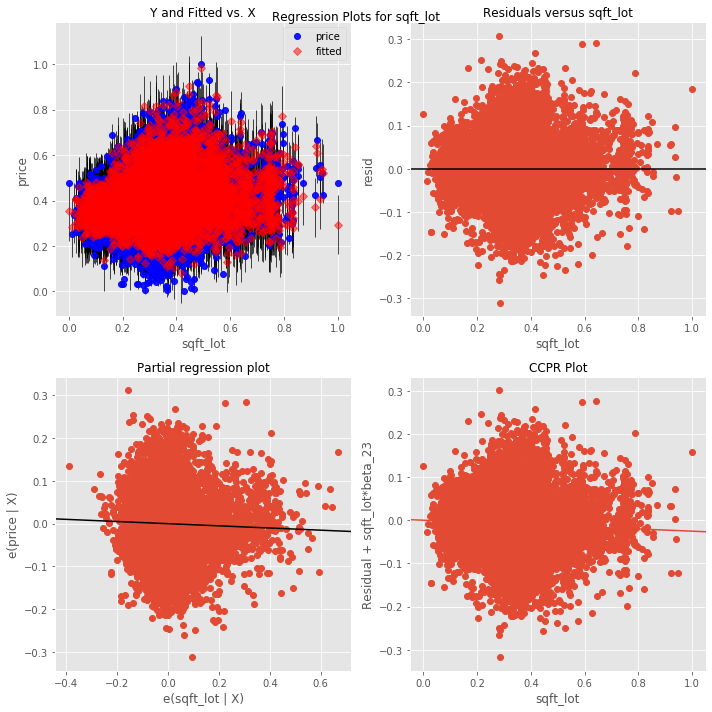

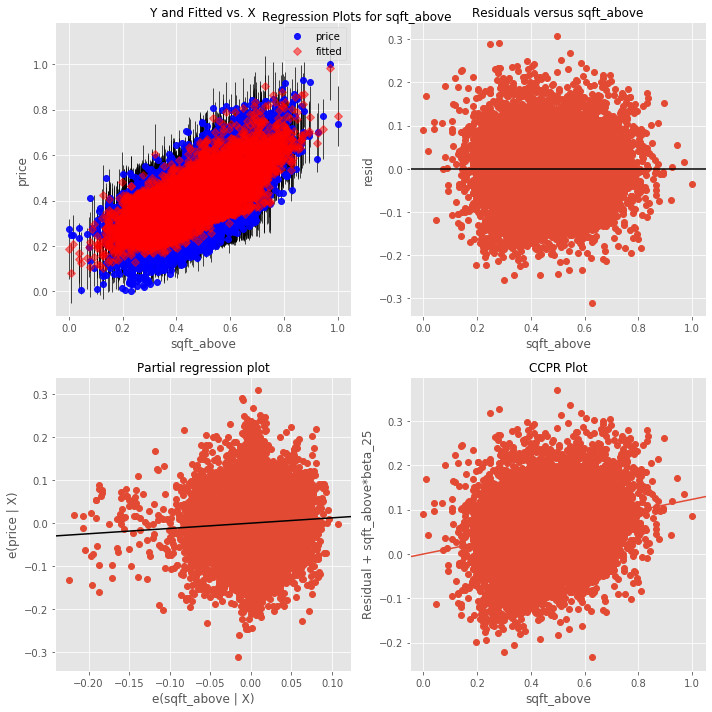

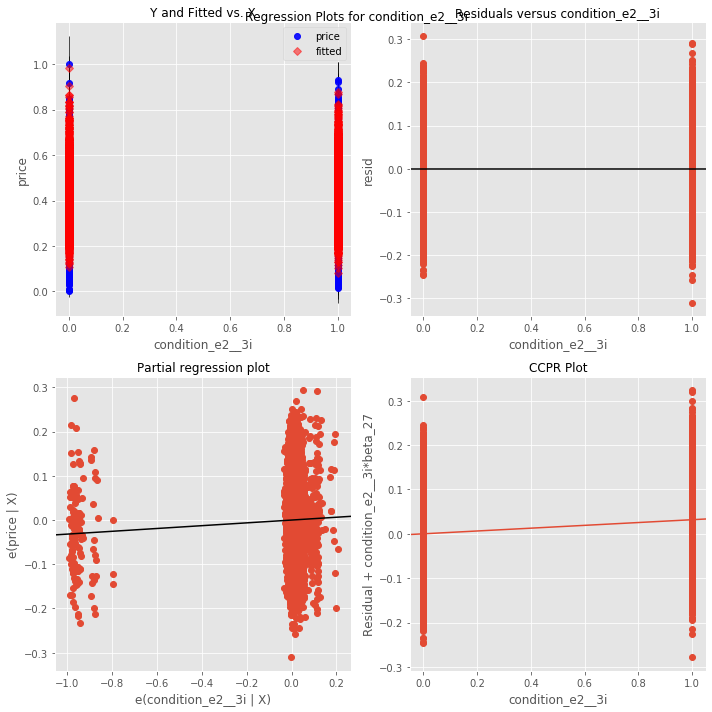

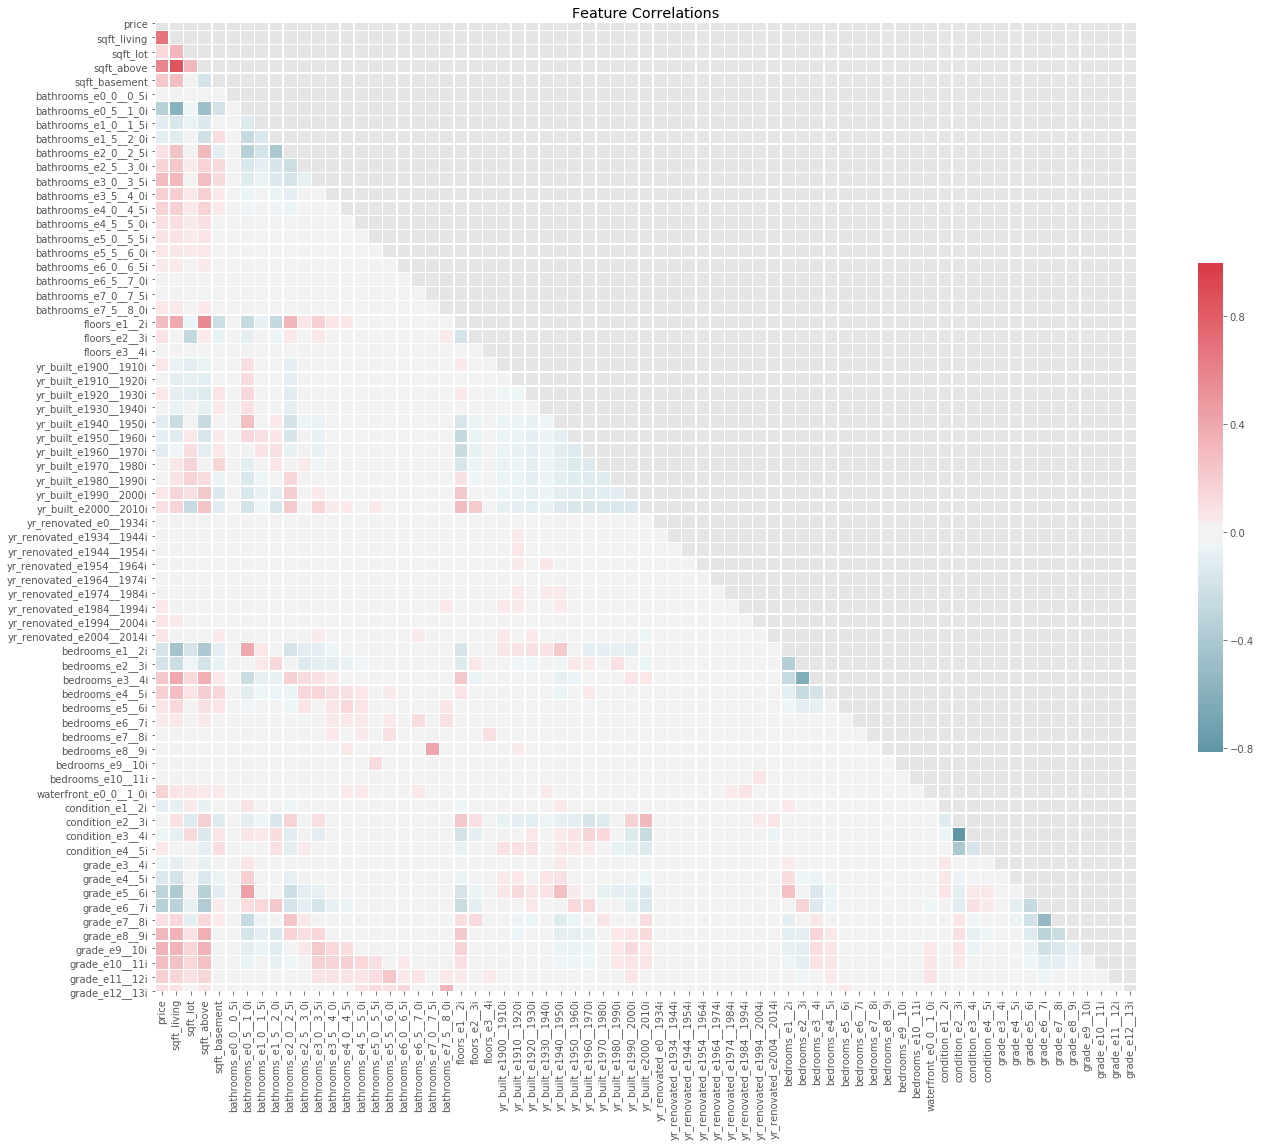

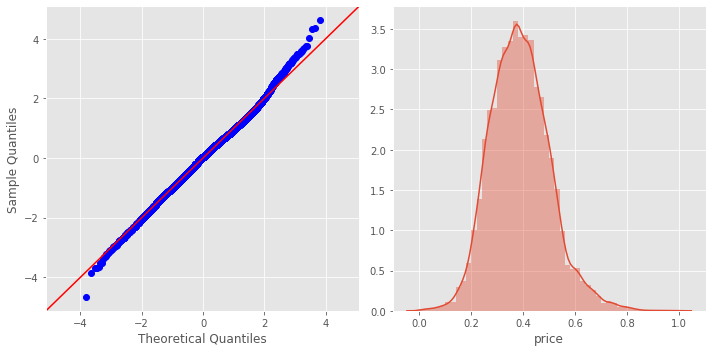

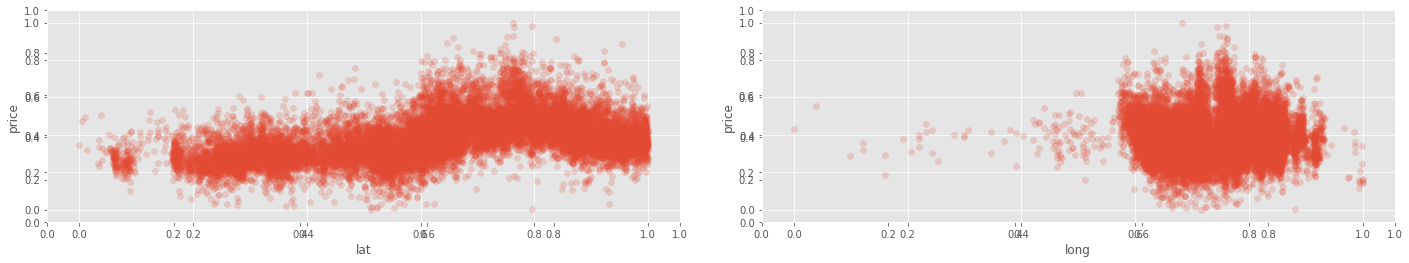

Computing most statstically significant features...
Add  lat                            with p-value 0.0
Add  long                           with p-value 5.53157e-65


/Users/stevencontreras/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


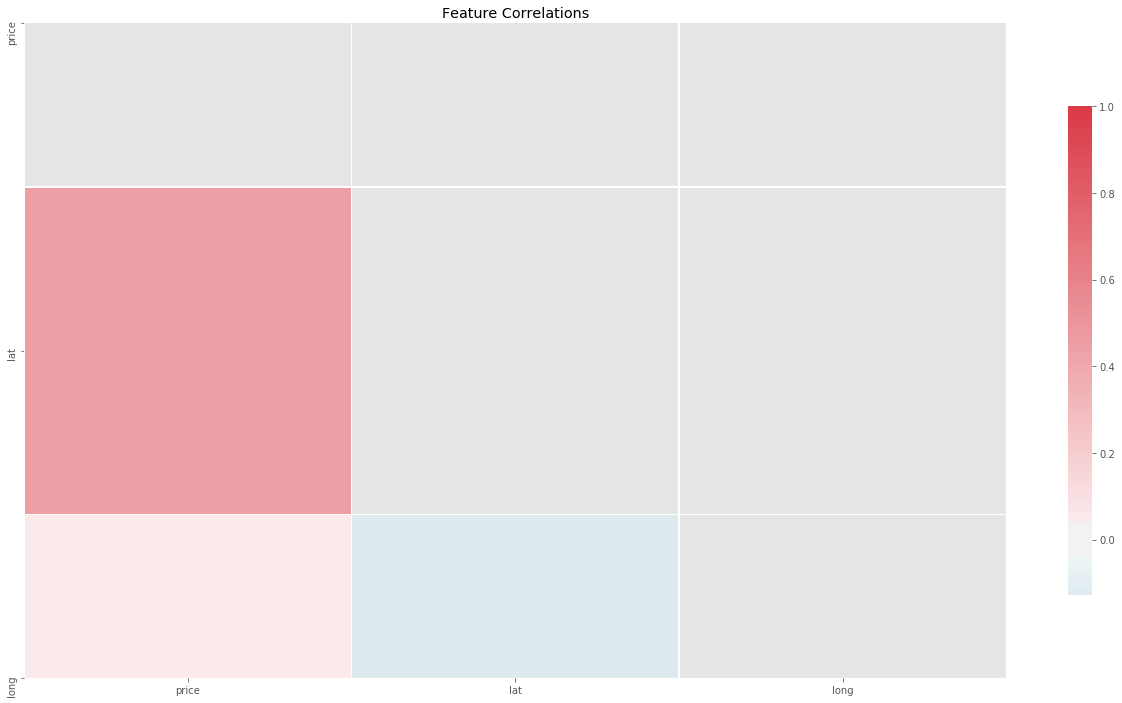

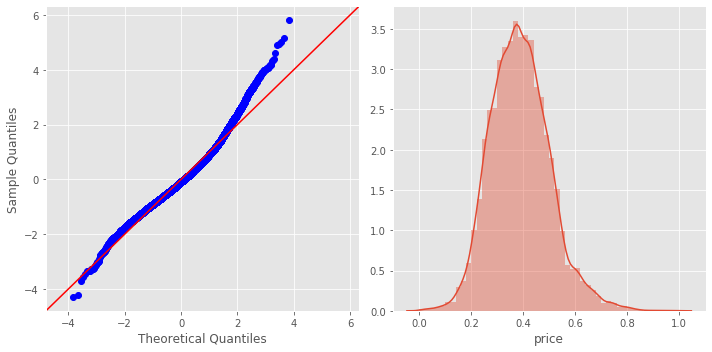

In [66]:
mv_r_sq_th = 0.60 # let's be a little more forgiving with our Coefficient of Determination since we are dealing with a reduced feature set

structural_features = [
    'bedrooms'
    , 'bathrooms'
    , 'sqft_living'
    , 'sqft_lot'
    , 'floors'
    , 'waterfront'
    , 'condition'
    , 'grade'
    , 'sqft_above'
    , 'sqft_basement'
    , 'yr_built'
    , 'yr_renovated'
]
kchd_structural_df = pd.concat([kchd_transformed_and_scaled_df[[target]], kchd_transformed_and_scaled_df[structural_features]], axis=1, join='inner')
(
    sel_features
    , model_fit_results
    , train_mse
    , test_mse
    , good_vif_features
    , bad_vif_features
) = run_full_regression_experiment(
    kchd_structural_df
    , target
    , to_drop=[]
    , tr=tr
    , mv_r_sq_th=mv_r_sq_th
    , mv_mse_delta_th=mv_mse_delta_th
    , mv_bad_vif_ratio_th=mv_bad_vif_ratio_th
    , p_cat=p_cat
    , fn_init_bin_bases=my_init_bin_bases
    , exp_title="Full Regression Experiment, Question 1: Structural Features"
)
structural_sel_features = sel_features
structural_good_vif_features = good_vif_features
structural_bad_vif_features = bad_vif_features
structural_rsquared = model_fit_results.rsquared
structural_train_mse = train_mse
structural_test_mse = test_mse
#summarize_multicolinearity(kchd_structural_df, target, corr_filter_threshold=model_fit_results.rsquared)

location_features = ['lat', 'long']
kchd_location_df = pd.concat([kchd_transformed_and_scaled_df[[target]], kchd_transformed_and_scaled_df[location_features]], axis=1, join='inner')
(
    sel_features
    , model_fit_results
    , train_mse
    , test_mse
    , good_vif_features
    , bad_vif_features
) = run_full_regression_experiment(
    kchd_location_df
    , target
    , to_drop=[]
    , tr=tr
    , mv_r_sq_th=mv_r_sq_th
    , mv_mse_delta_th=mv_mse_delta_th
    , mv_bad_vif_ratio_th=mv_bad_vif_ratio_th
    , p_cat=p_cat
    , fn_init_bin_bases=my_init_bin_bases
    , exp_title="Full Regression Experiment, Question 1: Location Features"
)
location_sel_features = sel_features
location_good_vif_features = good_vif_features
location_bad_vif_features = bad_vif_features
location_rsquared = model_fit_results.rsquared
location_train_mse = train_mse
location_test_mse = test_mse
#summarize_multicolinearity(kchd_location_df, target, corr_filter_threshold=model_fit_results.rsquared)

### Step 5: Question 1: *As a whole, do structural features or does location influence home sale price more?*: Analysis

In [67]:
display(HTML("The QQ plot of our regresssion model of <b>structural</b> features is outstanding!<br><b>$R^2 = {}$ of our model using structural features is decent</b>.<br><br>".format(round(structural_rsquared, 3))))
display(HTML("The QQ plot of our regresssion model of <b>location</b> features is decent.<br><b>$R^2 = {}$ of our model using location features is dismal</b>.<br><br>".format(round(location_rsquared, 3))))
display(
    HTML(
        "<b>The difference between MSE of our train/test partitions for both models is still very, very low at approximately ${}$ and ${}$, respectively.</b>".format(
            int(abs(structural_train_mse-structural_test_mse))
        , int(abs(location_train_mse-location_test_mse)))
    )
)
display(
    HTML(
        "Finally, <b>the bad VIF ratios - that is, measures of multicolinearity - are {}% and {}%, respectively</b>".format(
            round((len(structural_bad_vif_features)/len(structural_sel_features))*100, 2)
            , round((len(location_bad_vif_features)/len(location_sel_features))*100, 2)
        )
    )
)

Since conditions 2 and 3 have passed for both models, we can have confidence in the *Coefficient of Determination*, $R^2$, of each, respectively.

In [68]:
display(HTML("<h2>CONCLUSION:</h2>"))
more_influential_feature_set = ""
more_influential_feature_set_probability = 0
less_influential_feature_set = ""
less_influential_feature_set_probability = 0
equal = False
equal_probability = 0
if structural_rsquared > location_rsquared:
    more_influential_feature_set = "structural"
    more_influential_feature_set_probability = round(structural_rsquared*100, 2)
    less_influential_feature_set = "location"
    less_influential_feature_set_probability = round(location_rsquared*100, 2)
elif location_rsquared > structural_rsquared:
    more_influential_feature_set = "location"
    more_influential_feature_set_probability = round(location_rsquared*100, 2)
    less_influential_feature_set = "structural"
    less_influential_feature_set_probability = round(structural_rsquared*100, 2)
else:
    equal = True
    equal_probability = round(structural_rsquared,2) # pick one or the other
display(
    HTML(
        "<h3>As a whole, we can say that <b>{}</b>.</h3>".format(
            "structural and location feature sets equally influence the sale price (with probability = {}%) of homes in King's County".format(equal_probability) if equal 
            else 
                "{} features influence the sale price (with probability = {}%) of homes in King's County more than {} features do (with probability = {}%).".format(
                    more_influential_feature_set
                    , more_influential_feature_set_probability
                    , less_influential_feature_set
                    , less_influential_feature_set_probability
                )
        )
    )
)

To get an intuitive feel that location does not much influence the sale price of homes in King's County, let's plot a heat map of sale price by location $(lat, long)$.  

### Explanation
Let's be clear about what we are asking, here.  

**If there were some linear relationship between $price \sim (lat, long)$ then this means we should expect to see the sale price of a home increase as the coordinates of $(lat, long)$ do**.  

Clearly, this doesn't make sense.  **Intuitively, we understand that increasing sale price of a home most certainly is NOT determined by increasing $(lat, long)$**.  It is then obvious that there is a problem in the way that we have asked that question.

Let's take a look at the a heatmap of home sales, wherein a location "grows hotter" in the heatmap by increasing price.

The function below accomplishes building the heatmap.  Credit goes to Sivji (2017) as the original author of this function.  Of course, I have modified it to suit my purposes.

In [69]:
def map_points(df, lat_col='lat', lon_col='long', zoom_start=11, \
                plot_points=False, pt_radius=15, \
                draw_heatmap=False, heat_map_weights_col=None, \
                heat_map_weights_normalize=True, heat_map_radius=15):
    """Creates a map given a dataframe of points. Can also produce a heatmap overlay

    Arg:
        df: dataframe containing points to maps
        lat_col: Column containing latitude (string)
        lon_col: Column containing longitude (string)
        zoom_start: Integer representing the initial zoom of the map
        plot_points: Add points to map (boolean)
        pt_radius: Size of each point
        draw_heatmap: Add heatmap to map (boolean)
        heat_map_weights_col: Column containing heatmap weights
        heat_map_weights_normalize: Normalize heatmap weights (boolean)
        heat_map_radius: Size of heatmap point

    Returns:
        folium map object
    """
    
    df_local = df.copy()

    ## center map in the middle of points center in
    middle_lat = df_local[lat_col].median()
    middle_lon = df_local[lon_col].median()

    curr_map = folium.Map(
        location=[middle_lat, middle_lon]
        , zoom_start=zoom_start
        , control_scale=True
    )
    


    # add points to map
    if plot_points:
        for _, row in df_local.iterrows():
            folium.CircleMarker(
                [row[lat_col], row[lon_col]]
                , radius=pt_radius
                , popup=row[heat_map_weights_col]
                , fill_color="#3db7e4", # divvy color
            ).add_to(curr_map)

    # add heatmap
    if draw_heatmap:
        # convert to (n, 2) or (n, 3) matrix format
        if heat_map_weights_col is None:
            cols_to_pull = [lat_col, lon_col]
        else:
            # if we have to normalize
            if heat_map_weights_normalize:
                df_local[heat_map_weights_col] = df_local[heat_map_weights_col]/df_local[heat_map_weights_col].sum()
            cols_to_pull = [lat_col, lon_col, heat_map_weights_col]
        locations = df_local[cols_to_pull].values
        curr_map.add_child(
            plugins.HeatMap(
                locations
                , min_opacity=0.2
                , max_val=df_local[heat_map_weights_col].max()
                , radius=heat_map_radius
                , max_zoom=1
                , blur=15
                , gradient={
                    0: 'blue'
                    , .25: 'lime'
                    , .50: 'yellow'
                    , .75: 'orange'
                    , 1: 'red'
                }
            )
        )

    return curr_map

And now we just call the function to generate our heatmap of home sale prices in King's County provided by our data set.

In [70]:
map_points(
    kchd_df
    , plot_points=False
    , draw_heatmap=True
    , heat_map_weights_normalize=False
    , heat_map_weights_col='price'
    , heat_map_radius=8
    , zoom_start=9
)

Clearly there is SOME relationship between $price \sim (lat, long)$, otherwise we would not see the clustering effect that we do - i.e. we see regions of clustering/increasing "heat", indicating similar-priced home are grouped together in regions.  

But that relationship is is certainly not linear in nature... at least, **price** is not linearly related to $(lat, long)$.

For now, if we wanted to move forward with this, with the intent of predicting price based on $(lat, long)$, we could obviously create a mapping of region - perhaps some bounding box defined by $((lat, long)_{top\_left}, (lat, long)_{bottom\_right})$, for example.  This mapping would allows us to then "look" up home prices by $(lat, long)$.

My guess is that we would find that, given a fixed price range - i.e. the amount of "heat" above - we would find a similar set of structural features.

### What's the bottom line?
Without proving it, my guess is that, indeed there probably is a relationship between location $(lat, long)$ and structural features.  And, since there is an established relationship between $price \sim structural\_features$ and I am postulating that a mapping - specifically, a bijection - can be constructed between $structural\_features \leftrightarrow (lat, long)$.  This, it is postulated, then, forms a transitive mapping from $(lat, long) \rightarrow structural\_features \rightarrow price$.  In other words, $(lat, long) \rightarrow price$ or, put plainly, with this mapping, location, or $(lat, long)$ does in fact determine price (because mapping $(lat, long) \rightarrow structural\_features$ with sufficiently high probility). 

From the 20,000 ft. view, my assertion - without proving it (for now) - is that, basically, because such a mapping can be found, structural features likely found in a given home can be more or less encpasulated by its location $(lat, long)$.

That is, $(lat, long)$ is colinear with structural features in determining price.

What really matters, mostly, in the end, is the set of structural features a given home has.

But didn't we say this from the beginning?  Yes and no.  The conclusion was correct but was applied to the wrong semantic version of "location" within the context of our original question.  As it turns out, it is postulated, that $(lat, long)$ more or less simply references, or is equivalent to, a likely common set of structural features.

Having said that, what are the most influential structural features impacting the sale price of a home?

### Step 5: Question 2: Which structrual features affect the value of a home the most?

In this case, we want to restrict our investigation to truly structural in nature.

According to the definitions of the features, **grade** is am evaluation of the home as a whole and is largeley dependent on structural features of the home; therefore, we will exclude this feature from consideration.

All other structural features that we examined earlier, then, are truly structural in nature.

Let's run another regression experiment on the structural features, excluding **grade** this time.

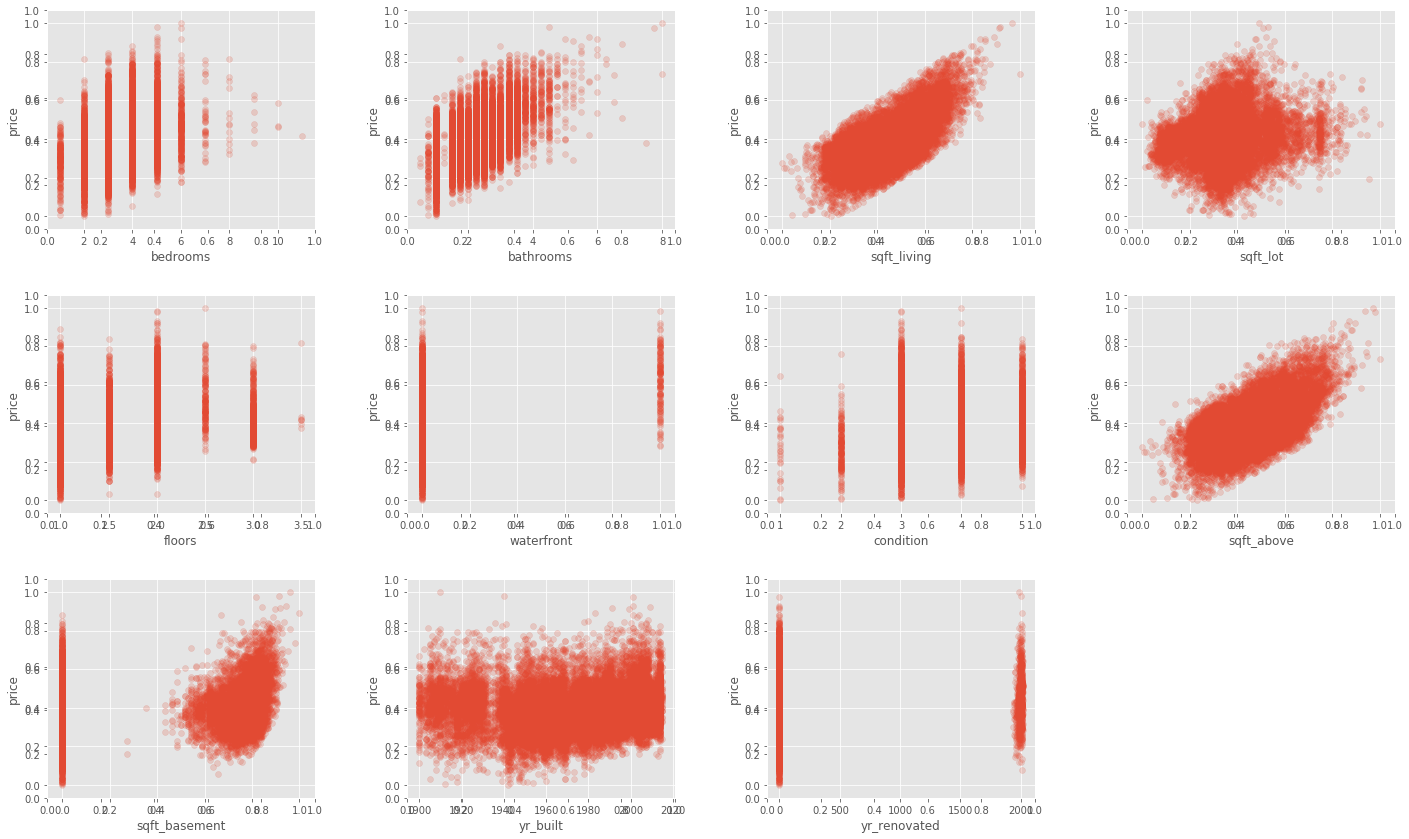

Computing most statstically significant features...


/Users/stevencontreras/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Add  bathrooms_e0_5__1_0i           with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  sqft_basement                  with p-value 0.0
Add  waterfront_e0_0__1_0i          with p-value 1.58822e-119
Add  yr_built_e1920__1930i          with p-value 9.66328e-115
Add  yr_built_e1900__1910i          with p-value 1.23199e-107
Add  bedrooms_e1__2i                with p-value 2.03758e-94
Drop bathrooms_e0_5__1_0i           with p-value 0.68591
Add  floors_e2__3i                  with p-value 5.05269e-62
Add  yr_built_e1910__1920i          with p-value 3.15625e-61
Add  sqft_living                    with p-value 3.12691e-57
Add  yr_built_e1940__1950i          with p-value 4.2237e-48
Add  yr_built_e1930__1940i          with p-value 8.38393e-40
Add  yr_built_e1950__1960i          with p-value 2.00392e-38
Add  bathrooms_e3_0__3_5i           with p-value 2.51105e-40
Add  bathrooms_e3_5__4_0i           with p-value 3.0261e-26
Add  condition_e4__5i               with p-value 2.

In [ ]:
tr = 0.30
mv_r_sq_th = 0.55

structural_features = [
    'bedrooms'
    , 'bathrooms'
    , 'sqft_living'
    , 'sqft_lot'
    , 'floors'
    , 'waterfront'
    , 'condition'
    #, 'grade'
    , 'sqft_above'
    , 'sqft_basement'
    , 'yr_built'
    , 'yr_renovated'
]
kchd_structural_df = pd.concat(
    [kchd_transformed_and_scaled_df[[target]]
     , kchd_transformed_and_scaled_df[structural_features]]
    , axis=1
    , join='inner'
)
(
    sel_features
    , model_fit_results
    , train_mse
    , test_mse
    , good_vif_features
    , bad_vif_features
) = run_full_regression_experiment(
    kchd_structural_df
    , target
    , to_drop=[]
    , tr=tr
    , mv_r_sq_th=mv_r_sq_th
    , mv_mse_delta_th=mv_mse_delta_th
    , mv_bad_vif_ratio_th=mv_bad_vif_ratio_th
    , p_cat=p_cat
    , fn_init_bin_bases=my_init_bin_bases,
    exp_title="Full Regression Experiment, Question 2: \"True\" Structural Features"
)
structural_sel_features = sel_features
structural_good_vif_features = good_vif_features
structural_bad_vif_features = bad_vif_features
structural_rsquared = model_fit_results.rsquared
structural_train_mse = train_mse
structural_test_mse = test_mse
summarize_multicolinearity(kchd_structural_df, target, corr_filter_threshold=model_fit_results.rsquared)

# References

Pawan, S. (2017). Predicting King County House Prices. Presentation, https://www.slideshare.net/PawanShivhare1/predicting-king-county-house-prices.

Sivji, A. (2019). Visualizing Geospatial Data in Python Using Folium. Retrieved from https://alysivji.github.io/getting-started-with-folium.html

Alcid | Blog - Making a Geographic Heatmap with Python. (2019). Retrieved from https://alcidanalytics.com/p/geographic-heatmap-in-python